# Infalling Analysis
## Summer 2023
### Author: Mitsuru Watanabe

**Key findings**
- Unique Infall Trajectory among Satellites
- Higher Mass Loading Factor and fractional gas loss by SN for Massive Galaxies (i.e. mass dependency on gas loss)
- No Significant Difference between times at infall and mass loading factor / fractional gas loss


This notebook was originated from the question about the relation of star formation history and satellite trajectory to gas loss. How does SFH around infall affect SN-driven gas loss for different mass size galaxies?
Since the rate of SN-heating is proportional to SFR, I analyzed the change in SFR for each timestep after infalling process and how that shows the unique behavior for each different sim data. Some part of this code was borrowed from Hollis' particle tracking notebook.

Later in the notebook, I have looked at how infall, quench, and 1st pericentric point can affect the mass loading factor, $\eta$, (Mass Outflow Rate/SFR) and how that differ for different satellites with different masses. Then I looked at fraction of gas loss for SN-heated gas and expelled gas. This continues to `F23_SNe_Gas_Loss.ipynb` notebook in Fall 2023.

In [1]:
#importing everything
from base import *
from analysis import * 
from compiler import *
from infallinganalysis import *

base.py executed
compiler.py executed


In [7]:
import pandas as pd
import h5py
path = '../Justice_League_Code/Data/tracked_particles.hdf5'
with h5py.File(path) as data:
    print(len(data.keys()), 'Available keys:', *data.keys())

29 Available keys: h148_10 h148_12 h148_2 h148_249 h148_251 h148_27 h148_282 h148_3 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_401 h242_69 h242_8 h329_117 h329_29 h329_7


In [8]:
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

## Data Aquisition

In [313]:
#checking the satellite data, 'h148_10' for instance
key = 'h148_10'

sim, haloid = str(key[:4]), int(key[5:])
data = read_tracked_particles(sim, haloid)

> Returning <tracked_particle> dataset <


In [15]:
print(filenames[sim])
s = pynbody.load(filenames[sim])
h = s.halos()

halo = h.load_copy(haloid)

/home/watanabe/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200crit_h148/h148.cosmo50PLK.3072g3HbwK1BH.004096


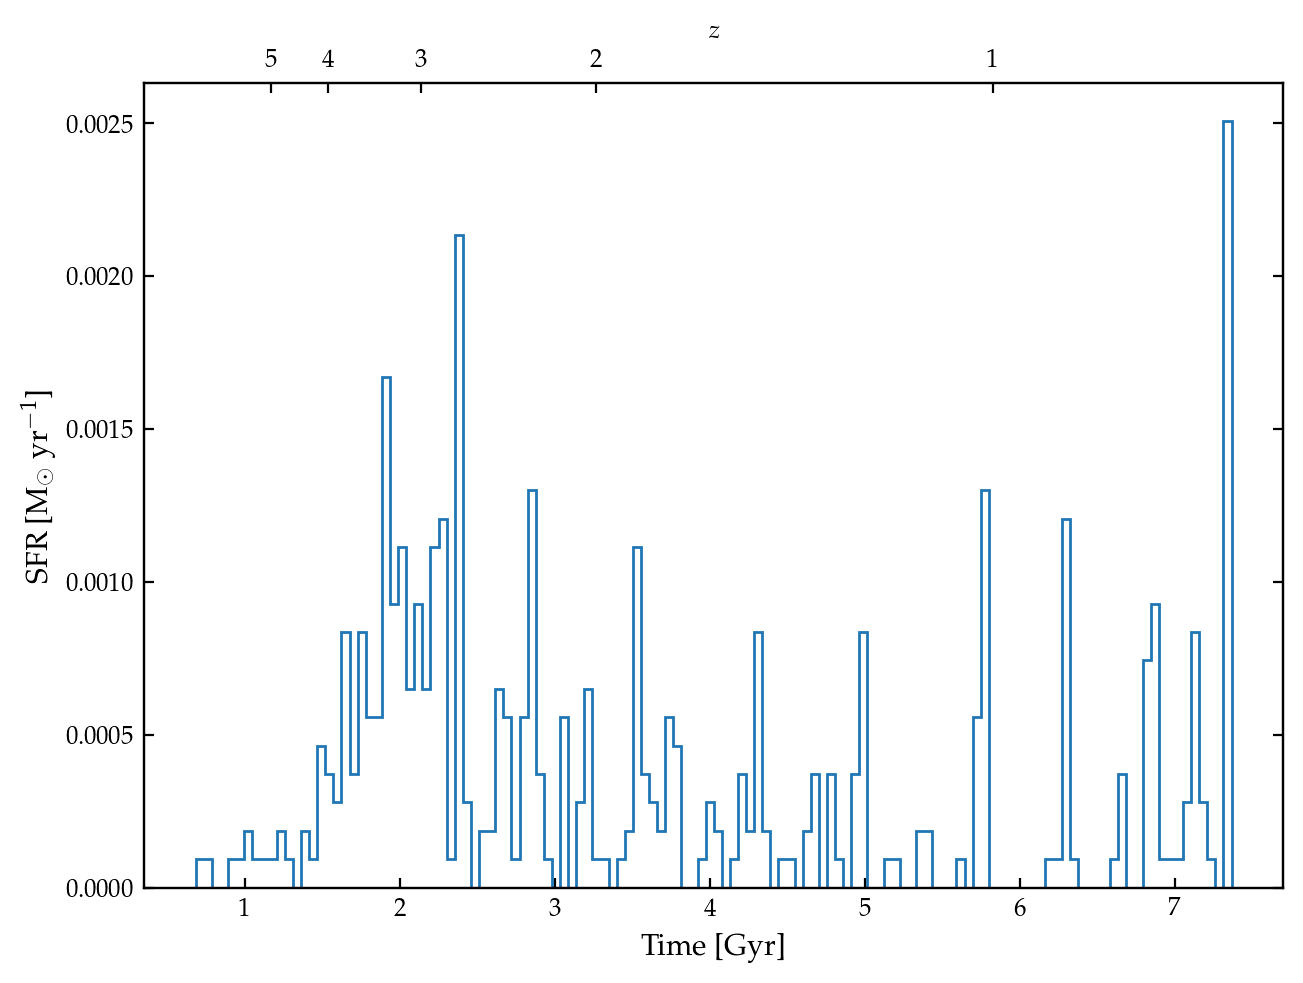

In [16]:
sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)

In [25]:
len(np.unique(data.time))

21

In [4]:
satdata = pd.read_csv('all-satellite-data-overtime.csv')
satdata.head()

time          t      redshift    a  haloid  z0haloid         mstar  \
0  13.800797  13.800797  5.299428e-11  1.0       2         2  2.268773e+09   
1  13.800797  13.800797  5.299428e-11  1.0       3         3  1.502171e+09   
2  13.800797  13.800797  5.299428e-11  1.0       4         4  4.317847e+08   
3  13.800797  13.800797  5.299428e-11  1.0       6         6  3.315968e+08   
4  13.800797  13.800797  5.299428e-11  1.0       7         7  2.359537e+08   

           mgas          mass       Rvir  ... outflow_23 inflow_temp_23  \
0  8.252345e+09  9.575866e+10  95.146148  ...   0.456047   15363.511326   
1  2.975036e+09  4.697010e+10  76.051992  ...   0.152226   17219.020137   
2  9.706413e+08  3.248971e+10  67.257466  ...   0.063139   18398.471344   
3  1.010160e+09  2.869601e+10  64.527622  ...   0.104018   19798.461485   
4  1.596514e+08  1.561130e+10  52.678621  ...   0.013406   42228.990382   

  outflow_temp_23 inflow_91 outflow_91 inflow_temp_91 outflow_temp_91   sim  \
0    38446.496389 -0.000273   0.042408   24099.185653    23684.923082  h148   
1    33047.679894 -0.000695   0.011663   17575.500434    23926.035774  h148   
2    33268.395814 -0.000039   0.005368   62860.398438    18839.048065  h148   
3    33827.872952 -0.000851   0.002218   20912.136058    26878.758550  h148   
4    43249.799751  0.000000   0.000273            NaN    18808.567349  h148   

      key       Hdist  
0  h148_2  504.170554  
1  h148_3  291.305391  
2  h148_4  173.039024  
3  h148_6  329.096623  
4  h148_7  340.276764  

[5 rows x 50 columns]

## Plotting

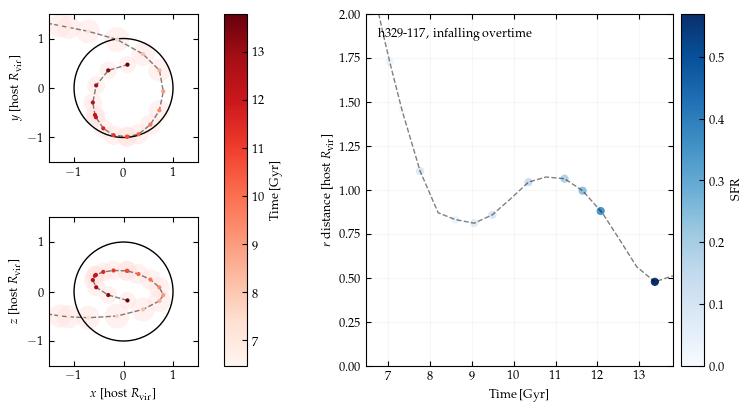

In [50]:
fig = plt.figure(dpi=100, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,6, width_ratios = [1.2,0.15,0.2,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,3:5])
cbax1 = plt.subplot(gs[:,1])
cbax2 = plt.subplot(gs[:,5])

R = 1.5 # in Rvir, the maximum radius to plot 

#calculate the relative distance from host in each time step
x_rels, y_rels, z_rels, r_rels, Rvirs, sfrs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
        d = data[data.time==t]
        satd = satdata[satdata.time==t]
        sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
        host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)

        h1Rvir = np.mean(d.hostRvir)
        satRvir = np.mean(d.satRvir)

        Rvirs = np.append(Rvirs, satRvir/h1Rvir)
        
        x_rel = (sat_x-host_x)/h1Rvir
        y_rel = (sat_y-host_y)/h1Rvir
        z_rel = (sat_z-host_z)/h1Rvir
        
        radii = plt.Circle((x_rel,y_rel),
                         satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
        ax0.add_artist(radii)

        radii = plt.Circle((x_rel,z_rel),
                         satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
        ax1.add_artist(radii)
        
        x_rels = np.append(x_rels, x_rel)
        y_rels = np.append(y_rels, y_rel)
        z_rels = np.append(z_rels, z_rel)
        r_rels = np.append(r_rels, np.sqrt(x_rel**2 + y_rel**2 + z_rel**2)) 
        
        sfrs = np.append(sfrs, np.mean(satd.sfr))
        
        ts = np.append(ts,t)
        
host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)
        
ax0.plot(x_rels, y_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
ax1.plot(x_rels, z_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
ax0.scatter(x_rels, y_rels, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rels, z_rels, c=ts, cmap='Reds', s=4, zorder=2)

ax2.scatter(ts, r_rels, c=sfrs, cmap='Blues', s=24)
ax2.plot(ts, r_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
ax2.grid(alpha = 0.1)

#print(ts, r_rels)

tmin, tmax = np.min(data.time), np.max(data.time)
sfrmin, sfrmax = np.min(satdata.sfr), np.max(satdata.sfr)
    
cb1 = mpl.colorbar.ColorbarBase(cbax1, cmap=mpl.cm.Reds, orientation='vertical', 
                                    norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                    label='Time [Gyr]')
cb2 = mpl.colorbar.ColorbarBase(cbax2, cmap=mpl.cm.Blues, orientation='vertical', 
                                    norm = mpl.colors.Normalize(vmin=sfrmin, vmax=sfrmax),
                                    label='SFR')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
ax2.annotate(f"{key.replace('_','-')}, infalling overtime", (0.04, 0.96), xycoords='axes fraction', va='top')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(tmin, tmax)
ax2.set_ylim(0, 2) # in Rvir

ax0.set_aspect('equal')
ax1.set_aspect('equal')

ax2.set_xlabel(r'Time [Gyr]')
ax2.set_ylabel(r'$r$ distance [host $R_{\rm vir}$]')

ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

plt.savefig(f'plots/{key}_infalling.pdf')

plt.show()

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


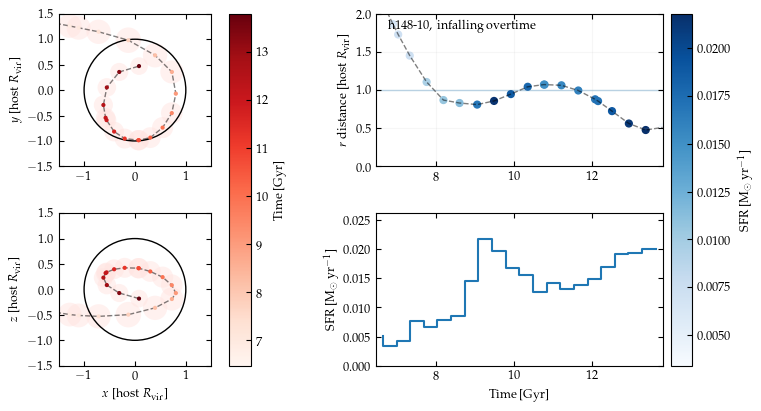

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


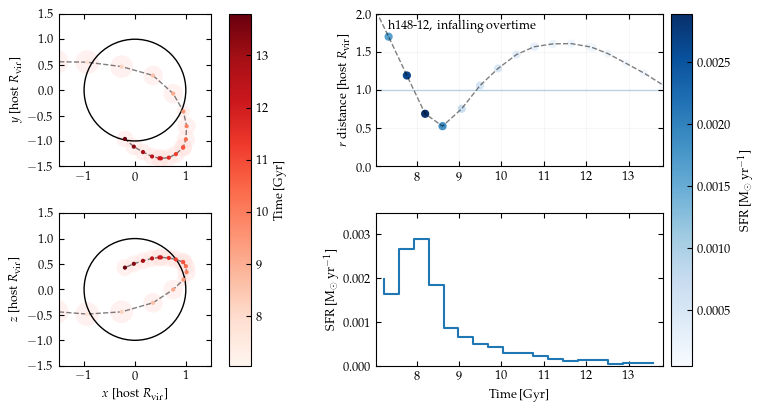

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


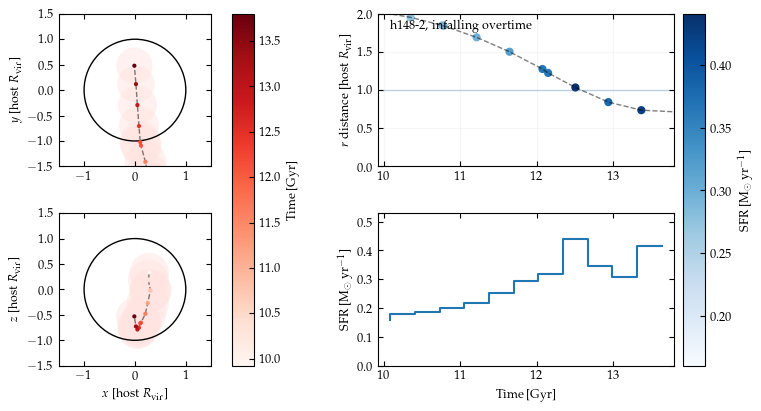

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


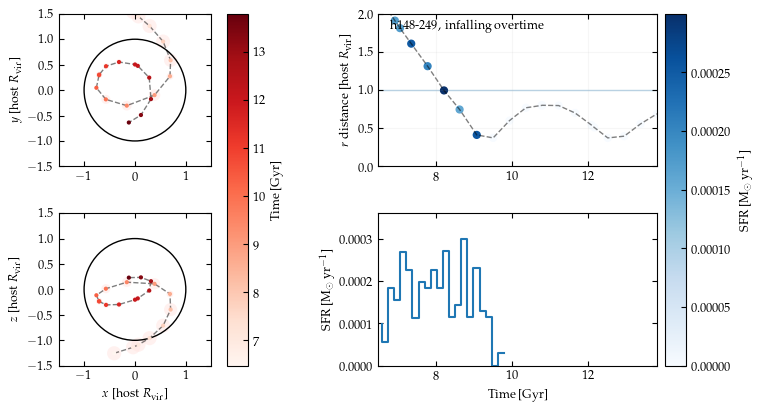

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


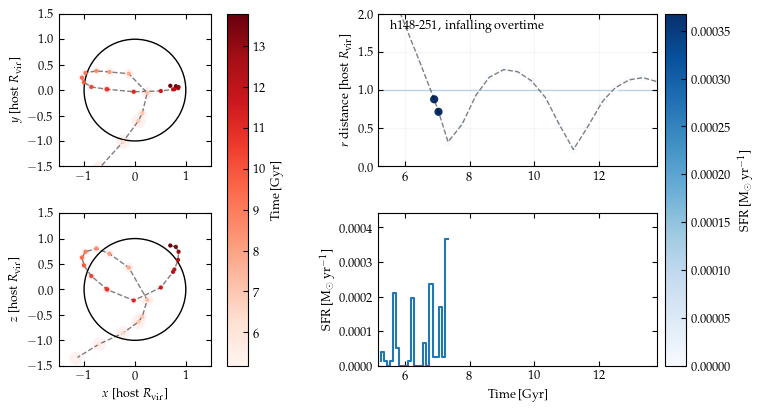

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


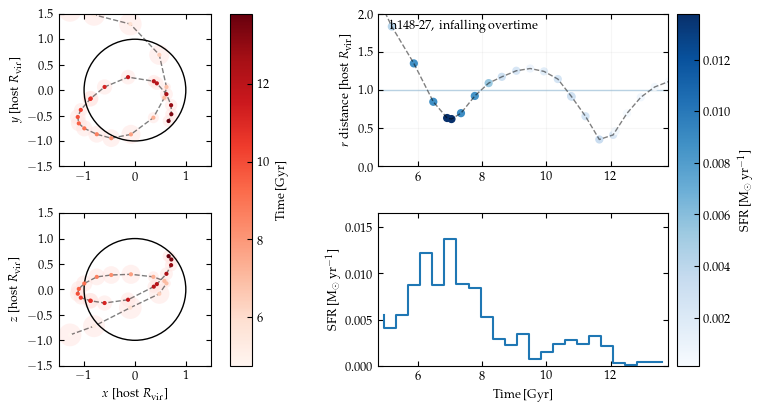

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


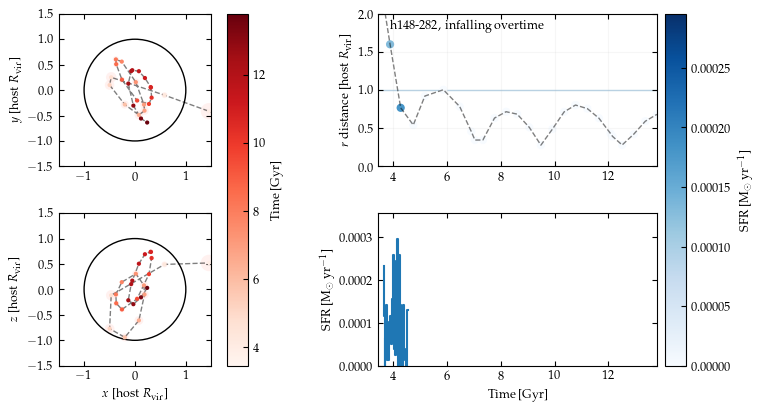

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


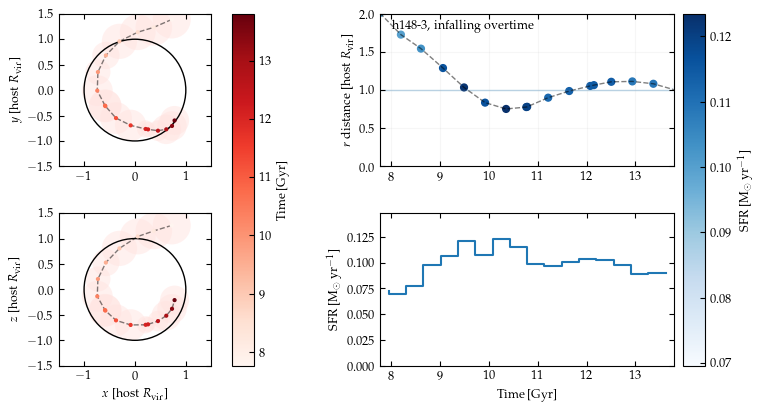

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


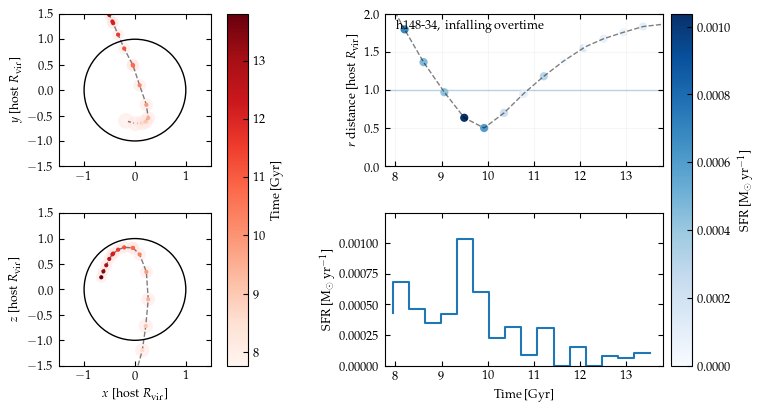

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


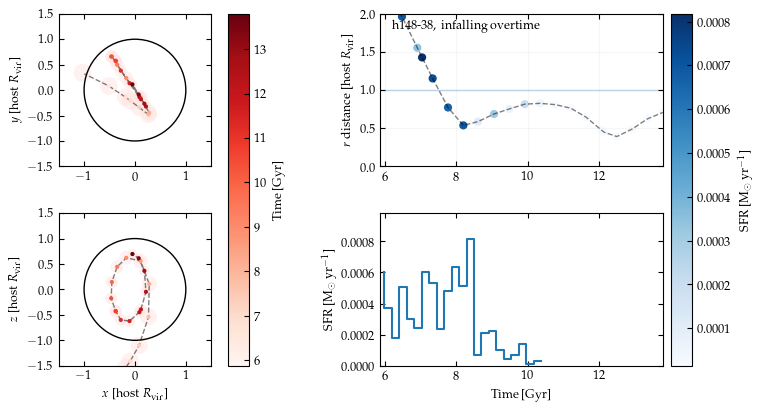

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


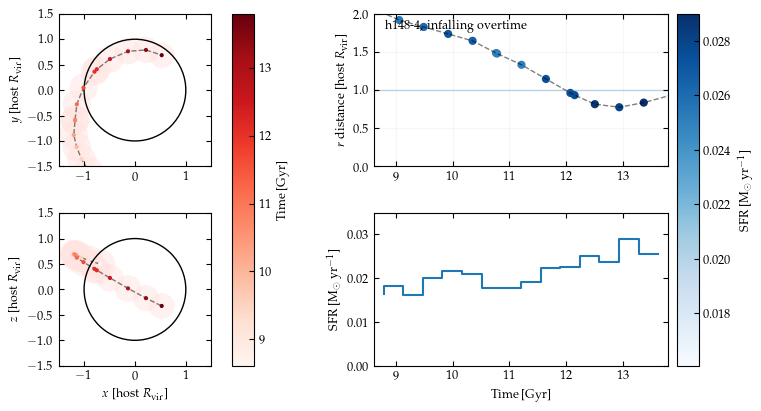

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


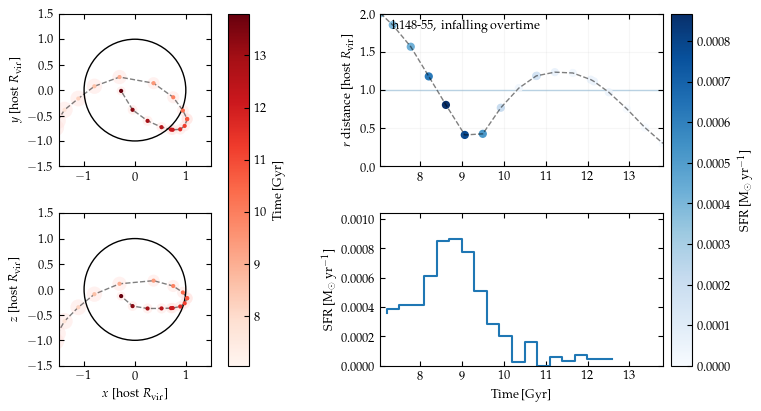

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


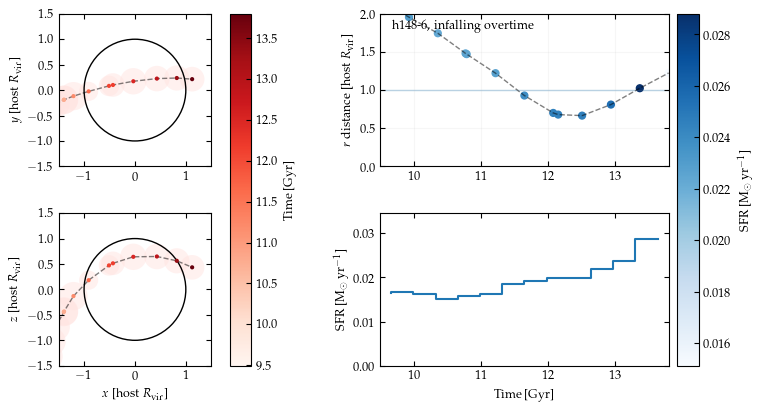

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


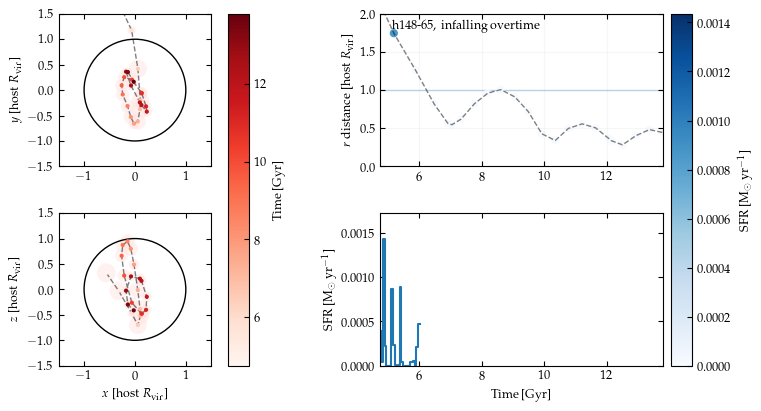

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


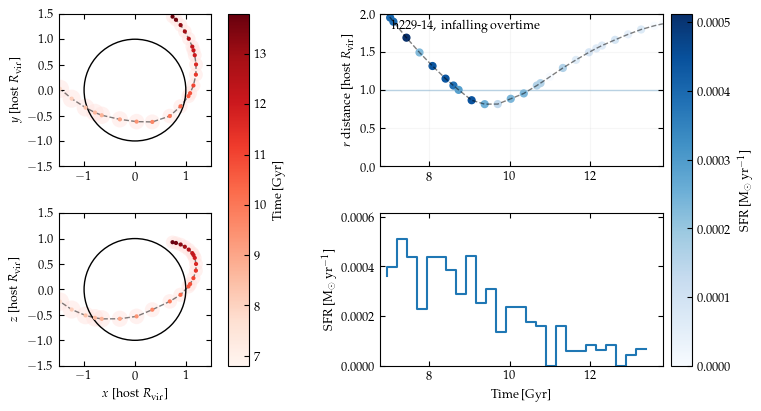

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


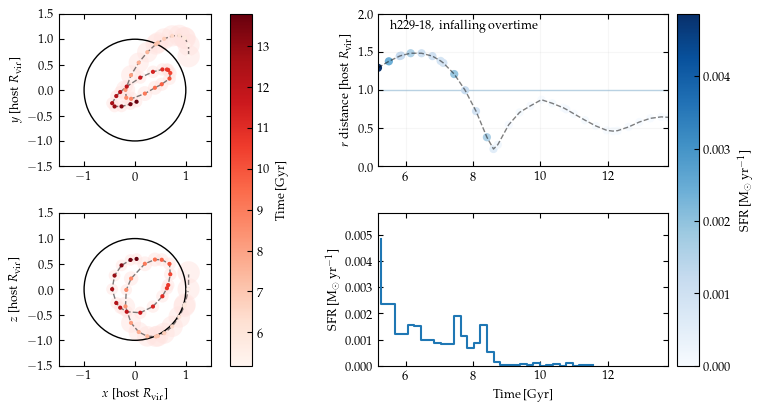

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


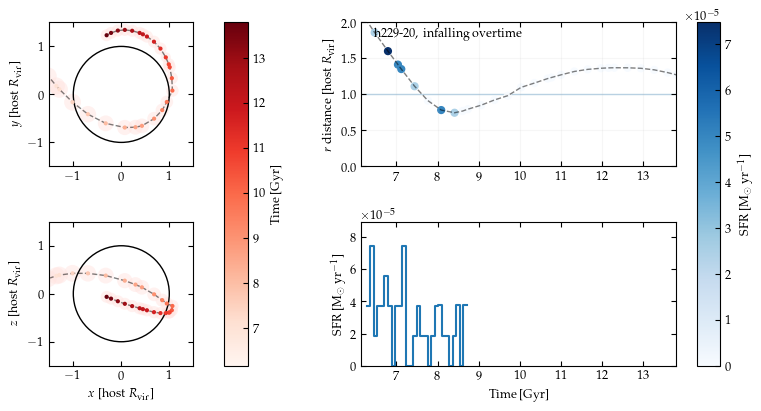

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


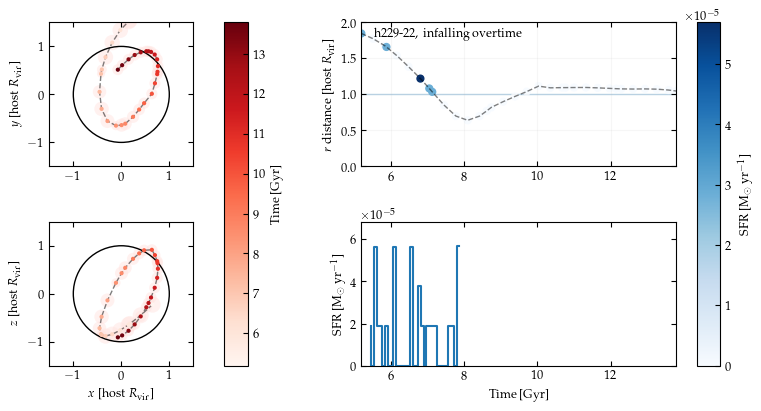

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


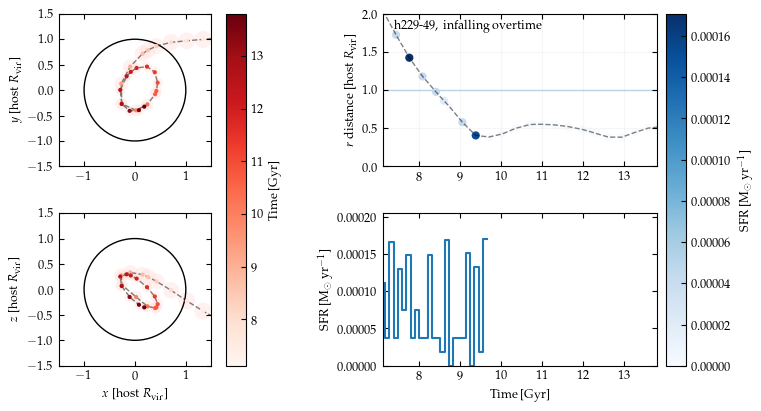

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


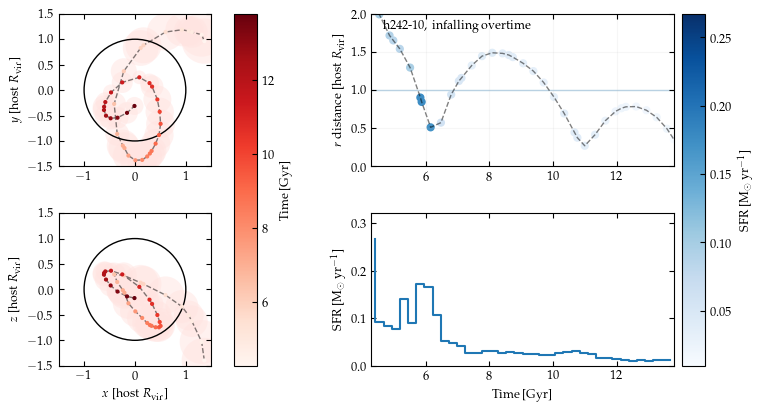

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


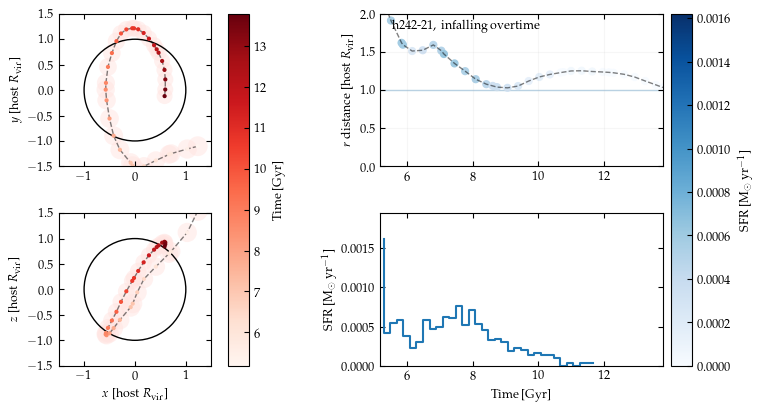

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


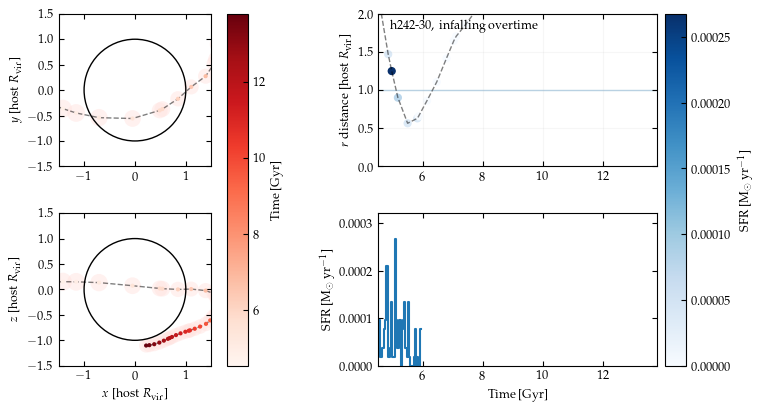

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


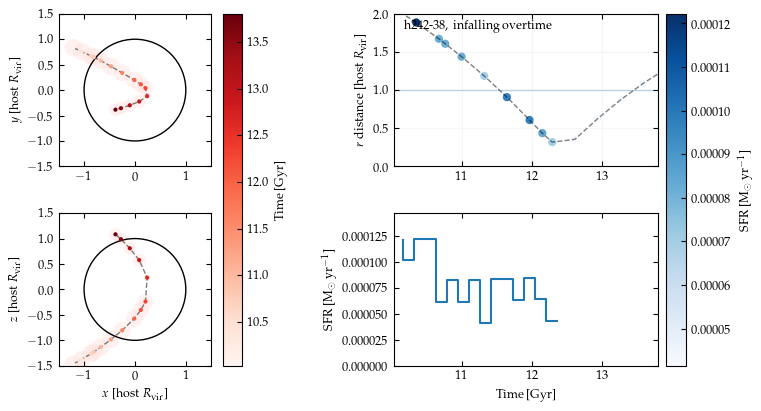

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


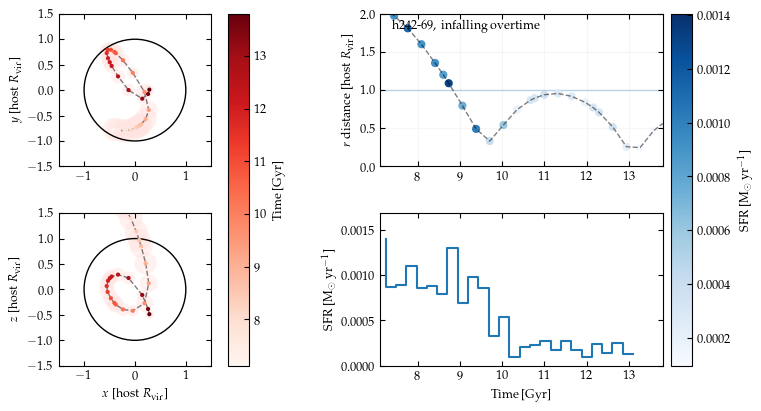

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


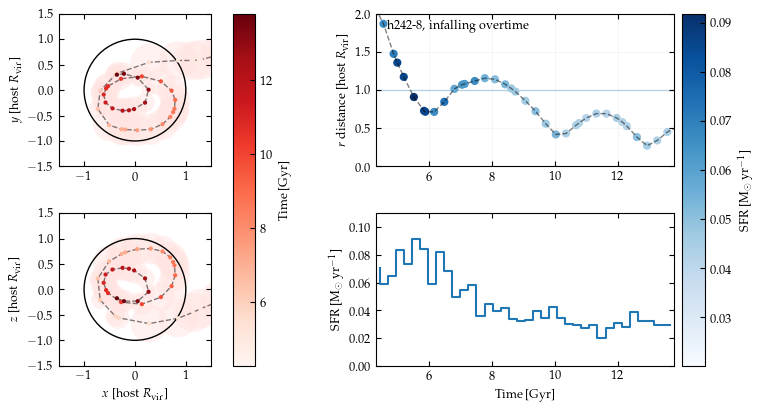

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


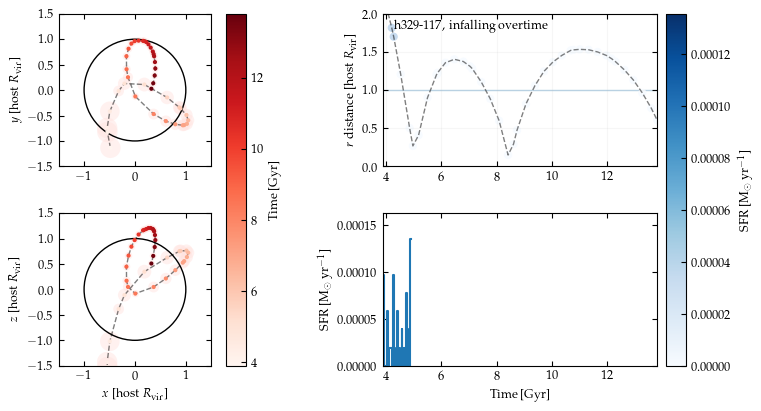

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


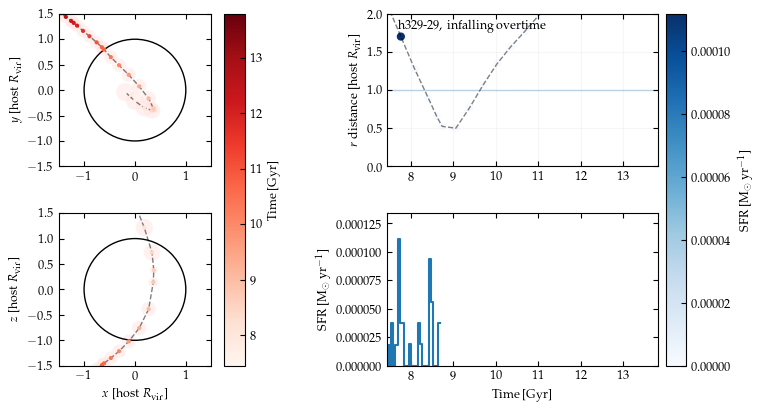

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


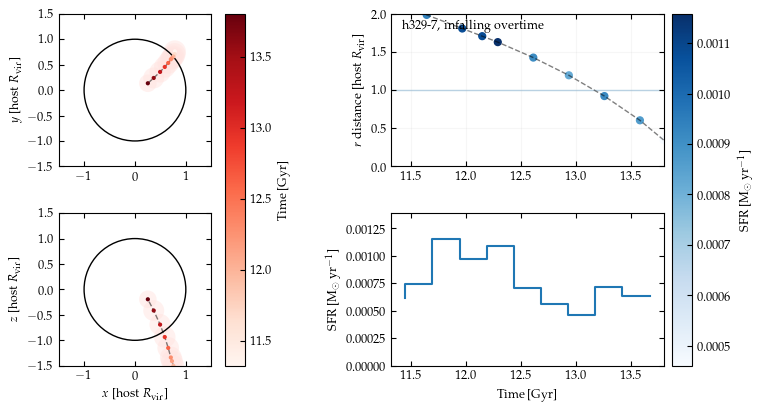

In [15]:
#replication for all the satellites
from math import isclose #used for plotting SFR over time graph

R = 1.5 # in Rvir, the maximum radius to plot 
exclude = []
#exclude = ['h148_10']

for key in keys:
    
    # skipping the one I already have
    if key in exclude:
        continue

    # read the sim tracked particles data
    sim, haloid = str(key[:4]), int(key[5:])
    data1 = read_tracked_particles(sim, haloid)
    sfr1, bins = calc_sfr(key)
    bincenters = 0.5*(bins[1:] + bins[:-1])
    
    tmin, tmax = np.min(data1.time), np.max(data1.time)
    sfrmin, sfrmax = np.min(sfr1), np.max(sfr1)
    #print(bins, bincenters, np.unique(data1.time))

    fig = plt.figure(dpi=100, figsize=(7.5,4))
    gs = mpl.gridspec.GridSpec(2,6, width_ratios = [1.2,0.15,0.2,1,1,0.15], figure=fig)
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[0,3:5])
    ax3 = plt.subplot(gs[1,3:5])
    cbax1 = plt.subplot(gs[:,1])
    cbax2 = plt.subplot(gs[:,5])
    
    #calculate the relative distance from host in each time step
    #also save time at 1st and min pericentric distance as well as when it crosses 1 Rvir
    x_rels, y_rels, z_rels, r_rels, Rvirs, sfrs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    for i, t in enumerate(np.unique(data1.time)):
            d = data1[data1.time==t] # find the satellite data at time t
            
            sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
            host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)

            h1Rvir = np.mean(d.hostRvir)
            satRvir = np.mean(d.satRvir)

            Rvirs = np.append(Rvirs, satRvir/h1Rvir)

            x_rel = (sat_x-host_x)/h1Rvir
            y_rel = (sat_y-host_y)/h1Rvir
            z_rel = (sat_z-host_z)/h1Rvir

            radii = plt.Circle((x_rel,y_rel),
                             satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
            ax0.add_artist(radii)

            radii = plt.Circle((x_rel,z_rel),
                             satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
            ax1.add_artist(radii)

            x_rels = np.append(x_rels, x_rel)
            y_rels = np.append(y_rels, y_rel)
            z_rels = np.append(z_rels, z_rel)
            r_rels = np.append(r_rels, np.sqrt(x_rel**2 + y_rel**2 + z_rel**2)) 

            #find sfr at time t
            if isclose(bincenters[i], t, abs_tol=1e-2):
                sfr = sfr1[i]
            else:
                try:
                    sfr = sfr1[np.where(bincenters > t)[0][0]] #pick the first bincenters that is close to t
                except:
                    sfr = 0 #no close bincenters, skip this
            sfrs = np.append(sfrs, sfr)

            ts = np.append(ts,t)

    host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
    ax0.add_artist(host_radius)

    host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
    ax1.add_artist(host_radius)

    #plot x, y trajectory
    ax0.plot(x_rels, y_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
    #plot x, z trajectory
    ax1.plot(x_rels, z_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
    ax0.scatter(x_rels, y_rels, c=ts, cmap='Reds', s=4, zorder=2)
    ax1.scatter(x_rels, z_rels, c=ts, cmap='Reds', s=4, zorder=2)

    #plot distance vs time w/ SFR
    ax2.scatter(ts, r_rels, c=sfrs, cmap='Blues', s=24)
    ax2.plot(ts, r_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
    ax2.axhline(y=1.0, linewidth=1, alpha = 0.3, zorder=0)
    ax2.grid(alpha = 0.1)
    # make a hitogram of sfh
    ax3.step(bincenters, sfr1)
    
    ##print(ts, r_rels)
    ##print(sfrs)

    cb1 = mpl.colorbar.ColorbarBase(cbax1, cmap=mpl.cm.Reds, orientation='vertical', 
                                        norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                        label='Time [Gyr]')
    cb2 = mpl.colorbar.ColorbarBase(cbax2, cmap=mpl.cm.Blues, orientation='vertical', 
                                        norm = mpl.colors.Normalize(vmin=sfrmin, vmax=sfrmax),
                                        label='SFR [M$_\odot$ yr$^{-1}$]')

    ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
    ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
    ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
    ax2.annotate(f"{key.replace('_','-')}, infalling overtime", (0.04, 0.96), xycoords='axes fraction', va='top')
    ax3.set_xlabel('Time [Gyr]')
    ax3.set_ylabel('SFR [M$_\odot$ yr$^{-1}$]')

    ax0.set_xlim(-R,R)
    ax0.set_ylim(-R,R)
    ax1.set_xlim(-R,R)
    ax1.set_ylim(-R,R)
    ax2.set_xlim(tmin, tmax)
    ax2.set_ylim(0, 2) # in Rvir
    ax3.set_xlim(tmin, tmax)
    ax3.set_ylim(0.0, 1.2 * np.max(sfr1))

    ax0.set_aspect('equal')
    ax1.set_aspect('equal')

    ax2.set_ylabel(r'$r$ distance [host $R_{\rm vir}$]')

    ax0.tick_params(top=True,right=True,direction='in', which='both')
    ax1.tick_params(top=True,right=True,direction='in', which='both')
    ax2.tick_params(top=True,right=True,direction='in', which='both')
    ax3.tick_params(top=True,right=True,direction='in', which='both')

    plt.savefig(f'plots/{key}_infallingNEW.pdf')

    plt.show()

## Mass Loading Factor
To combine this analysis to discharged gas particle tracking, we need to think about how the mass of gas outflow relates to timescale, gas fraction, velocity, and such. Once thing we learned previously is how the change in SFR over time differs in satellite infalling. Therefore, using so-called mass loading factor, which is ratio of gas outflow to SFR, to normalize those difference in infalling and to find the true characteristics of SN-heated gas.

In [50]:
#I thought that to know the mass of gas outflow, I need discharged gas particle dataset once again
#h242-10 seems like sfr drops rapidly
path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/discharged_particles.hdf5'
key = 'h242_10'
discharged = pd.read_hdf(path, key=key)
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'snHeated'],
      dtype='object')

In [42]:
np.unique(discharged.time)

array([ 6.90511141,  7.03979278,  7.33609179,  7.76707217,  8.19805255,
        8.60883073,  9.06001331,  9.49099369,  9.92197407, 10.35295445,
       10.76709966, 10.78393483, 11.21491521, 11.6458956 , 12.07687598,
       12.15095073, 12.50785636, 12.93883674, 13.36981712, 13.8007975 ])

In [46]:
np.unique(data.time)

array([ 6.47413103,  6.90511141,  7.03979278,  7.33609179,  7.76707217,
        8.19805255,  8.60883073,  9.06001331,  9.49099369,  9.92197407,
       10.35295445, 10.76709966, 10.78393483, 11.21491521, 11.6458956 ,
       12.07687598, 12.15095073, 12.50785636, 12.93883674, 13.36981712,
       13.8007975 ])

In [5]:
#from Bulk processign analysis
satdata.keys()

Index(['time', 't', 'redshift', 'a', 'haloid', 'z0haloid', 'mstar', 'mgas',
       'mass', 'Rvir', 'gas_rho', 'gas_temp', 'gas_mass', 'gas_r', 'gas_hi',
       'gas_rho_sphere', 'gas_temp_sphere', 'gas_mass_sphere', 'gas_r_sphere',
       'x', 'y', 'z', 'sfr', 'Pram', 'Prest', 'v_halo', 'v_halo1', 'v_env',
       'env_rho', 'ratio', 'h1dist', 'h1dist_kpc', 'h1rvir', 'gasfrac',
       'SNHfrac', 'mHI', 'fHI', 'HIratio', 'gtemp', 'inflow_23', 'outflow_23',
       'inflow_temp_23', 'outflow_temp_23', 'inflow_91', 'outflow_91',
       'inflow_temp_91', 'outflow_temp_91', 'sim', 'key', 'Hdist'],
      dtype='object')

In [6]:
#tracked particles data  (we don't use this)
data.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir'],
      dtype='object')

In [36]:
#load the data
satdata = pd.read_csv('all-satellite-data-overtime.csv')
time_arr  = np.unique(satdata.time) #counting up to 13.8007975 Gyr

msol = 1.98847*10**30 # in units of kg

for time in time_arr: #for each timestep
    #identify the targeted dataframe
    target = satdata[(satdata.z0haloid == 10) & (satdata.time == time)]
    
    #define variables for calculating mass loading factor
    
    try:
        mgas = float(target.mgas)
        mstar = float(target.mstar)
    except:
        pass
    f_g = mgas/(mstar+mgas) # gas fraction
    v_circ = 147*(mstar/(10**10*msol))**0.23 # in units of km/s
    
    # calculate mass loading factor
    eta = 15*(f_g*v_circ/100)**(-1)*np.exp(-0.75/f_g)
    print(eta)
    #save the outputs
    satdata.loc[(satdata.z0haloid == 10) & (satdata.time == time), 'f_g'] = f_g
    satdata.loc[(satdata.z0haloid == 10) & (satdata.time == time), 'v_circ'] = v_circ
    satdata.loc[(satdata.z0haloid == 10) & (satdata.time == time), 'eta'] = eta

724786119.2950178
382017232.99380714
309980057.73021686
235501316.9856535
215206936.20699137
233499866.36676556
177844614.48212114
233156255.65574163
157476292.5786491
228070641.7117037
151513221.0326663
149225034.09657413
226254063.7418568
140080439.24828455
134484357.8316239
219218899.34155253
132081776.26109716
213778450.40686467
209022777.7625076
125518060.85129248
124904027.39728339
122449620.83778173
187308542.55426806
182590692.34878916
119864628.5740444
173851073.05112603
119323494.011115
173902026.5850086
106728968.41846505
173531969.90510535
104745728.12915911
173678149.01489237
100414047.70650269
98321512.09463337
172995307.95831963
97476176.35771644
172650900.11946312
93800231.8117452
170858322.58196926
93235960.22184725
92806443.45608655
92806443.45608655
169124857.4741187
91977786.15824874
91977786.15824874
90452361.26537992
90452361.26537992
89467516.63902876
89467516.63902876
166528010.23139042
89168137.65923752
89168137.65923752
87911478.26566802
87911478.26566802
1648

In [33]:
satdata[(satdata.z0haloid == 10)]['mstar']

6       1.353274e+08
57      1.282719e+08
108     1.215249e+08
159     1.141907e+08
210     1.093569e+08
            ...     
3670    5.715592e+07
3687    5.348461e+07
3704    4.473965e+07
3721    2.586676e+07
3738    1.128823e+07
Name: mstar, Length: 97, dtype: float64

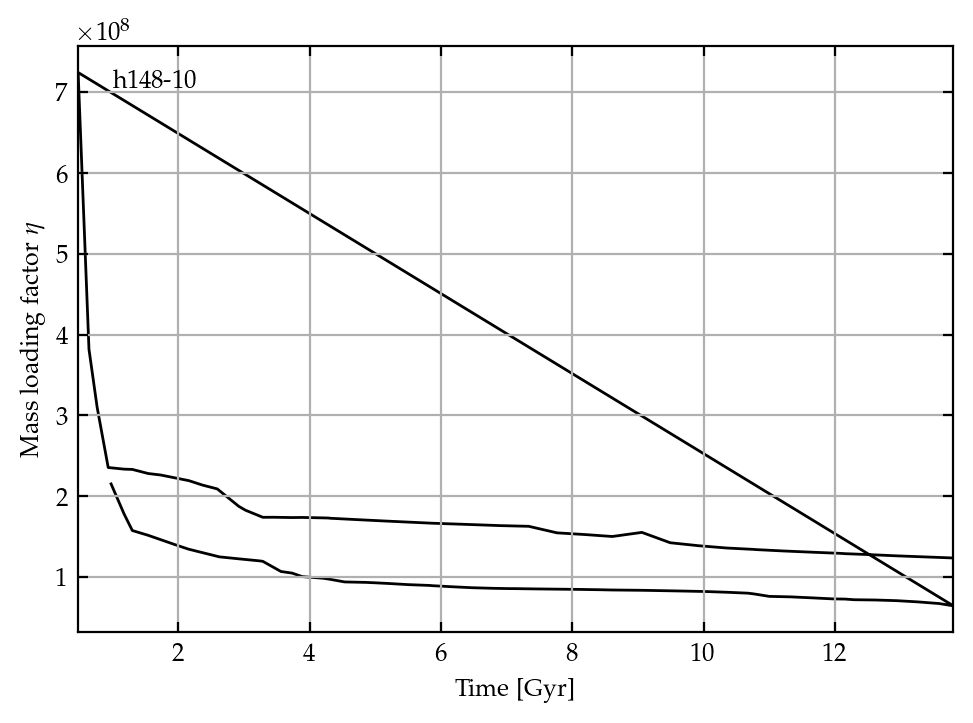

In [38]:
#plot mass loading factor for h148_10
target = satdata[satdata.z0haloid == 10]
x, y = target.time, target.eta
xmin, xmax = (target.time).min(), (target.time).max()

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4.75,3.5), constrained_layout=True)
ax.plot(x, y, 'k-', linewidth=1, alpha = 1, zorder=1)
#ax.axvline(x=1.0, linewidth=1, alpha = 0.5, zorder=0)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Mass loading factor $\eta$')
ax.annotate(f"{key.replace('_','-')}", (0.04, 0.96), xycoords='axes fraction', va='top')
ax.set_xlim(xmin,xmax)
ax.grid()
ax.tick_params(top=True,right=True,direction='in', which='both')
plt.show()

In [43]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

In [52]:
path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/predischarged_particles.hdf5'
predischarged = pd.read_hdf(path, key=key)

In [55]:
time_arr_prev = np.unique(predischarged.time)

In [61]:
np.sum(discharged['mass'])/1e9

9.513218547315947

> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_10 <
[7.99129708e+08 5.26777019e+08 2.21845736e+08 4.94381047e+08
 5.51546499e+08 5.26007823e+08 1.60661772e+08 5.14619678e+08
 5.19357608e+08 4.02941490e+08 2.99758843e+08 2.24490353e+08
 2.48089591e+08 2.29816222e+08 2.47002219e+08 3.01857091e+08
 1.49052057e+08 1.70871904e+08 2.21506681e+08 2.33398375e+08
 2.01492796e+08 1.64993642e+08 1.84201732e+08 2.98862434e+08
 8.02306066e+07 1.71365926e+08 2.40813783e+08 1.87125941e+08
 1.28255590e+08 1.34652898e+08 1.20532565e+08 1.21214609e+08
 8.89972939e+07 1.20057836e+08 1.12724404e+08 1.14584775e+08] [0.0927478  0.08429271 0.07720155 0.07720155 0.09059526 0.1715451
 0.1715451  0.16517483 0.10703209 0.04825795 0.04161625 0.04161625
 0.02598896 0.03201758 0.03185336 0.02678793 0.02863227 0.02863227
 0.02456668 0.02501342 0.02267434 0.02322299 0.0286548  0.03070102
 0.03070102 0.02735041 0.02535077 0.01647022 0.01414211 0.01196007
 0.01196007 0.00972316 0.0097768  

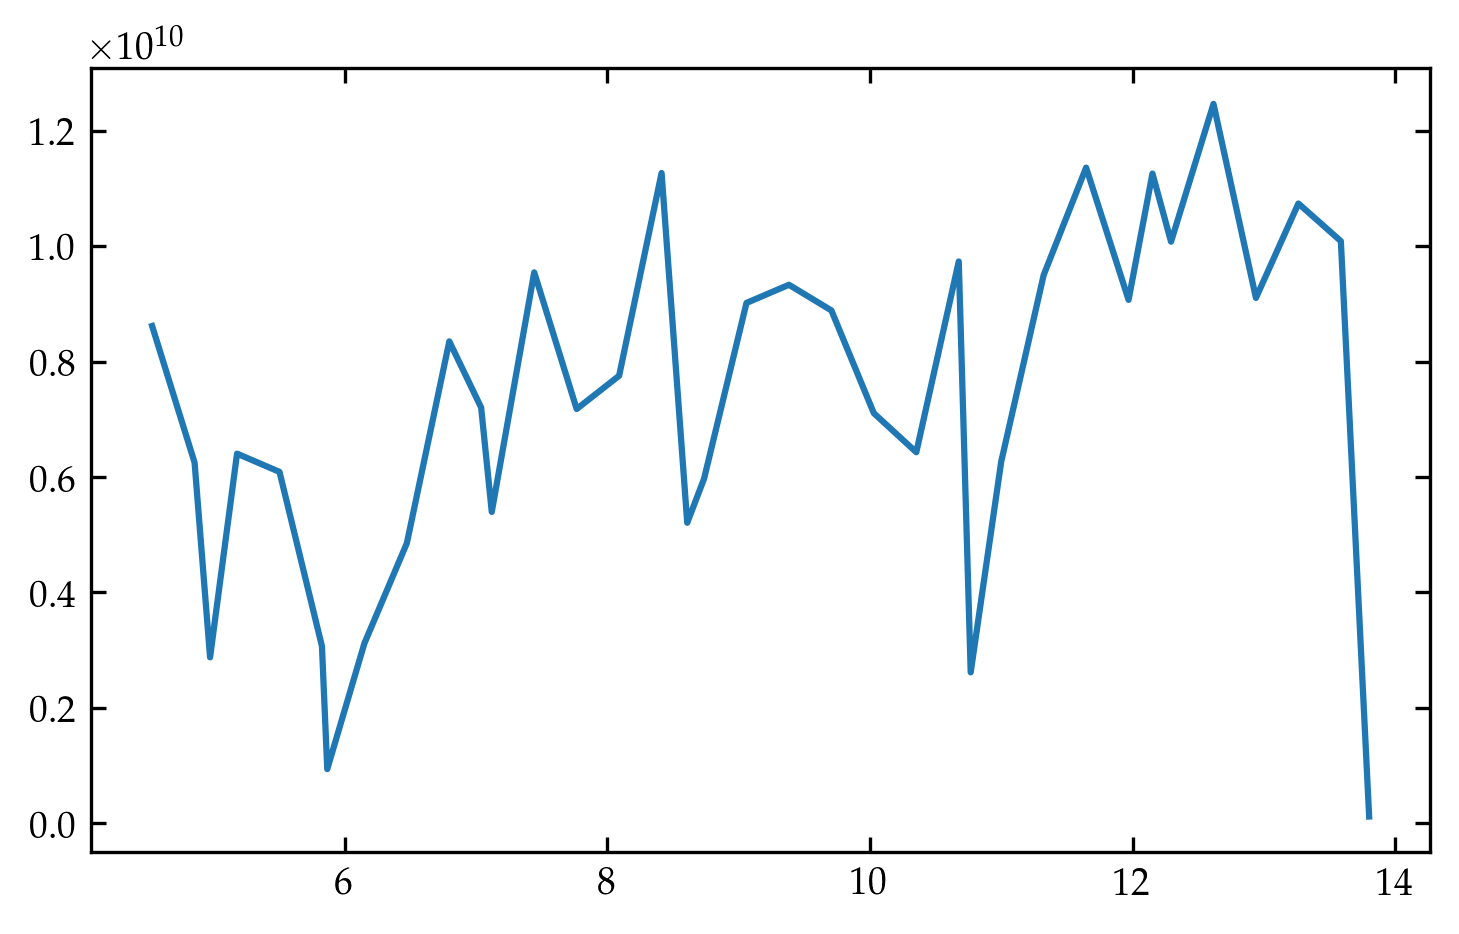

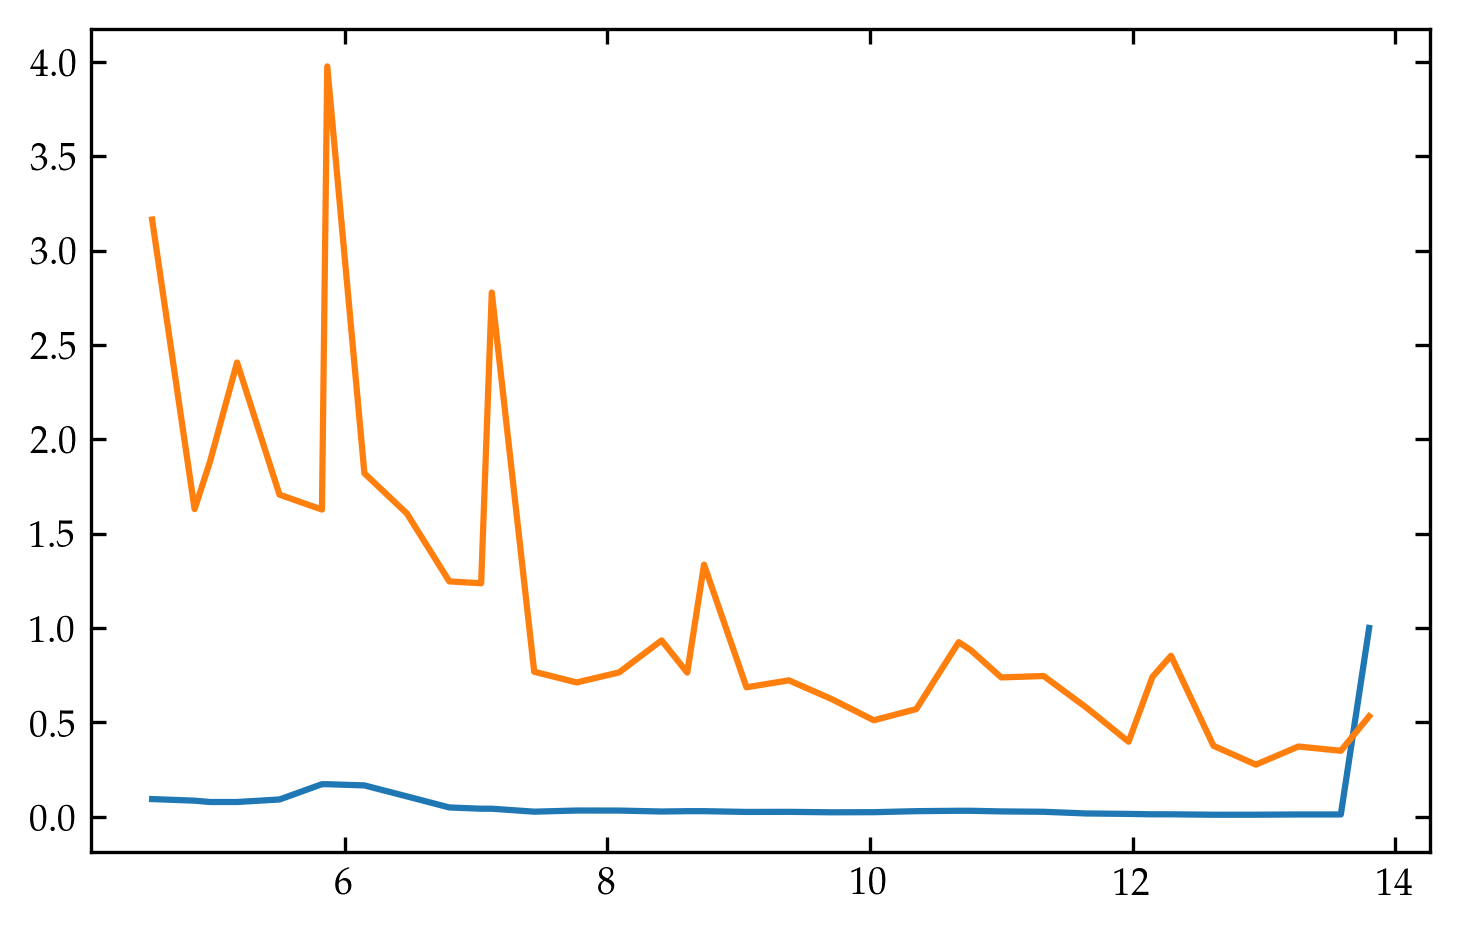

In [62]:
from math import isclose
#sum up discharged particles over time for one satellite
#while doing so, match up SFR to the same snapshot
time_arr3 = np.unique(discharged.time)
Mout_arr = np.array([])
Mout_rate_arr = np.array([])
key = 'h242_10'
sfr1, bins = calc_sfr(key)
bincenters = 0.5*(bins[1:] + bins[:-1])
sfrs = np.array([])
i = 0            
for time, time_prev in zip(time_arr3, time_arr_prev):
    #filter out
    filtered = discharged[discharged.time == time]
    #sum up mass exited at this timestep
    Mout = np.sum(filtered.mass)
    Mout_arr = np.append(Mout_arr, Mout)
    Mout_rate_arr = np.append(Mout_rate_arr, Mout/((time-time_prev)*1e9)) # [Msol/yr]
    
    #find sfr at time
    if isclose(bincenters[i], time, abs_tol=1e-2):
        sfr = sfr1[i]
    else:
        try:
            sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
        except:
            sfr = 1 #no close bincenters, skip this, 1 because deivision by 1 means nothing
    sfrs = np.append(sfrs, sfr)
    i+=1



[7.99129708e+08 5.26777019e+08 2.21845736e+08 4.94381047e+08
 5.51546499e+08 5.26007823e+08 1.60661772e+08 5.14619678e+08
 5.19357608e+08 4.02941490e+08 2.99758843e+08 2.24490353e+08
 2.48089591e+08 2.29816222e+08 2.47002219e+08 3.01857091e+08
 1.49052057e+08 1.70871904e+08 2.21506681e+08 2.33398375e+08
 2.01492796e+08 1.64993642e+08 1.84201732e+08 2.98862434e+08
 8.02306066e+07 1.71365926e+08 2.40813783e+08 1.87125941e+08
 1.28255590e+08 1.34652898e+08 1.20532565e+08 1.21214609e+08
 8.89972939e+07 1.20057836e+08 1.12724404e+08 1.14584775e+08] [0.0927478  0.08429271 0.07720155 0.07720155 0.09059526 0.1715451
 0.1715451  0.16517483 0.10703209 0.04825795 0.04161625 0.04161625
 0.02598896 0.03201758 0.03185336 0.02678793 0.02863227 0.02863227
 0.02456668 0.02501342 0.02267434 0.02322299 0.0286548  0.03070102
 0.03070102 0.02735041 0.02535077 0.01647022 0.01414211 0.01196007
 0.01196007 0.00972316 0.0097768  0.01117914 0.01117442 1.        ] [34.11967267 19.33383637 24.38425607 31.17873189

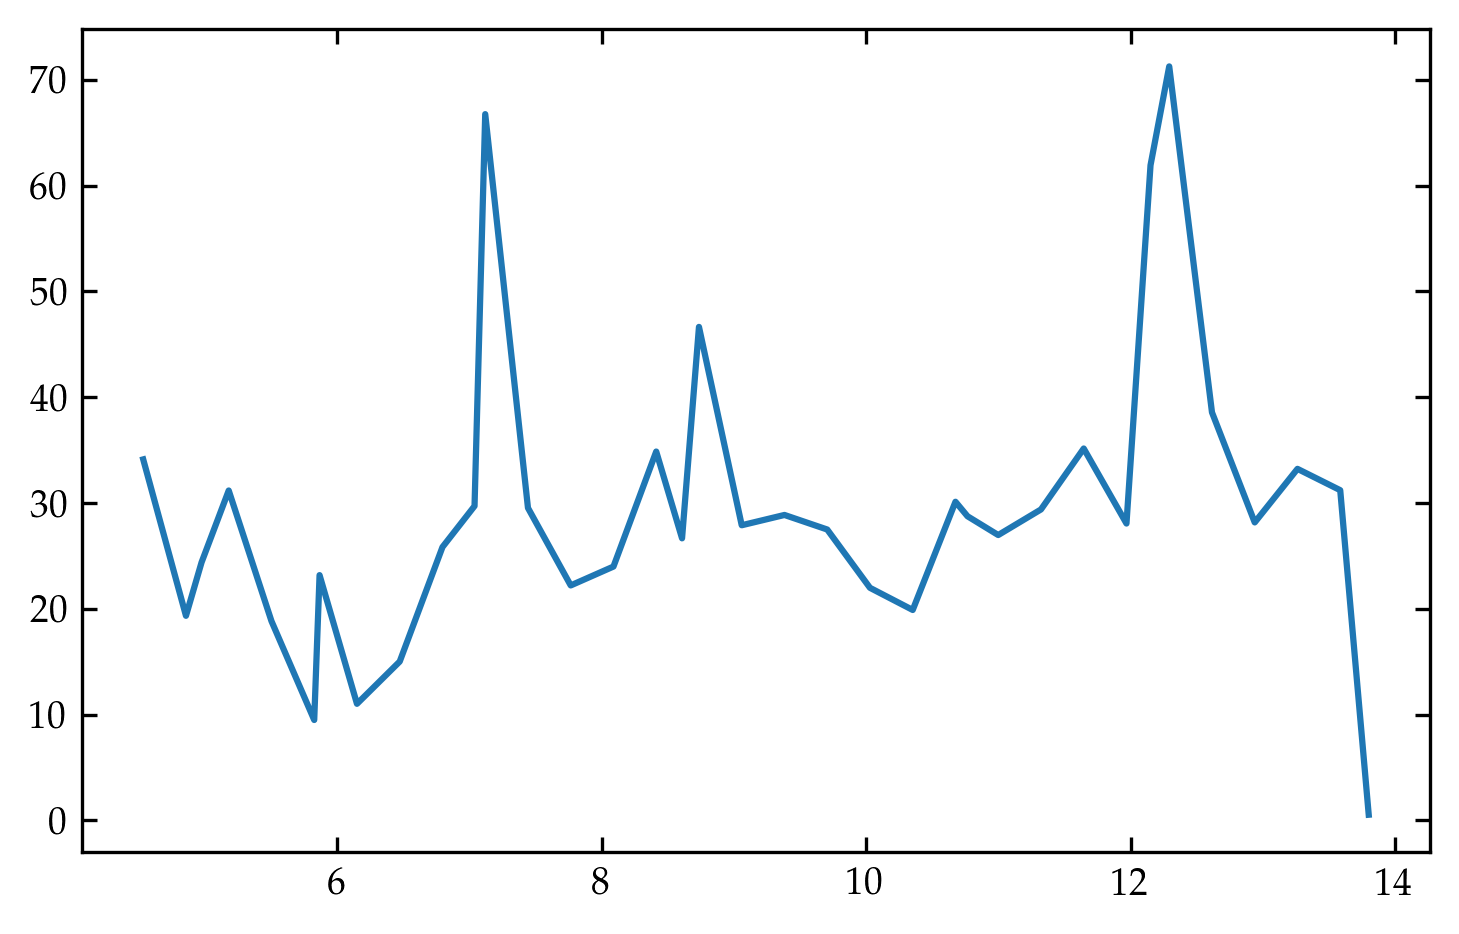

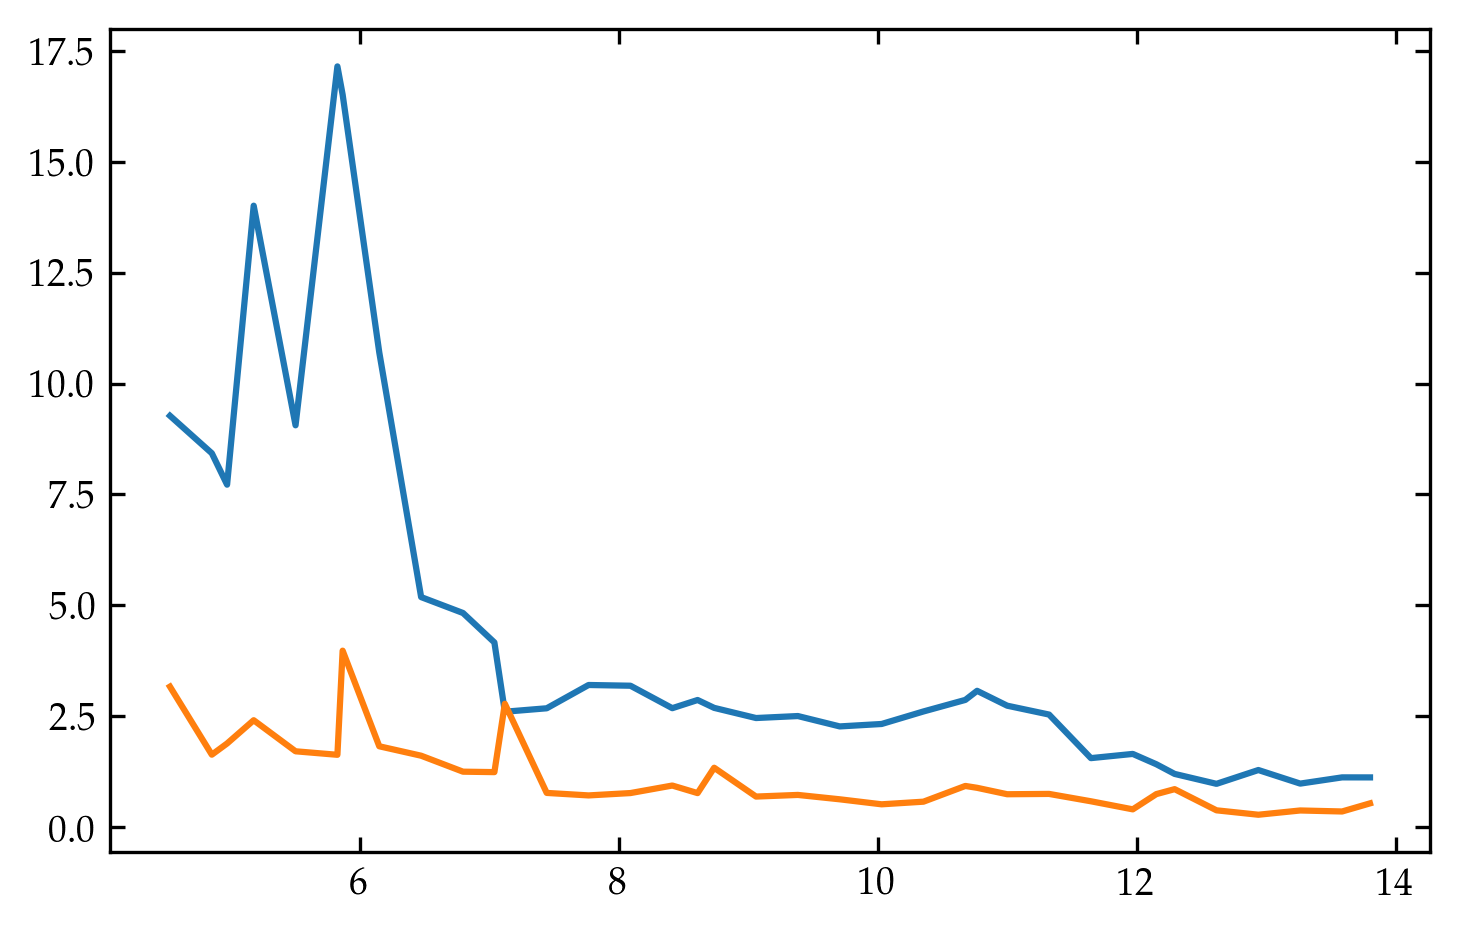

In [67]:
#mass loading factor, mass outflow/SFR
eta = Mout_rate_arr/sfrs # [unitless]

print(Mout_arr, sfrs, eta)

#plot mass outflow over time using discharged dataframe
fig, ax = plt.subplots(1,1, figsize = (4.75, 3), dpi = 300)
ax.plot(time_arr3, eta)

fig, ax1 = plt.subplots(1,1, figsize = (4.75, 3), dpi = 300)
ax1.plot(time_arr3, sfr1[1:]*100)
ax1.plot(time_arr3, Mout_rate_arr)

In [108]:
#a function to calculate the mass loading factor at each timestep
def calc_mlf(key):
    '''
    This function calculates mass loading factor (gas_outflow_rate/SFR) by 
    taking discharged dataframe and SFR calculation function
    '''
    
    #load discharged and predischarged particle dataframe here
    predischarged, discharged = read_one_discharged(key)
    
    #load accreted, reaccreted particle dataframe here
    accreted, reaccreted = read_one_accreted(key)
    
    #sum up discharged particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(discharged.time)
    time_arr_prev = np.unique(predischarged.time)
    Mout_arr,Mout_rate_arr,sfrs = np.array([]), np.array([]), np.array([])

    #calculate and load SFR data
    sfr1, bins = calc_sfr(key) #binned based on time
    bincenters = 0.5*(bins[1:] + bins[:-1])

    #iterate thru each timestep
    for i, (time, time_prev) in enumerate(zip(time_arr, time_arr_prev)):
        #filter out
        filtered = discharged[discharged.time == time]
        #sum up mass exited at this timestep
        Mout = np.sum(filtered.mass)
        Mout_arr = np.append(Mout_arr, Mout)
        Mout_rate_arr = np.append(Mout_rate_arr, Mout/((time-time_prev)*1e9)) # [Msol/yr]

        #find sfr at time
        if ~isclose(sfr1[i], 0, abs_tol = 1e-5):
            if isclose(bincenters[i], time, abs_tol=1e-2):
                sfr = sfr1[i]
            else:
                try:
                    sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
                except:
                    sfr = sfr1[-1] #no close bincenters, probably the last item
        else:
            sfr = 0.00001 #sfr is almost zero
        sfrs = np.append(sfrs, sfr)

    #mass loading factor, mass outflow/SFR
    eta = Mout_rate_arr/sfrs # [unitless]
    
    #to avoid error in calculation, remove NaN if any
    eta = eta[~np.isnan(eta)]
    
    return time_arr, eta

> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_10 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_21 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_30 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_38 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_401 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_69 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_8 <


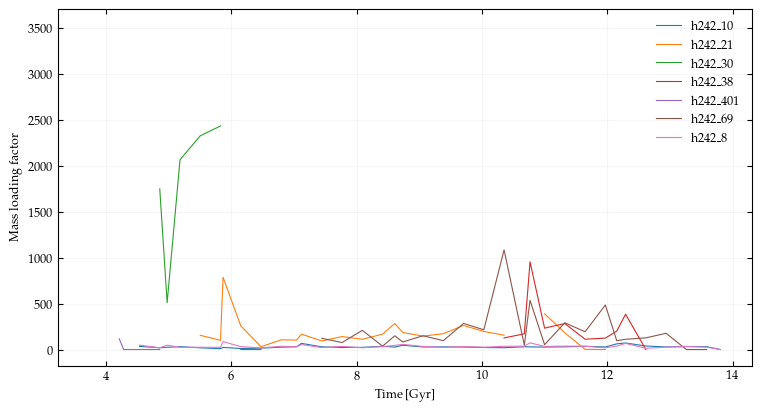

In [96]:
## plot mass loading factor and satellite trajectory
#load h242
keys = ['h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_401', 'h242_69', 'h242_8']

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(7.5,4))
for key in keys:
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    tmin, tmax = np.min(time), np.max(time)
    mlfmin, mlfmax = np.min(eta), np.max(eta)

    ax.plot(time, eta, linewidth = 0.8, label = key)
    
ax.grid(alpha = 0.1)

ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Mass loading factor')

ax.tick_params(top=True,right=True,direction='in', which='both')
plt.legend()
plt.savefig('plots/h242_massloadingfactor.pdf')
plt.show()

> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_10 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_12 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_249 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_251 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_27 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_282 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_3 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_34 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_38 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_4 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_55 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_6 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_65 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_14 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_18 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_20 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_22 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_49 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_10 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_21 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_38 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_69 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_8 <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h329_117 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h329_29 <


/tmp/ipykernel_33571/2843604447.py:38: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h329_7 <


/tmp/ipykernel_33571/1523668805.py:24: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('plots/all_massloadingfactor.pdf')
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


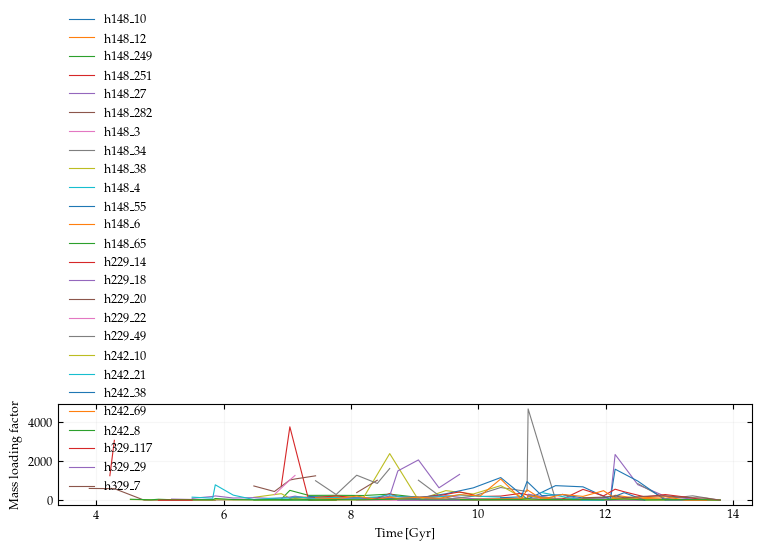

In [97]:
##plot mass loading factor for all
## plot mass loading factor and satellite trajectory
#load these keys (excluding h242_30)
keys = ['h148_10', 'h148_12', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(7.5,4))
for key in keys:
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    tmin, tmax = np.min(time), np.max(time)
    mlfmin, mlfmax = np.min(eta), np.max(eta)

    ax.plot(time, eta, linewidth = 0.8, label = key)
    
ax.grid(alpha = 0.1)

ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Mass loading factor')

ax.tick_params(top=True,right=True,direction='in', which='both')
plt.legend()
plt.savefig('plots/all_massloadingfactor.pdf')
plt.show()

## Quenching Timescales and Infalling
(some code starting from below might be borrowed from ```Hollis' QuenchingTimescales/SFR_Quenching_Times.ipynb``` and ```QuenchingTimescale.ipynb```)

In [76]:
#where is quenched time
picklepaths = {'h148': '../Justice_League_Code/Data/timesteps_data/h148.data', 
              'h229': '../Justice_League_Code/Data/timesteps_data/h229.data',
              'h242': '../Justice_League_Code/Data/timesteps_data/h242.data',
              'h329': '../Justice_League_Code/Data/timesteps_data/h329.data'}

In [86]:
#read .data file and find when it is quenched, infalled, then store the data into QuenchingTimescales.data file 
names = ['h148','h242','h229','h329']

q_thresh = 1e-11 # yr^(-1)
i_thresh = 1.03 # Rvir

age = 13.800797497330507

savepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/QuenchingTimescales.data'
with open(savepath,'wb') as f:
    for name in names:
        print(f'Simulation {name}')
        
        timesteps_all = read_timesteps(name)
        
        haloids = np.unique(np.array(timesteps_all.z0haloid, dtype=int)) # all the unique haloids we're interested in
        print('Found haloids (z=0): ', haloids)

        for haloid in haloids: # for each satellite
            timesteps = timesteps_all[np.array(timesteps_all.z0haloid,dtype=int)==haloid]
            
            # get the quenching time
            sfr, mstar, time = np.array(timesteps.sfr,dtype=float), np.array(timesteps.mstar,dtype=float), np.array(timesteps.time,dtype=float)
            sfr = sfr[np.argsort(time)]
            mstar = mstar[np.argsort(time)]
            time = np.sort(time)
            sSFR = sfr/mstar
            lbt = 13.8007 - time
            is_quenched = sSFR[-1] < q_thresh # boolean expression to determine whether the satellite is quenched
            if is_quenched:
                # then the halo is quenched, so we calculate the quenching time
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 1e-11:
                        print(f'\t Halo {haloid}, Quenched (sSFR = {s}) {t} Gyr ago', end='  ')
                        tq = t
                        break
                    else:
                        continue
                        
                # lower limit on quenching time (same thing, but with 2e-11 as the threshold)
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 2e-11:
                        tq_lower = t
                        break
                    else:
                        continue
                        
                # upper limit on quenching timem (same thing, but with 0 as the threshold)
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 0:
                        tq_upper = t
                        break
                    else:
                        continue     
            else:
                print(f'\t Halo {haloid}, Unquenched at z = 0', end='  ')
                tq = None
                tq_lower = None
                tq_upper = None
                
            
            # get the infall time
            dist = np.array(timesteps.h1dist, dtype=float) # in Rvir
            time = age - np.array(timesteps.time, dtype=float) # in Gyr ago

            try:
                ti = np.max(time[dist <= i_thresh]) # maximum lookback time at which sat is < 1 Rvir from host (max LBT = earliest time)
                print(f'\t Halo {haloid}, infall {ti} Gyr ago')
            except ValueError:
                print(f'\t Halo {haloid}, never infell')
                ti = None
                
            try:
                ti_lower = np.max(time[dist <= 1.1])
            except ValueError:
                ti_lower = None
                
            try:
                ti_upper = np.max(time[dist <= 0.9])
            except ValueError:
                ti_upper = None
                
            z0mstar = mstar[-1] # for reference

            pickle.dump({
                'haloid':haloid,
                'quenched':is_quenched,
                'tquench':tq,
                'tquench_lower': tq_lower,
                'tquench_upper': tq_upper,
                'tinfall':ti,
                'tinfall_lower': ti_lower,
                'tinfall_upper': ti_upper,
                'M_star': z0mstar,
                #'n_star': z0nstar,
                'sim':name                
            }, f, protocol=2)

Simulation h148
Found haloids (z=0):  [  2   3   4   6   7  10  11  12  13  15  20  23  27  28  29  33  34  37
  38  41  43  51  52  55  59  65  75  86  94 109 114 122 128 148 188 230
 249 251 282 327 336 341 358 438 447 557 603 699 801 910 925]
	 Halo 2, Unquenched at z = 0  	 Halo 2, infall 0.8619607610705877 Gyr ago
	 Halo 3, Unquenched at z = 0  	 Halo 3, infall 3.8788234239714097 Gyr ago
	 Halo 4, Unquenched at z = 0  	 Halo 4, infall 1.7239215218961164 Gyr ago
	 Halo 6, Unquenched at z = 0  	 Halo 6, infall 2.154901902310389 Gyr ago
	 Halo 7, Unquenched at z = 0  	 Halo 7, infall 4.309803804384165 Gyr ago
	 Halo 10, Unquenched at z = 0  	 Halo 10, infall 5.602744945621538 Gyr ago
	 Halo 11, Unquenched at z = 0  	 Halo 11, never infell
	 Halo 12, Quenched (sSFR = 1.7150284388071186e-11) 4.740686687466409 Gyr ago  	 Halo 12, infall 5.602744945621538 Gyr ago
	 Halo 13, Unquenched at z = 0  	 Halo 13, never infell
	 Halo 15, Unquenched at z = 0  	 Halo 15, never infell
	 Halo 20, Unq

/tmp/ipykernel_33571/429447572.py:27: RuntimeWarning: invalid value encountered in divide
  sSFR = sfr/mstar


Found haloids (z=0):  [  8  10  21  26  30  34  38  42  44  45  63  69  70  81 138 192 401 421]
	 Halo 8, Unquenched at z = 0  	 Halo 8, infall 8.29637232310752 Gyr ago
	 Halo 10, Unquenched at z = 0  	 Halo 10, infall 7.9731370377979385 Gyr ago
	 Halo 21, Quenched (sSFR = 1.092664517652161e-11) 3.033600336830606 Gyr ago  	 Halo 21, infall 4.740784184702266 Gyr ago
	 Halo 26, Quenched (sSFR = 2.225614045810879e-11) 11.178456119940604 Gyr ago  	 Halo 26, infall 8.619607608417425 Gyr ago
	 Halo 30, Quenched (sSFR = 6.534320436518992e-11) 7.932635129803739 Gyr ago  	 Halo 30, infall 8.619607608417425 Gyr ago
	 Halo 34, Quenched (sSFR = 5.7818789491751015e-11) 9.912451252402938 Gyr ago  	 Halo 34, never infell
	 Halo 38, Quenched (sSFR = 3.871938086303124e-11) 1.5083338342760833 Gyr ago  	 Halo 38, infall 2.1549019022257117 Gyr ago
	 Halo 42, Quenched (sSFR = 2.999246381995267e-10) 12.175098249732693 Gyr ago  	 Halo 42, never infell
	 Halo 44, Quenched (sSFR = 5.881279568502675e-10) 11.646

/tmp/ipykernel_33571/429447572.py:27: RuntimeWarning: invalid value encountered in divide
  sSFR = sfr/mstar


Found haloids (z=0):  [  2   3   6  14  15  18  20  22  25  33  47  48  49  52  57  62  64  89
  92 127 193 253]
	 Halo 2, Unquenched at z = 0  	 Halo 2, never infell
	 Halo 3, Quenched (sSFR = 1.23617786170348e-11) 1.185098549121486 Gyr ago  	 Halo 3, never infell
	 Halo 6, Unquenched at z = 0  	 Halo 6, never infell
	 Halo 14, Quenched (sSFR = 1.9728809463055675e-11) 0.21539269319277743 Gyr ago  	 Halo 14, infall 5.064019470166848 Gyr ago
	 Halo 15, never infell
	 Halo 18, Quenched (sSFR = 1.3637517845396736e-11) 5.7103925434547005 Gyr ago  	 Halo 18, infall 6.033725326095038 Gyr ago
	 Halo 20, Quenched (sSFR = 7.622931896888703e-11) 5.063921972836342 Gyr ago  	 Halo 20, infall 6.033725326095038 Gyr ago
	 Halo 22, Quenched (sSFR = 1.3608047853726834e-11) 6.033627828764532 Gyr ago  	 Halo 22, infall 6.35696061140479 Gyr ago
	 Halo 25, never infell
	 Halo 33, infall 2.1549019023807237 Gyr ago
	 Halo 47, infall 6.761004718041906 Gyr ago
	 Halo 48, infall 7.326666467333765 Gyr ago
	 Halo

/tmp/ipykernel_33571/429447572.py:27: RuntimeWarning: invalid value encountered in divide
  sSFR = sfr/mstar


In [123]:
q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == 'h148')]
q_data_read

haloid  quenched    tquench  tquench_lower  tquench_upper       tinfall  \
0        2     False        NaN            NaN            NaN  8.619608e-01   
1        3     False        NaN            NaN            NaN  3.878823e+00   
2        4     False        NaN            NaN            NaN  1.723922e+00   
3        6     False        NaN            NaN            NaN  2.154902e+00   
4        7     False        NaN            NaN            NaN  4.309804e+00   
5       10     False        NaN            NaN            NaN  5.602745e+00   
7       12      True   4.740687       5.191869      -0.000097  5.602745e+00   
11      23     False        NaN            NaN            NaN  7.326666e+00   
12      27      True   1.649749       1.649749      -0.000097  7.326666e+00   
13      28      True   0.430883       0.430883       0.430883  2.450751e-10   
15      33      True   5.191869       5.602647       5.191869  3.033698e+00   
16      34      True   0.430883       0.430883       0.430883  4.740784e+00   
18      38      True   4.309706       4.309706       4.309706  6.033725e+00   
19      41      True   3.016765       3.016765       3.016765  1.292941e+00   
20      43      True   3.016765       3.016765       3.016765  2.450751e-10   
22      52      True   6.033628       6.033628       6.033628  4.740784e+00   
23      55      True   1.649749       1.649749       1.649749  5.191967e+00   
24      59      True  12.865340      12.865340      12.865340  2.585882e+00   
25      65      True   7.932635       8.619510       7.932635  7.326666e+00   
26      75      True  13.158272      13.158272      13.158272  2.450751e-10   
27      86      True   4.740687       4.740687       4.740687  4.309804e+00   
29     109      True  12.067353      12.067353      12.067353  5.191967e+00   
30     114      True   9.481471       9.481471       9.481471  3.447843e+00   
32     128      True   2.585785       2.585785       2.585785  2.585882e+00   
33     148      True   9.912451       9.912451       9.912451  9.050588e+00   
34     188      True  11.430984      11.430984      11.430984  7.932733e+00   
35     230      True  10.875423      10.875423      10.875423  6.895686e+00   
36     249      True   3.878726       3.878726       3.878726  5.602745e+00   
37     251      True   6.464608       6.464608       6.464608  6.895686e+00   
38     282      True  10.067335      10.067335      10.067335  9.481568e+00   
39     327      True  12.865340      12.865340      12.865340  8.619608e-01   
40     336      True  11.430984      11.430984      11.430984  9.050588e+00   
41     341      True  10.774412      10.774412      10.774412  8.619608e+00   
42     358      True  10.774412      10.774412      10.774412  1.723922e+00   
43     438      True  12.865340      12.865340      12.865340  9.050588e+00   
44     447      True  12.067353      12.067353      12.067353  1.723922e+00   
45     557      True  13.033692      13.033692      13.033692  5.602745e+00   
46     603      True  13.158272      13.158272      13.158272  7.932733e+00   
47     699      True  12.067353      12.067353      12.067353  5.191967e+00   
48     801      True  13.033692      13.033692      13.033692  9.050588e+00   
49     910      True  13.158272      13.158272      13.158272  7.932733e+00   
50     925      True  13.158272      13.158272      13.158272  1.723922e+00   

    tinfall_lower  tinfall_upper        M_star   sim  
0    1.292941e+00       0.861961  2.268773e+09  h148  
1    4.309804e+00       3.878823  1.502171e+09  h148  
2    1.723922e+00       1.292941  4.317847e+08  h148  
3    2.154902e+00       1.723922  3.315968e+08  h148  
4    4.309804e+00       3.878823  2.359537e+08  h148  
5    5.602745e+00       5.602745  1.353274e+08  h148  
7    5.602745e+00       5.602745  1.043767e+08  h148  
11   7.326666e+00       7.326666  1.004013e+08  h148  
12   7.326666e+00       7.326666  8.415728e+07  h148  
13   4.309804e-01            NaN  3.171186e+06  h148  
1

In [11]:
#calculate the relative distance from the host to the satellite for each timestep
#code is borrowed fro StellarFeedbackAnalysis.ipynb from Leo's
def calc_r_rel(key):
    #read tracked particle dataframe
    sim = str(key[:4])
    haloid = int(key[5:])
    
    data = read_tracked_particles(sim, haloid)
    x_rels, y_rels, z_rels, r_rels, ts = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    for t in np.unique(data.time):
        d = data[data.time==t] # find the satellite data at time t
    
        sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
        host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)

        h1Rvir = np.mean(d.hostRvir)
        satRvir = np.mean(d.satRvir)
        
        #calculate the relative distance from host
        x_rel = (sat_x-host_x)/h1Rvir
        y_rel = (sat_y-host_y)/h1Rvir
        z_rel = (sat_z-host_z)/h1Rvir
        
        #save data
        x_rels = np.append(x_rels, x_rel)
        y_rels = np.append(y_rels, y_rel)
        z_rels = np.append(z_rels, z_rel)
        r_rels = np.append(r_rels, np.sqrt(x_rel**2 + y_rel**2 + z_rel**2))
        ts = np.append(ts,t)
    
    return r_rels, ts

In [140]:
#make a colormap based on stellar mass size
import matplotlib as mpl
cmap = mpl.colormaps['viridis']

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_3 <
Approximately calculated mlf_infall_now for h148_3
h148_3 started infalling at 9.92197357602859, before is 19.73923842867162, now is 17.02284406087089, and after is 109.64050095634676
Could not calculate mlf_quench for h148_3
h148_3 is at closest to the host at 10.35295445377185, and mass loading factor is 12.879327528721074
> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_4 <
Approximately calculated mlf_infall_now for h148_4
h148_4 started infalling at 12.076875478103883, before is 226.27647078249203, now is 25.289586474285382, and after is 22.31755637483363
Could not calculate mlf_quench for h148_4
h148_4 is at closest to the host at 12.938836736259919, and mass loading factor is 22.31755637483363
> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr)

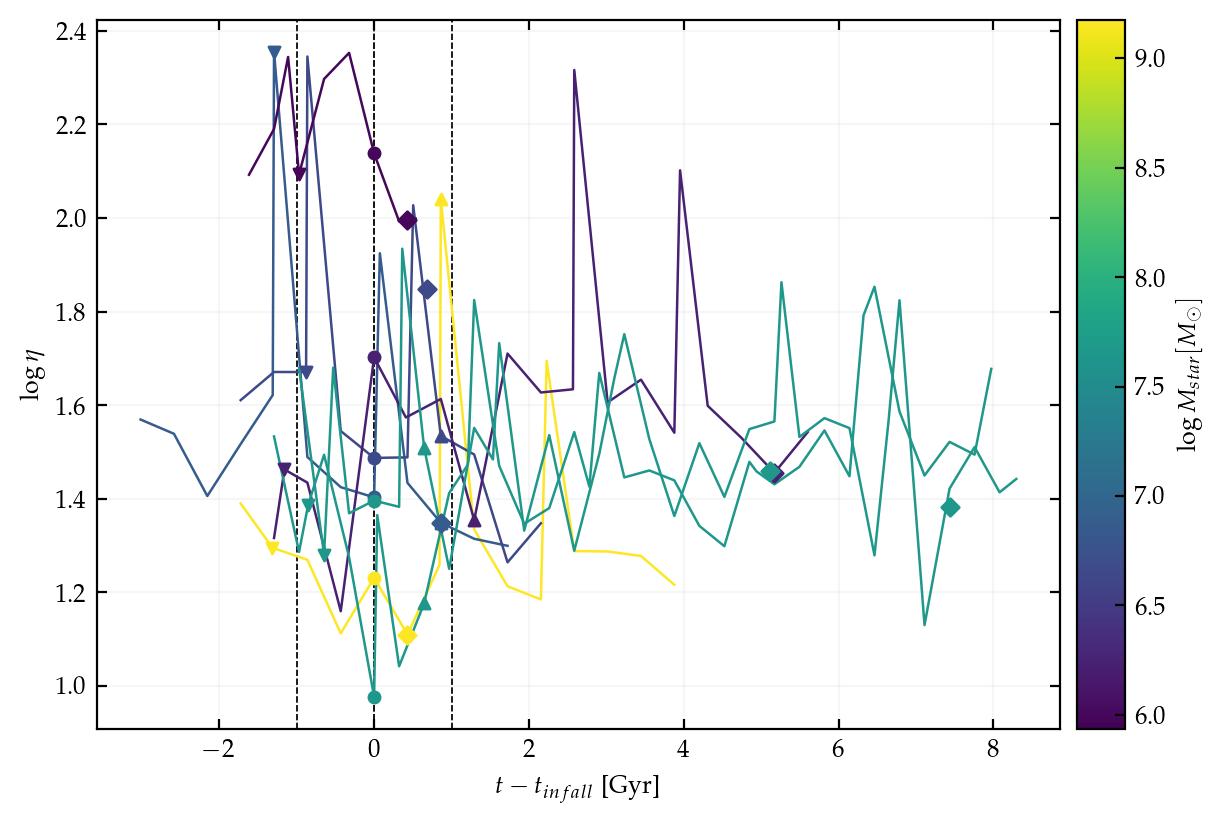

### Average MLF ###
For massive galaxies, avg MLF before infall (within 1 Gyr) is 67.64330504856412, after infall (within 1 Gyr) is 48.83212877088967, at around pericentric distance is 48.59577863127259, and during tinfall to tquench is 49.642626688538364.
For intermediate galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, at around pericentric distance is nan, and during tinfall to tquench is nan.
For small galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, at around pericentric distance is nan, and during tinfall to tquench is nan.
And for all galaxies, avg MLF before infall (within 1 Gyr) is 67.64330504856412, after infall (within 1 Gyr) is 48.83212877088967, at around pericentric distance is 48.59577863127259, and during tinfall to tquench is 49.642626688538364.


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [198]:
#read infalling time, quenching time, and time at pericentric distance from the host for all the sim data, 
#then plot mass loading factor based on how much time after infall started
#color is based on mass size
#also calculate averaged MLF for 1 Gyr before, after infall, around at pericentric distance and during tinfall to tquench

#load sim, only star-forming ones
keys = ['h148_3', 'h148_4', 'h148_6', 'h148_10', 'h242_8', 'h242_10', 'h329_7']

#avg mlf array initializations
mlf_l_infall_before_arr, mlf_l_infall_after_arr, mlf_l_pericenter_arr, mlf_l_infall_to_quench_arr = np.array([]),np.array([]),np.array([]),np.array([])
mlf_m_infall_before_arr, mlf_m_infall_after_arr, mlf_m_pericenter_arr, mlf_m_infall_to_quench_arr = np.array([]),np.array([]),np.array([]),np.array([])
mlf_s_infall_before_arr, mlf_s_infall_after_arr, mlf_s_pericenter_arr, mlf_s_infall_to_quench_arr = np.array([]),np.array([]),np.array([]),np.array([])
mlf_t_infall_before_arr, mlf_t_infall_after_arr, mlf_t_pericenter_arr, mlf_t_infall_to_quench_arr = np.array([]),np.array([]),np.array([]),np.array([])

fig = plt.figure(dpi=200, figsize=(6,4))
gs = mpl.gridspec.GridSpec(1,2, width_ratios = [1,0.05], figure=fig)
ax = plt.subplot(gs[:,0])
cbax = plt.subplot(gs[:,1])

for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #read infall time
    q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
    #skip plotting if it hasn't infalled or could not found
    if q_data_read.empty:
        print(f'Couldnt find the infall time for {key}')
        continue
    
    #read m_star, which decides the color of the plot and category for calculating avg mlf
    mstar = q_data_read.M_star
    c = cmap(mstar/(1.502171*10**9-8.610682*10**5))
    
    if float(mstar) > 10**8:
        is_massive = True
        #print(f'{key} is identified as massive in mass')
    elif float(mstar) > 10**7:
        is_intermediate = True
        #print(f'{key} is identified as intermediate in mass')
    else:
        is_small = True
        #print(f'{key} is identified as small in mass')
    
    #measure the relative distance from the host, then find the time at minimum ("pericentric time")
    r_rel,r_time = calc_r_rel(key)
    p_rel,p_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     
    
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    
    #time after infall
    tafterinfall = time - (13.800797 - float(q_data_read.tinfall))
    
    if ~np.isnan(float(q_data_read.tinfall)):
        #checking if any data after infall, then mark a dot for MLF at that time
        try:
            mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
            ax.scatter(0, np.log10(mlf_infall_now), c = c, s = 16, zorder = 3)
            print(f'Approximately calculated mlf_infall_now for {key}')
        except:
            mlf_infall_now = eta[-1] #infalled very recently, take the last step
        
        #then calculate mlf 1 Gyr before and after, do approximation if necessary, mark a dot for MLF at that time
        try:
            mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]+3], np.log10(mlf_infall_after), c = c, marker = "^", s = 16, zorder = 3)
            #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
            
        except:
            mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
            print(f'Approximately calculated mlf_infall_after for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
        
        try:
            mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]-3], np.log10(mlf_infall_before), c = c, marker = "v", s = 16, zorder = 3)
            #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
    
        except:
            mlf_infall_before = eta[0] #infall started when discharged particle tracking started
            print(f'Approximately calculated mlf_infall_before for {key}')
            eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
            
        print(f'{key} started infalling at {(13.800797 - float(q_data_read.tinfall))}, before is {mlf_infall_before}, now is {mlf_infall_now}, and after is {mlf_infall_after}')
    
    else:
        print(f'Could not calculate mlf_infall for {key}')
    
    #find mlf before quench, then dot plot around tquench
    #for star-forming galaxies, this process is skipped
    if ~np.isnan(float(q_data_read.tquench)):
        #read time quenched after infall
        tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))
        
        #checking if any data after quench
        try:
            mlf_quench_now = eta[np.where(tafterinfall > tquenchafterinfall)[0][0]]
            ax.scatter(tafterinfall[np.where(tafterinfall > tquenchafterinfall)[0][0]], np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            #append avg value between tinfall and tquench
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        except:
            mlf_quench_now = eta[-1] #quenched very recently, take the last item
            print(f'approximately calculated mlf_quench_now for {key}')
            #skip plotting if quenched earlier than infall
            if tquenchafterinfall > 0:
                ax.scatter(tquenchafterinfall, np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        print(f'{key} is quenched at {(13.800797 - float(q_data_read.tquench))}, mass loading factor now is {mlf_quench_now}')
        
    else:
        print(f'Could not calculate mlf_quench for {key}')
        #append avg value between iinfall to last item
        eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        if is_massive:
            mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
        else:
            mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
        mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))

    #find mlf around pericentric time
    tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time, then dot plot mlf
    try:
        mlf_pericenter = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)] #can be multiple
        mlf_pericenter_now = np.mean(mlf_pericenter[np.isfinite(mlf_pericenter)])
        t_pericenter = tafterinfall[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)]
        t_pericenter_now = np.mean(t_pericenter[np.isfinite(mlf_pericenter)])
        ax.scatter(t_pericenter_now, np.log10(mlf_pericenter_now), c = c, marker = "D", s = 20, zorder = 3)
        #append avg value around tpericenter, around 1 Gyr
        eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 1.0)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        if is_massive:
            mlf_l_pericenter_arr = np.append(mlf_l_pericenter_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_pericenter_arr = np.append(mlf_m_pericenter_arr, np.mean(eta_inrange))
        else:
            mlf_s_pericenter_arr = np.append(mlf_s_pericenter_arr, np.mean(eta_inrange))
        mlf_t_pericenter_arr = np.append(mlf_t_pericenter_arr, np.mean(eta_inrange))

    except:
        print(f'Could not calculate mlf_pericenter_now for {key}')
        mlf_pericenter_now = np.nan
        
    print(f'{key} is at closest to the host at {p_time}, and mass loading factor is {mlf_pericenter_now}')

    #any MLF above 1000 will be 1000 when plotting
    if any(eta > np.full(len(eta), 1000)):
        eta[eta > 1000] = 1000

    ax.plot(tafterinfall, np.log10(eta), c = c, label = key, lw = 0.9, zorder = 2)
    #draw a line at infall, 1 Gyr before and after
    ax.axvline(x = 0, color = 'black', ls = '--', lw = 0.6, alpha = 0.5, zorder = 1)
    ax.axvline(x = -1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)
    ax.axvline(x = 1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)

    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='vertical',
                                norm = mpl.colors.Normalize(vmin=np.log10(8.610682*10**5), vmax=np.log10(1.502171*10**9)),
                                label='$\log M_{star} [M_\odot]$')
    
ax.grid(alpha = 0.1)

ax.set_xlabel('$t - t_{infall}$ [Gyr]')
ax.set_ylabel('$\log \eta$')

ax.tick_params(top=True,right=True,direction='in', which='both')
#plt.legend()
plt.savefig('plots/starforming_massloadingfactor_after_infall.pdf')
plt.show()

#make sure to cut NaN
mlf_l_infall_before_arr, mlf_l_infall_after_arr, mlf_l_pericenter_arr, mlf_l_infall_to_quench_arr = mlf_l_infall_before_arr[np.isfinite(mlf_l_infall_before_arr)], mlf_l_infall_after_arr[np.isfinite(mlf_l_infall_after_arr)], mlf_l_pericenter_arr[np.isfinite(mlf_l_pericenter_arr)], mlf_l_infall_to_quench_arr[np.isfinite(mlf_l_infall_to_quench_arr)] 
mlf_m_infall_before_arr, mlf_m_infall_after_arr, mlf_m_pericenter_arr, mlf_m_infall_to_quench_arr = mlf_m_infall_before_arr[np.isfinite(mlf_m_infall_before_arr)], mlf_m_infall_after_arr[np.isfinite(mlf_m_infall_after_arr)], mlf_m_pericenter_arr[np.isfinite(mlf_m_pericenter_arr)], mlf_m_infall_to_quench_arr[np.isfinite(mlf_m_infall_to_quench_arr)] 
mlf_s_infall_before_arr, mlf_s_infall_after_arr, mlf_s_pericenter_arr, mlf_s_infall_to_quench_arr = mlf_s_infall_before_arr[np.isfinite(mlf_s_infall_before_arr)], mlf_s_infall_after_arr[np.isfinite(mlf_s_infall_after_arr)], mlf_s_pericenter_arr[np.isfinite(mlf_s_pericenter_arr)], mlf_s_infall_to_quench_arr[np.isfinite(mlf_s_infall_to_quench_arr)] 
mlf_t_infall_before_arr, mlf_t_infall_after_arr, mlf_t_pericenter_arr, mlf_t_infall_to_quench_arr = mlf_t_infall_before_arr[np.isfinite(mlf_t_infall_before_arr)], mlf_t_infall_after_arr[np.isfinite(mlf_t_infall_after_arr)], mlf_t_pericenter_arr[np.isfinite(mlf_t_pericenter_arr)], mlf_t_infall_to_quench_arr[np.isfinite(mlf_t_infall_to_quench_arr)] 

print("### Average MLF ###")
print(f'For massive galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_l_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_l_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_l_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_l_infall_to_quench_arr)}.')
print(f'For intermediate galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_m_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_m_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_m_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_m_infall_to_quench_arr)}.')
print(f'For small galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_s_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_s_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_s_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_s_infall_to_quench_arr)}.')
print(f'And for all galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_t_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_t_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_t_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_t_infall_to_quench_arr)}.')

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_12 <
Approximately calculated mlf_infall_now for h148_12
h148_12 started infalling at 8.198052054378461, before is 36.72121236774337, now is 23.736987422163182, and after is 70.0764794570041
h148_12 is quenched at 9.06011031253359, mass loading factor now is 70.0764794570041
h148_12 is at closest to the host at 8.608830726788982, and mass loading factor is 51.95159021272311


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_249 <
Approximately calculated mlf_infall_now for h148_249
h148_249 started infalling at 8.198052054378461, before is 502.82714387495656, now is 238.2722809869394, and after is inf
h148_249 is quenched at 9.922071073359096, mass loading factor now is 117.05266663399499
h148_249 is at closest to the host at 12.507856355847158, and mass loading factor is nan


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_251 <
Approximately calculated mlf_infall_now for h148_251
h148_251 started infalling at 6.905110913139425, before is 321.4520985444385, now is 732.4278237047572, and after is 321.4520985444385
h148_251 is quenched at 7.336188790882828, mass loading factor now is 321.4520985444385
h148_251 is at closest to the host at 11.21491521460295, and mass loading factor is nan


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_27 <
Approximately calculated mlf_infall_now for h148_27
h148_27 started infalling at 6.474130532726583, before is 37.21419576173272, now is 28.587242898520273, and after is 52.89659456775082
h148_27 is quenched at 12.151047728317822, mass loading factor now is 793.1345590109327
h148_27 is at closest to the host at 11.645895595020118, and mass loading factor is 35.35383297991278


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_282 <
Approximately calculated mlf_infall_now for h148_282
Approximately calculated mlf_infall_after for h148_282
h148_282 started infalling at 4.31922863065561, before is 42.971777299904865, now is 487.89017943071286, and after is 42.971777299904865
h148_282 is quenched at 3.733462173362488, mass loading factor now is 600.2718612411768
h148_282 is at closest to the host at 9.490993692946342, and mass loading factor is nan


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_34 <
Approximately calculated mlf_infall_now for h148_34
h148_34 started infalling at 9.060012815203084, before is 232.98757440742713, now is 150.94322390855524, and after is 648.5560967940627
h148_34 is quenched at 13.369914116672671, mass loading factor now is 232.98757440742713
h148_34 is at closest to the host at 9.921974073359097, and mass loading factor is 204.33796334842157


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_38 <
Approximately calculated mlf_infall_now for h148_38
h148_38 started infalling at 7.7670716739653205, before is 333.3504034046401, now is 185.569333404424, and after is 12.76559352873581
h148_38 is quenched at 9.49109069294634, mass loading factor now is 314.68396059960463
h148_38 is at closest to the host at 12.507856355847158, and mass loading factor is 219.4112767420645
> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_55 <
Approximately calculated mlf_infall_now for h148_55
h148_55 started infalling at 8.608830229458475, before is 191.26338482927932, now is 58.72637487070775, and after is 630.1263811274339
h148_55 is quenched at 12.151047728317822, mass loading factor now is 976.8761390517783
h148_55 is at closest to the host at 13.800797497085433, and mass loading factor is 158.73723347197716
>

/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


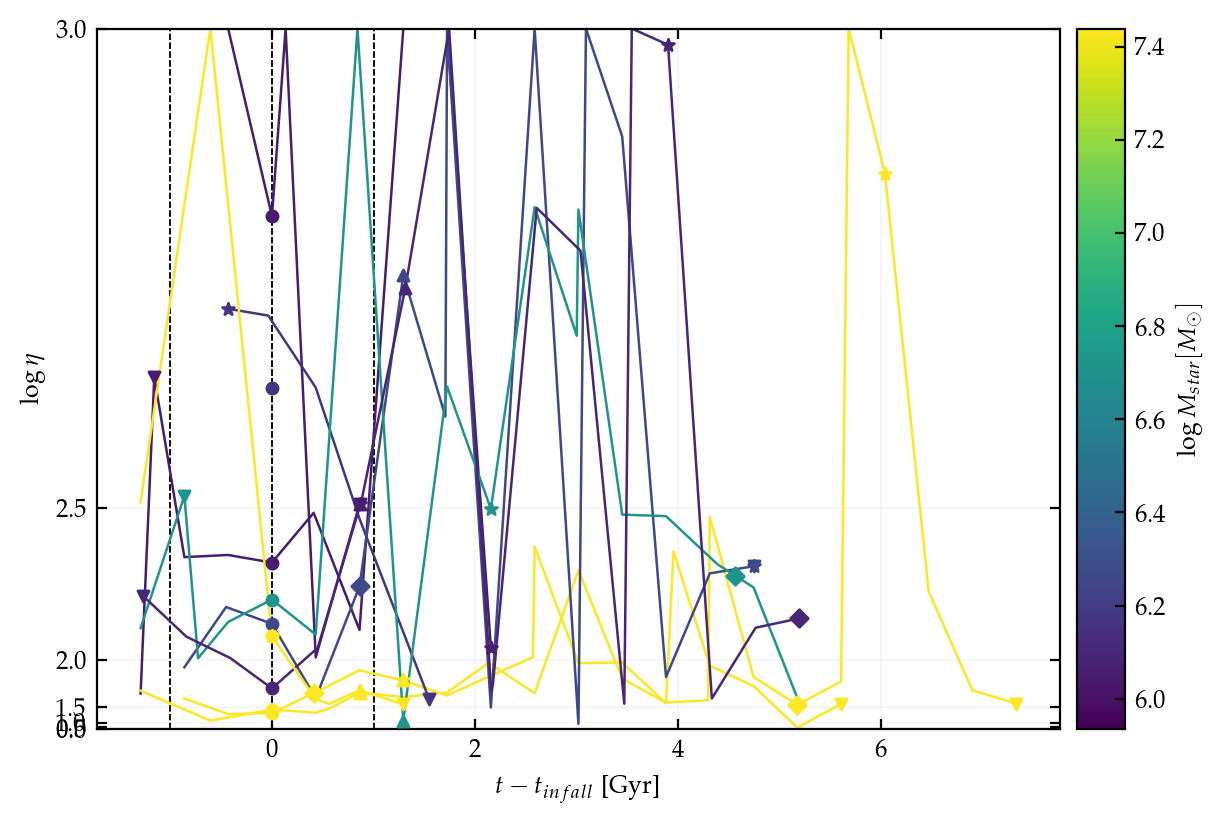

### Average MLF ###
For massive galaxies, avg MLF before infall (within 1 Gyr) is 114.43902999693641, after infall (within 1 Gyr) is 223.65144171328603, and during tinfall to tquench is 325.35408777435333.
For intermediate galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, and during tinfall to tquench is nan.
For small galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, and during tinfall to tquench is nan.
And for all galaxies, avg MLF before infall (within 1 Gyr) is 114.43902999693641, after infall (within 1 Gyr) is 223.65144171328603, and during tinfall to tquench is 325.35408777435333.


In [199]:
from functools import partial
#now do this for quenched galaxies
keys = ['h148_12', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_34', 'h148_38', 'h148_55',
        'h148_65']

fig = plt.figure(dpi=200, figsize=(6,4))
gs = mpl.gridspec.GridSpec(1,2, width_ratios = [1,0.05], figure=fig)
ax = plt.subplot(gs[:,0])
cbax = plt.subplot(gs[:,1])

for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #read infall time
    q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
    #skip plotting if it hasn't infalled or could not found
    if q_data_read.empty:
        print(f'Couldnt find the infall time for {key}')
        continue

    #read m_star, which decides the color of the plot and category for calculating avg mlf
    #use log of mass
    mstar = q_data_read.M_star
    c = cmap(mstar/(2.747402*10**7 - 8.610682*10**5))
    
    if float(mstar) > 10**8:
        is_massive = True
        #print(f'{key} is identified as massive in mass')
    elif float(mstar) > 10**7:
        is_intermediate = True
        #print(f'{key} is identified as intermediate in mass')
    else:
        is_small = True
        #print(f'{key} is identified as small in mass')
    
    #measure the relative distance from the host, then find the time at minimum ("pericentric time")
    r_rel,r_time = calc_r_rel(key)
    p_rel,p_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     
    
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    
    #time after infall
    tafterinfall = time - (13.800797 - float(q_data_read.tinfall))
    
    if ~np.isnan(float(q_data_read.tinfall)):
        #checking if any data after infall, then mark a dot for MLF at that time
        try:
            mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
            ax.scatter(0, np.log10(mlf_infall_now), c = c, s = 16, zorder = 3)
            print(f'Approximately calculated mlf_infall_now for {key}')
        except:
            mlf_infall_now = eta[-1] #infalled very recently, take the last step
        
        #then calculate mlf 1 Gyr before and after, do approximation if necessary, mark a dot for MLF at that time
        try:
            mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]+3], np.log10(mlf_infall_after), c = c, marker = "^", s = 16, zorder = 3)
            #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
            
        except:
            mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
            print(f'Approximately calculated mlf_infall_after for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
        
        try:
            mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]-3], np.log10(mlf_infall_before), c = c, marker = "v", s = 16, zorder = 3)
            #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
    
        except:
            mlf_infall_before = eta[0] #infall started when discharged particle tracking started
            print(f'Approximately calculated mlf_infall_before for {key}')
            eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
            
        print(f'{key} started infalling at {(13.800797 - float(q_data_read.tinfall))}, before is {mlf_infall_before}, now is {mlf_infall_now}, and after is {mlf_infall_after}')
    
    else:
        print(f'Could not calculate mlf_infall for {key}')
    
    #find mlf before quench, then dot plot around tquench
    #for star-forming galaxies, this process is skipped
    if ~np.isnan(float(q_data_read.tquench)):
        #read time quenched after infall
        tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))
        
        #checking if any data after quench
        try:
            mlf_quench_now = eta[np.where(tafterinfall > tquenchafterinfall)[0][0]]
            ax.scatter(tafterinfall[np.where(tafterinfall > tquenchafterinfall)[0][0]], np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            #append avg value between tinfall and tquench
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        except:
            mlf_quench_now = eta[-1] #quenched very recently, take the last item
            print(f'approximately calculated mlf_quench_now for {key}')
            #skip plotting if quenched earlier than infall
            if tquenchafterinfall > 0:
                ax.scatter(tquenchafterinfall, np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        print(f'{key} is quenched at {(13.800797 - float(q_data_read.tquench))}, mass loading factor now is {mlf_quench_now}')
        
    else:
        print(f'Could not calculate mlf_quench for {key}')
        #append avg value between iinfall to last item
        eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        if is_massive:
            mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
        else:
            mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
        mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))

    #find mlf around pericentric time
    tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time, then dot plot mlf
    try:
        mlf_pericenter = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)] #can be multiple
        mlf_pericenter_now = np.mean(mlf_pericenter[np.isfinite(mlf_pericenter)])
        t_pericenter = tafterinfall[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)]
        t_pericenter_now = np.mean(t_pericenter[np.isfinite(mlf_pericenter)])
        ax.scatter(t_pericenter_now, np.log10(mlf_pericenter_now), c = c, marker = "D", s = 20, zorder = 3)
        #append avg value around tpericenter, around 1 Gyr
        eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 1.0)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        if is_massive:
            mlf_l_pericenter_arr = np.append(mlf_l_pericenter_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_pericenter_arr = np.append(mlf_m_pericenter_arr, np.mean(eta_inrange))
        else:
            mlf_s_pericenter_arr = np.append(mlf_s_pericenter_arr, np.mean(eta_inrange))
        mlf_t_pericenter_arr = np.append(mlf_t_pericenter_arr, np.mean(eta_inrange))
        
    except:
        print(f'Could not calculate mlf_pericenter_now for {key}')
        mlf_pericenter_now = np.nan
        
    print(f'{key} is at closest to the host at {p_time}, and mass loading factor is {mlf_pericenter_now}')

    #any MLF above 1000 will be 1000 when plotting
    if any(eta > np.full(len(eta), 1000)):
        eta[eta > 1000] = 1000
        
    ax.plot(tafterinfall, np.log10(eta), c = c, label = key, lw = 0.9, zorder = 2)
    #draw a line at infall, 1 Gyr before and after
    ax.axvline(x = 0, color = 'black', ls = '--', lw = 0.6, alpha = 0.5, zorder = 1)
    ax.axvline(x = -1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)
    ax.axvline(x = 1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)

    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='vertical',
                                norm = mpl.colors.Normalize(vmin=np.log10(8.610682*10**5), vmax=np.log10(2.747402*10**7)),
                                label='$\log M_{star} [M_\odot]$')
    
ax.grid(alpha = 0.1)
ax.set_yscale('function', functions=(partial(np.power, 10.0), np.log))
ax.set_ylim(0, 3.0)
ax.set_xlabel('$t - t_{infall}$ [Gyr]')
ax.set_ylabel('$\log \eta$')

ax.tick_params(top=True,right=True,direction='in', which='both')
#plt.legend()
plt.savefig('plots/quenched_massloadingfactor_after_infall.pdf')
plt.show()

mlf_l_infall_before_arr, mlf_l_infall_after_arr, mlf_l_pericenter_arr, mlf_l_infall_to_quench_arr = mlf_l_infall_before_arr[np.isfinite(mlf_l_infall_before_arr)], mlf_l_infall_after_arr[np.isfinite(mlf_l_infall_after_arr)], mlf_l_pericenter_arr[np.isfinite(mlf_l_pericenter_arr)], mlf_l_infall_to_quench_arr[np.isfinite(mlf_l_infall_to_quench_arr)] 
mlf_m_infall_before_arr, mlf_m_infall_after_arr, mlf_m_pericenter_arr, mlf_m_infall_to_quench_arr = mlf_m_infall_before_arr[np.isfinite(mlf_m_infall_before_arr)], mlf_m_infall_after_arr[np.isfinite(mlf_m_infall_after_arr)], mlf_m_pericenter_arr[np.isfinite(mlf_m_pericenter_arr)], mlf_m_infall_to_quench_arr[np.isfinite(mlf_m_infall_to_quench_arr)] 
mlf_s_infall_before_arr, mlf_s_infall_after_arr, mlf_s_pericenter_arr, mlf_s_infall_to_quench_arr = mlf_s_infall_before_arr[np.isfinite(mlf_s_infall_before_arr)], mlf_s_infall_after_arr[np.isfinite(mlf_s_infall_after_arr)], mlf_s_pericenter_arr[np.isfinite(mlf_s_pericenter_arr)], mlf_s_infall_to_quench_arr[np.isfinite(mlf_s_infall_to_quench_arr)] 
mlf_t_infall_before_arr, mlf_t_infall_after_arr, mlf_t_pericenter_arr, mlf_t_infall_to_quench_arr = mlf_t_infall_before_arr[np.isfinite(mlf_t_infall_before_arr)], mlf_t_infall_after_arr[np.isfinite(mlf_t_infall_after_arr)], mlf_t_pericenter_arr[np.isfinite(mlf_t_pericenter_arr)], mlf_t_infall_to_quench_arr[np.isfinite(mlf_t_infall_to_quench_arr)]

print("### Average MLF ###")
print(f'For massive galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_l_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_l_infall_after_arr)}, and during tinfall to tquench is {np.mean(mlf_l_infall_to_quench_arr)}.')
print(f'For intermediate galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_m_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_m_infall_after_arr)}, and during tinfall to tquench is {np.mean(mlf_m_infall_to_quench_arr)}.')
print(f'For small galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_s_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_s_infall_after_arr)}, and during tinfall to tquench is {np.mean(mlf_s_infall_to_quench_arr)}.')
print(f'And for all galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_t_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_t_infall_after_arr)}, and during tinfall to tquench is {np.mean(mlf_t_infall_to_quench_arr)}.')

> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_14 <
Approximately calculated mlf_infall_now for h229_14
h229_14 started infalling at 8.736777529833152, before is 111.21478491711956, now is 189.18981478967703, and after is 423.25250412292553
approximately calculated mlf_quench_now for h229_14
h229_14 is quenched at 13.585404306807222, mass loading factor now is 61.449244790243704
h229_14 is at closest to the host at 9.383248597782787, and mass loading factor is 269.48381390246794


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_18 <
Approximately calculated mlf_infall_now for h229_18
h229_18 started infalling at 7.767071673904962, before is 160.41550826455722, now is 107.72192839545207, and after is 215.79058243981217
h229_18 is quenched at 8.090404456545299, mass loading factor now is 38.251173737966255
h229_18 is at closest to the host at 8.608830726728616, and mass loading factor is 583.7820989275405


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_20 <
Approximately calculated mlf_infall_now for h229_20
h229_20 started infalling at 7.767071673904962, before is 1032.0411861318128, now is inf, and after is inf
h229_20 is quenched at 8.736875027163657, mass loading factor now is 443.8295342430908
h229_20 is at closest to the host at 8.413542741855249, and mass loading factor is 615.2283464528281


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_22 <
Approximately calculated mlf_infall_now for h229_22
h229_22 started infalling at 7.4438363885952095, before is 287.4558863307668, now is inf, and after is 278.31151474856546
h229_22 is quenched at 7.767169171235468, mass loading factor now is 259.0898286936033
h229_22 is at closest to the host at 8.0903074565453, and mass loading factor is 268.7006717210844


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h229_49 <
Approximately calculated mlf_infall_now for h229_49
h229_49 started infalling at 8.413542244524741, before is 995.980779461181, now is 856.5787719018693, and after is 1021.2207073885684
h229_49 is quenched at 9.706580883092371, mass loading factor now is 225.81780615432817
h229_49 is at closest to the host at 12.938836736188087, and mass loading factor is nan


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_21 <
Approximately calculated mlf_infall_now for h242_21
h242_21 started infalling at 9.060012815297734, before is 167.52888195540848, now is 146.06472581265444, and after is 196.90027214096511
h242_21 is quenched at 10.767196663169393, mass loading factor now is 388.7757921912774
h242_21 is at closest to the host at 9.060013312628241, and mass loading factor is 167.75807751355322


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_30 <
Approximately calculated mlf_infall_now for h242_30
h242_30 started infalling at 5.181189391582574, before is 99.54574519688776, now is 2064.086797481872, and after is inf
h242_30 is quenched at 5.868161870196261, mass loading factor now is 649.9845128688725
h242_30 is at closest to the host at 5.504425174222988, and mass loading factor is 2273.837783491764


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_38 <
Approximately calculated mlf_infall_now for h242_38
h242_38 started infalling at 11.645895097774288, before is 954.5128628793053, now is 112.0525264340795, and after is 383.63347011694333
h242_38 is quenched at 12.292463165723916, mass loading factor now is 315.17215906615775
h242_38 is at closest to the host at 12.292366165723918, and mass loading factor is 255.9743722284361
> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h242_69 <
Approximately calculated mlf_infall_now for h242_69
h242_69 started infalling at 9.060012815297734, before is 36.904527370803514, now is 150.24273934459046, and after is 214.77895001828412
h242_69 is quenched at 12.93893373634306, mass loading factor now is 448.2482917162963
h242_69 is at closest to the host at 13.26207202165263, and mass loading factor is 285.109144410092

/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_33571/800794668.py:41: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


> Returning (sfr) variable for h329_29 <
Approximately calculated mlf_infall_now for h329_29
h329_29 started infalling at 8.413542244745276, before is 30.946157690860367, now is inf, and after is 1298.2213413171628
h329_29 is quenched at 8.73687502738418, mass loading factor now is 1298.2213413171628
h329_29 is at closest to the host at 9.060013312693755, and mass loading factor is 633.7942860343528


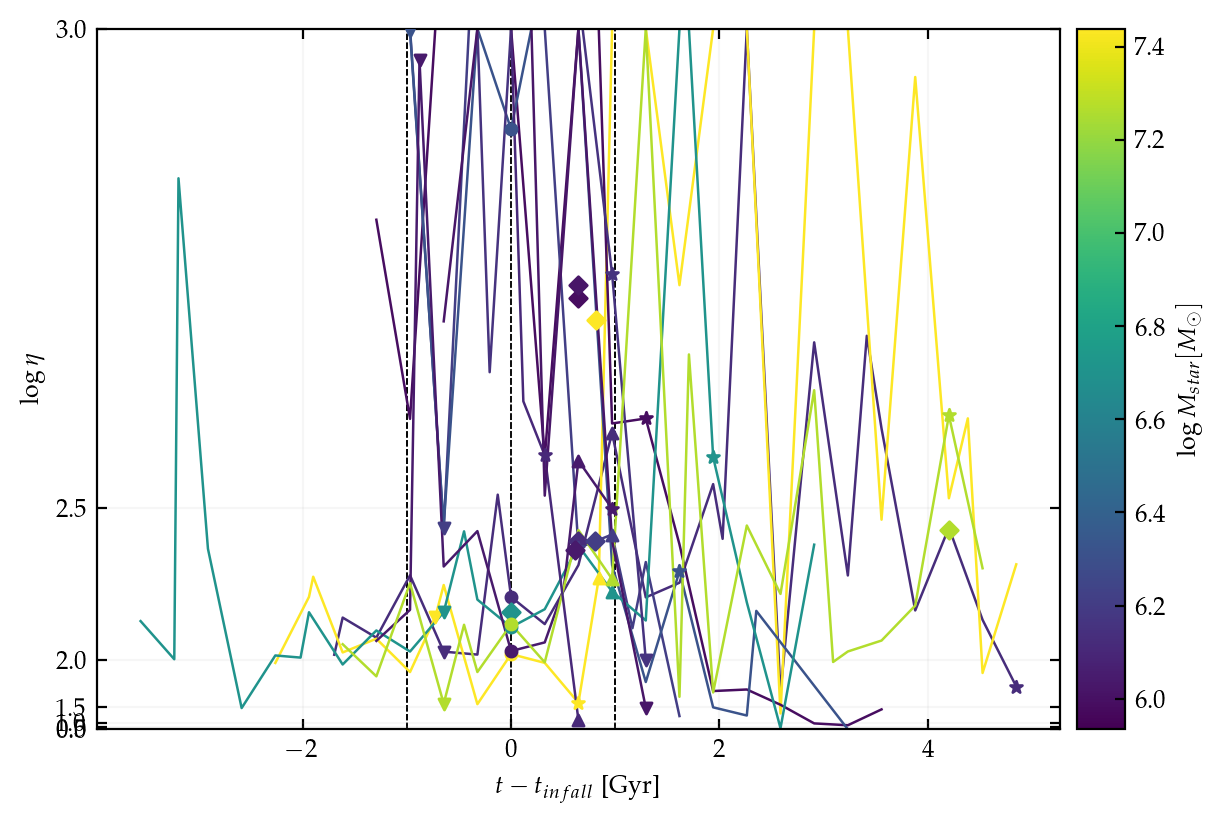

### Average MLF ###
For massive galaxies, avg MLF before infall (within 1 Gyr) is 381.67957672296995, after infall (within 1 Gyr) is 372.16870298850546, at around pericentric distance is 318.21031653494765, and during tinfall to tquench is 418.36808545113337.
For intermediate galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, at around pericentric distance is nan, and during tinfall to tquench is nan.
For small galaxies, avg MLF before infall (within 1 Gyr) is nan, after infall (within 1 Gyr) is nan, at around pericentric distance is nan, and during tinfall to tquench is nan.
And for all galaxies, avg MLF before infall (within 1 Gyr) is 381.67957672296995, after infall (within 1 Gyr) is 372.16870298850546, at around pericentric distance is 318.21031653494765, and during tinfall to tquench is 418.36808545113337.


In [200]:
keys = ['h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h329_117', 'h329_29']

fig = plt.figure(dpi=200, figsize=(6,4))
gs = mpl.gridspec.GridSpec(1,2, width_ratios = [1,0.05], figure=fig)
ax = plt.subplot(gs[:,0])
cbax = plt.subplot(gs[:,1])

for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #read infall time
    q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
    #skip plotting if it hasn't infalled or could not found
    if q_data_read.empty:
        print(f'Couldnt find the infall time for {key}')
        continue

    #read m_star, which decides the color of the plot and category for calculating avg mlf
    #logged because its massive
    mstar = q_data_read.M_star
    c = cmap(mstar/(2.747402*10**7 - 8.610682*10**5))
    
    if float(mstar) > 10**8:
        is_massive = True
        #print(f'{key} is identified as massive in mass')
    elif float(mstar) > 10**7:
        is_intermediate = True
        #print(f'{key} is identified as intermediate in mass')
    else:
        is_small = True
        #print(f'{key} is identified as small in mass')
    
    #measure the relative distance from the host, then find the time at minimum ("pericentric time")
    r_rel,r_time = calc_r_rel(key)
    p_rel,p_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     
    
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    
    #time after infall
    tafterinfall = time - (13.800797 - float(q_data_read.tinfall))
    
    if ~np.isnan(float(q_data_read.tinfall)):
        #checking if any data after infall, then mark a dot for MLF at that time
        try:
            mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
            ax.scatter(0, np.log10(mlf_infall_now), c = c, s = 16, zorder = 3)
            print(f'Approximately calculated mlf_infall_now for {key}')
        except:
            mlf_infall_now = eta[-1] #infalled very recently, take the last step
        
        #then calculate mlf 1 Gyr before and after, do approximation if necessary, mark a dot for MLF at that time
        try:
            mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]+3], np.log10(mlf_infall_after), c = c, marker = "^", s = 16, zorder = 3)
            #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
            
        except:
            mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
            print(f'Approximately calculated mlf_infall_after for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            if is_massive:
                mlf_l_infall_after_arr = np.append(mlf_l_infall_after_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_after_arr = np.append(mlf_m_infall_after_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_after_arr = np.append(mlf_s_infall_after_arr, np.mean(eta_inrange))
            mlf_t_infall_after_arr = np.append(mlf_t_infall_after_arr, np.mean(eta_inrange))
        
        try:
            mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
            ax.scatter(tafterinfall[np.where(tafterinfall > 0)[0][0]-3], np.log10(mlf_infall_before), c = c, marker = "v", s = 16, zorder = 3)
            #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
    
        except:
            mlf_infall_before = eta[0] #infall started when discharged particle tracking started
            print(f'Approximately calculated mlf_infall_before for {key}')
            eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_before_arr = np.append(mlf_l_infall_before_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_before_arr = np.append(mlf_m_infall_before_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_before_arr = np.append(mlf_s_infall_before_arr, np.mean(eta_inrange))
            mlf_t_infall_before_arr = np.append(mlf_t_infall_before_arr, np.mean(eta_inrange))
            
        print(f'{key} started infalling at {(13.800797 - float(q_data_read.tinfall))}, before is {mlf_infall_before}, now is {mlf_infall_now}, and after is {mlf_infall_after}')
    
    else:
        print(f'Could not calculate mlf_infall for {key}')
    
    #find mlf before quench, then dot plot around tquench
    #for star-forming galaxies, this process is skipped
    if ~np.isnan(float(q_data_read.tquench)):
        #read time quenched after infall
        tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))
        
        #checking if any data after quench
        try:
            mlf_quench_now = eta[np.where(tafterinfall > tquenchafterinfall)[0][0]]
            ax.scatter(tafterinfall[np.where(tafterinfall > tquenchafterinfall)[0][0]], np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            #append avg value between tinfall and tquench
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        except:
            mlf_quench_now = eta[-1] #quenched very recently, take the last item
            print(f'approximately calculated mlf_quench_now for {key}')
            #skip plotting if quenched earlier than infall
            if tquenchafterinfall > 0:
                ax.scatter(tquenchafterinfall, np.log10(mlf_quench_now), c = c, marker = "*", s = 20, zorder = 3)
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
            if is_massive:
                mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
            elif is_intermediate:
                mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
            else:
                mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
            mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))
        
        print(f'{key} is quenched at {(13.800797 - float(q_data_read.tquench))}, mass loading factor now is {mlf_quench_now}')
        
    else:
        print(f'Could not calculate mlf_quench for {key}')
        #append avg value between iinfall to last item
        eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        if is_massive:
            mlf_l_infall_to_quench_arr = np.append(mlf_l_infall_to_quench_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_infall_to_quench_arr = np.append(mlf_m_infall_to_quench_arr, np.mean(eta_inrange))
        else:
            mlf_s_infall_to_quench_arr = np.append(mlf_s_infall_to_quench_arr, np.mean(eta_inrange))
        mlf_t_infall_to_quench_arr = np.append(mlf_t_infall_to_quench_arr, np.mean(eta_inrange))

    #find mlf around pericentric time
    tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time, then dot plot mlf
    try:
        mlf_pericenter = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)] #can be multiple
        mlf_pericenter_now = np.mean(mlf_pericenter[np.isfinite(mlf_pericenter)])
        t_pericenter = tafterinfall[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.4)]
        t_pericenter_now = np.mean(t_pericenter[np.isfinite(mlf_pericenter)])
        ax.scatter(t_pericenter_now, np.log10(mlf_pericenter_now), c = c, marker = "D", s = 20, zorder = 3)
        #append avg value around tpericenter, around 1 Gyr
        eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 1.0)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        if is_massive:
            mlf_l_pericenter_arr = np.append(mlf_l_pericenter_arr, np.mean(eta_inrange))
        elif is_intermediate:
            mlf_m_pericenter_arr = np.append(mlf_m_pericenter_arr, np.mean(eta_inrange))
        else:
            mlf_s_pericenter_arr = np.append(mlf_s_pericenter_arr, np.mean(eta_inrange))
        mlf_t_pericenter_arr = np.append(mlf_t_pericenter_arr, np.mean(eta_inrange))

    except:
        print(f'Could not calculate mlf_pericenter_now for {key}')
        mlf_pericenter_now = np.nan
        
    print(f'{key} is at closest to the host at {p_time}, and mass loading factor is {mlf_pericenter_now}')

    #any MLF above 1000 will be 1000 when plotting
    if any(eta > np.full(len(eta), 1000)):
        eta[eta > 1000] = 1000
        
    ax.plot(tafterinfall, np.log10(eta), c = c, label = key, lw = 0.9, zorder = 2)
    #draw a line at infall, 1 Gyr before and after
    ax.axvline(x = 0, color = 'black', ls = '--', lw = 0.6, alpha = 0.5, zorder = 1)
    ax.axvline(x = -1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)
    ax.axvline(x = 1, color = 'black', ls = '--', lw = 0.6, alpha = 0.3, zorder = 1)

    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='vertical',
                                norm = mpl.colors.Normalize(vmin=np.log10(8.610682*10**5), vmax=np.log10(2.747402*10**7)),
                                label='$\log M_{star} [M_\odot]$')
    
ax.grid(alpha = 0.1)
ax.set_yscale('function', functions=(partial(np.power, 10.0), np.log))
ax.set_ylim(0, 3.0)
ax.set_xlabel('$t - t_{infall}$ [Gyr]')
ax.set_ylabel('$\log \eta$')

ax.tick_params(top=True,right=True,direction='in', which='both')
plt.legend()
plt.show()

mlf_l_infall_before_arr, mlf_l_infall_after_arr, mlf_l_pericenter_arr, mlf_l_infall_to_quench_arr = mlf_l_infall_before_arr[np.isfinite(mlf_l_infall_before_arr)], mlf_l_infall_after_arr[np.isfinite(mlf_l_infall_after_arr)], mlf_l_pericenter_arr[np.isfinite(mlf_l_pericenter_arr)], mlf_l_infall_to_quench_arr[np.isfinite(mlf_l_infall_to_quench_arr)] 
mlf_m_infall_before_arr, mlf_m_infall_after_arr, mlf_m_pericenter_arr, mlf_m_infall_to_quench_arr = mlf_m_infall_before_arr[np.isfinite(mlf_m_infall_before_arr)], mlf_m_infall_after_arr[np.isfinite(mlf_m_infall_after_arr)], mlf_m_pericenter_arr[np.isfinite(mlf_m_pericenter_arr)], mlf_m_infall_to_quench_arr[np.isfinite(mlf_m_infall_to_quench_arr)] 
mlf_s_infall_before_arr, mlf_s_infall_after_arr, mlf_s_pericenter_arr, mlf_s_infall_to_quench_arr = mlf_s_infall_before_arr[np.isfinite(mlf_s_infall_before_arr)], mlf_s_infall_after_arr[np.isfinite(mlf_s_infall_after_arr)], mlf_s_pericenter_arr[np.isfinite(mlf_s_pericenter_arr)], mlf_s_infall_to_quench_arr[np.isfinite(mlf_s_infall_to_quench_arr)] 
mlf_t_infall_before_arr, mlf_t_infall_after_arr, mlf_t_pericenter_arr, mlf_t_infall_to_quench_arr = mlf_t_infall_before_arr[np.isfinite(mlf_t_infall_before_arr)], mlf_t_infall_after_arr[np.isfinite(mlf_t_infall_after_arr)], mlf_t_pericenter_arr[np.isfinite(mlf_t_pericenter_arr)], mlf_t_infall_to_quench_arr[np.isfinite(mlf_t_infall_to_quench_arr)]

print("### Average MLF ###")
print(f'For massive galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_l_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_l_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_l_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_l_infall_to_quench_arr)}.')
print(f'For intermediate galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_m_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_m_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_m_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_m_infall_to_quench_arr)}.')
print(f'For small galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_s_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_s_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_s_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_s_infall_to_quench_arr)}.')
print(f'And for all galaxies, avg MLF before infall (within 1 Gyr) is {np.mean(mlf_t_infall_before_arr)}, after infall (within 1 Gyr) is {np.mean(mlf_t_infall_after_arr)}, at around pericentric distance is {np.mean(mlf_t_pericenter_arr)}, and during tinfall to tquench is {np.mean(mlf_t_infall_to_quench_arr)}.')

## Mass loading factor in different mass sizes
Question came up is how does infall, quench, and distance closest to the host can affect the mass loading factor and how does that differ for different satellites with different masses. To find out, I plot the avg MLF log for each satellite over stellar mass. Avg MLF values are 1 Gyr before and after infall, during tinfall to tquench, and first time at pericentric passage. And maybe 2nd time as well.

In [208]:
print(len(mlf_l_infall_after_arr), len(mlf_t_infall_after_arr))

27 27


In [3]:
#create a dataframe

def calc_mlf_adv(key, save=True):
    import os
    '''
    This function calculates the mlf and avg values around infall (1Gyr before and after),
    to quench, and around pericentric distance for the first time
    '''
    
    sim = str(key[:4])
    haloid = int(key[5:])
    output = pd.DataFrame()
    
    #read infall time
    q_data = read_timescales()
    q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
    #warn the user if it hasn't infalled or could not found
    if q_data_read.empty:
        print(f'Couldnt find the infall time for {key}')
        return
    print(f'Now calculating avg mlf for {key}')
    
    #concat q_data to output
    output = pd.concat([output, q_data_read])
    
    #import satellite data
    #read m_gas, mass, and Rvir information from 'all-satellite-data.csv'
    m_data = pd.read_csv('all-satellite-data.csv')
    output['M_gas'] = np.array(m_data[m_data['key'] == key]['mgas'])
    output['Mass'] = np.array(m_data[m_data['key'] == key]['mass'])
    output['Rvir'] = np.array(m_data[m_data['key'] == key]['Rvir'])
    
    
    #read m_star, which decides the category of mass sizes
    mstar = q_data_read.M_star
    
    if float(mstar) > 10**8:
        is_massive = True
        is_intermediate = False
        is_small = False
    elif float(mstar) > 10**7:
        is_intermediate = True
        is_massive = False
        is_small = False
    else:
        is_small = True
        is_massive = False
        is_intermediate = False
        
    output['is_massive'] = is_massive
    output['is_intermediate'] = is_intermediate
    output['is_small'] = is_small
    
    #measure the relative distance from the host, then find the first time at the pericentric distance (p_rel)
    r_rel,r_time = calc_r_rel(key)
    p_rel, p_time = r_rel[0], r_time[0]
    for d, t in zip(r_rel, r_time):
        if d <= p_rel:
            p_rel, p_time = d, t
        elif d > p_rel: #found the first pericentric distance
            break
    #find the minimum as well (m_rel)
    m_rel,m_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     
    
    output['1st p_time'] = p_time
    output['min p_time'] = m_time
    
    #run mass loading factor calculation
    time, eta = calc_mlf(key)
    
    #time after infall
    tafterinfall = time - (13.800797 - float(q_data_read.tinfall))
    
    if ~np.isnan(float(q_data_read.tinfall)):
        #checking if any data after infall, then mark a dot for MLF at that time
        try:
            mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
        except:
            mlf_infall_now = eta[-1] #infalled very recently, take the last step
            print(f'Approximately calculated mlf_infall_now for {key}')
        output['mlf_infall'] = mlf_infall_now
        
        #then calculate avg mlf 1 Gyr before and after, do approximation if necessary
        try:
            mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after        
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
        except:
            mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
            print(f'Approximately calculated mlf_infall_after for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
        output['mlf_infall_after'] = np.mean(eta_inrange)
        
        try:
            mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
    
        except:
            mlf_infall_before = eta[0] #infall started when discharged particle tracking started
            print(f'Approximately calculated mlf_infall_before for {key}')
            eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
        output['mlf_infall_before'] = np.mean(eta_inrange)
        
    else:
        print(f'Could not calculate mlf_infall for {key}')
        output['mlf_infall'] = np.nan
        output['mlf_infall_after'] = np.nan
        output['mlf_infall_before'] = np.nan
    
    #find avg mlf before quench
    #for star-forming galaxies, this process is skipped
    if ~np.isnan(float(q_data_read.tquench)):
        #read time quenched after infall
        tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))
        
        #checking if any data after quench
        try:
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        except:
            #quenched very recently, take until the last item
            print(f'approximately calculated mlf_infall_to_quench for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
        #append avg value between tinfall and tquench
        output['mlf_infall_to_quench'] = np.mean(eta_inrange)
        
    else:
        print(f'Could not calculate mlf_quench for {key}')
        eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value between iinfall to last item
        output['mlf_infall_to_quench'] = np.mean(eta_inrange)

    #find mlf around 1st pericentric time
    #time at 1st pericentric distance
    tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time
    try:
        #find avg mlf 1 Gyr before and after p_time
        eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.5)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        #append avg value around tpericenter, around 1 Gyr
        output['mlf_1st_pericenter'] = np.mean(eta_inrange)

    except:
        print(f'Could not calculate mlf_1st_pericenter for {key}')
        output['mlf_1st_pericenter'] = np.nan
        
    #find mlf around minimum pericentric time
    #time at minimum pericentric distance
    tpericenter2afterinfall = m_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time
    try:
        #find avg mlf 1 Gyr before and after m_time
        eta_inrange = eta[np.isclose(tafterinfall, tpericenter2afterinfall, atol = 0.5)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        #append avg value around tpericenter, around 1 Gyr
        output['mlf_min_pericenter'] = np.mean(eta_inrange)

    except:
        print(f'Could not calculate mlf_min_pericenter for {key}')
        output['mlf_min_pericenter'] = np.nan
        
    #save the output (also avoid duplicates)    
    if save:
        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv'
        
        if os.path.exists(filepath):
            output.to_csv(filepath, mode='a', index = False, header = False)
        
        else:
            #create a file with the appropriate header
            output.to_csv(filepath, index = False)
        
        print(f'Saving {key} avg mlf values to {filepath}')
        
        
    return output

In [109]:
#calculate avg mlf for different satellites
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

start = time.time()
for key in keys:
    output = calc_mlf_adv(key) #took 820s
end = time.time()
print("Program finished execution: ", end - start, " s")

Now calculating avg mlf for h148_10
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning (accreted, reaccreted) for satellite h148_10 <
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_10
Saving h148_10 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_12
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning (accreted, reaccreted) for satellite h148_12 <
> Returning <tracked_particle> dataset <


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_12 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_2
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <
> Returning (accreted, reaccreted) for satellite h148_2 <
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_2
Could not calculate mlf_quench for h148_2
Saving h148_2 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_249
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <
> Returning (accreted, reaccreted) for satellite h148_249 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_249 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_251
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <
> Returning (accreted, reaccreted) for satellite h148_251 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_251 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_27
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <
> Returning (accreted, reaccreted) for satellite h148_27 <
> Returning <tracked_particle> dataset <


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_27 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_282
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <
> Returning (accreted, reaccreted) for satellite h148_282 <
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_282
Saving h148_282 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_3


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/en

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_3 <
> Returning (accreted, reaccreted) for satellite h148_3 <
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_3
Saving h148_3 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_34
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_34 <
> Returning (accreted, reaccreted) for satellite h148_34 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_34 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_38
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_38 <
> Returning (accreted, reaccreted) for satellite h148_38 <
> Returning <tracked_particle> dataset <
Saving h148_38 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_4
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_4 <
> Returning (accreted, reaccreted) for satellite h148_4 <
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_4
Saving h148_4 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h148_55
> Returning <tracked_particle> dataset <
> Returning (predischarged

/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/from

Saving h148_65 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h229_14
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_14 <
> Returning (accreted, reaccreted) for satellite h229_14 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


approximately calculated mlf_infall_to_quench for h229_14
Saving h229_14 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h229_18
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_18 <
> Returning (accreted, reaccreted) for satellite h229_18 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


Saving h229_18 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h229_20
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_20 <
> Returning (accreted, reaccreted) for satellite h229_20 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


Saving h229_20 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h229_22
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_22 <
> Returning (accreted, reaccreted) for satellite h229_22 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h229_22 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h229_49
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_49 <
> Returning (accreted, reaccreted) for satellite h229_49 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h229_49 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_10
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_10 <
> Returning (accreted, reaccreted) for satellite h242_10 <
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h242_10
Saving h242_10 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_21
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_21 <
> Returning (accreted, reaccreted) for satellite h242_21 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]


Saving h242_21 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_30
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_30 <
> Returning (accreted, reaccreted) for satellite h242_30 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h242_30 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_38
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_38 <
> Returning (accreted, reaccreted) for satellite h242_38 <
> Returning <tracked_particle> dataset <
Saving h242_38 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_69
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_69 <
> Returning (accreted, reaccreted) for satellite h242_69 <
> Returning <tracked_particle> dataset <
Saving h242_69 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h242_8
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for sa

/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h329_117 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h329_29
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_29 <
> Returning (accreted, reaccreted) for satellite h329_29 <
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/2847441324.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = Mout_rate_arr/sfrs # [unitless]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h329_29 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Now calculating avg mlf for h329_7
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_7 <
> Returning (accreted, reaccreted) for satellite h329_7 <
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h329_7
Could not calculate mlf_quench for h329_7
Saving h329_7 avg mlf values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv
Program finished execution:  820.0336177349091  s


In [110]:
output = pd.read_csv('/home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv')
output

haloid  quenched    tquench  tquench_lower  tquench_upper   tinfall  \
0       10     False        NaN            NaN            NaN  5.602745   
1       12      True   4.740687       5.191869      -0.000097  5.602745   
2        2     False        NaN            NaN            NaN  0.861961   
3      249      True   3.878726       3.878726       3.878726  5.602745   
4      251      True   6.464608       6.464608       6.464608  6.895686   
5       27      True   1.649749       1.649749      -0.000097  7.326666   
6      282      True  10.067335      10.067335      10.067335  9.481568   
7        3     False        NaN            NaN            NaN  3.878823   
8       34      True   0.430883       0.430883       0.430883  4.740784   
9       38      True   4.309706       4.309706       4.309706  6.033725   
10       4     False        NaN            NaN            NaN  1.723922   
11      55      True   1.649749       1.649749       1.649749  5.191967   
12       6     False        NaN            NaN            NaN  2.154902   
13      65      True   7.932635       8.619510       7.932635  7.326666   
14      14      True   0.215393       1.649749       0.215393  5.064019   
15      18      True   5.710393       6.033628       2.154804  6.033725   
16      20      True   5.063922       5.063922       5.063922  6.033725   
17      22      True   6.033628       7.649804       6.033628  6.356961   
18      49      True   4.094216       4.094216       4.094216  5.387255   
19      10     False        NaN            NaN            NaN  7.973137   
20      21      True   3.033600       3.447746       2.154804  4.740784   
21      30      True   7.932635       7.932635       7.932635  8.619608   
22      38      True   1.508334       1.508334       1.508334  2.154902   
23      69      True   0.861863       0.861863       0.538628  4.740784   
24       8     False        NaN            NaN            NaN  8.296372   
25     117      True   8.824899       8.824899       8.824899  8.942843   
26      29      True   5.063922       5.063922       5.063922  5.387255   
27       7     False        NaN            NaN            NaN  0.538725   

    tinfall_lower  tinfall_upper        M_star   sim  ...  is_intermediate  \
0        5.602745       5.602745  1.353274e+08  h148  ...            False   
1        5.602745       5.602745  1.043767e+08  h148  ...            False   
2        1.292941       0.861961  2.268773e+09  h148  ...            False   
3        5.602745       5.191967  2.063790e+06  h148  ...            False   
4        6.895686       6.895686  2.149496e+06  h148  ...            False   
5        7.326666       7.326666  8.415728e+07  h148  ...             True   
6        9.481568       9.481568  3.984286e+06  h148  ...            False   
7        4.309804       3.878823  1.502171e+09  h148  ...            False   
8        4.740784       4.309804  5.759679e+06  h148  ...            False   
9        6.033725       6.033725  1.374093e+07  h148  ...             True   
10       1.723922       1.292941  4.317847e+08  h148  ...            False   
11       5.191967       5.191967  2.822993e+06  h148  ...            False   
12       2.154902       1.723922  3.315968e+08  h148  ...            False   
13       7.326666       7.326666  3.001293e+07  h148  ...             True   
14       5.191967       4.740784  3.338275e+06  h229  ...            False   
15       6.033725       5.710490  7.714878e+07  h229  ...             True   
16       6.033725       5.710490  8.610682e+05  h229  ...            False   
17       6.761005       6.356961  4.786508e+06  h229  ...            False   
18       5.387255       5.191967  6.790767e+06  h229  ...            False   
19       7.973137       7.932733  7.955202e+08  h242  ...            False   
20       5.387255            NaN  1.365987e+07  h242  ...             True   
21       8.619608       8.296372  3.872857e+06  h242  ...            False   
22       2.154902       1.831667  

In [6]:
output.keys()

Index(['haloid', 'quenched', 'tquench', 'tquench_lower', 'tquench_upper',
       'tinfall', 'tinfall_lower', 'tinfall_upper', 'M_star', 'sim', 'M_gas',
       'Mass', 'Rvir', 'is_massive', 'is_intermediate', 'is_small',
       '1st p_time', 'min p_time', 'mlf_infall', 'mlf_infall_after',
       'mlf_infall_before', 'mlf_infall_to_quench', 'mlf_1st_pericenter',
       'mlf_min_pericenter'],
      dtype='object')

Text(0, 0.5, '$log \\eta$')

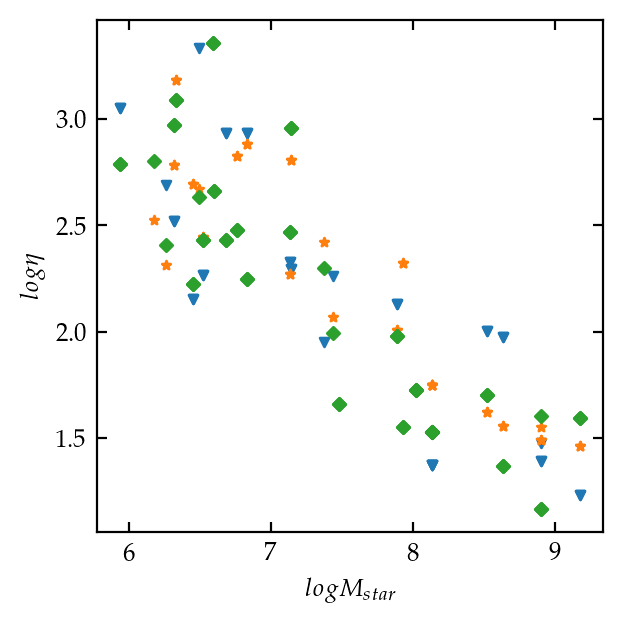

In [5]:
fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))
b = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_before']), marker = "v", s = 10)
#a = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_after']), marker = "^", s = 10)
q = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_to_quench']), marker = "*", s = 10)
p = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_1st_pericenter']), marker = "D", s = 10)
#mp = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_min_pericenter']), marker = "s", s = 10)
ax.set_xlabel("$log M_{star}$")
ax.set_ylabel("$log \eta$")
#plt.legend((b,a,q,p,mp),('Infall - 1','Infall + 1','Post infall','1st Pericentric','Min Pericentric'), fontsize = 7)

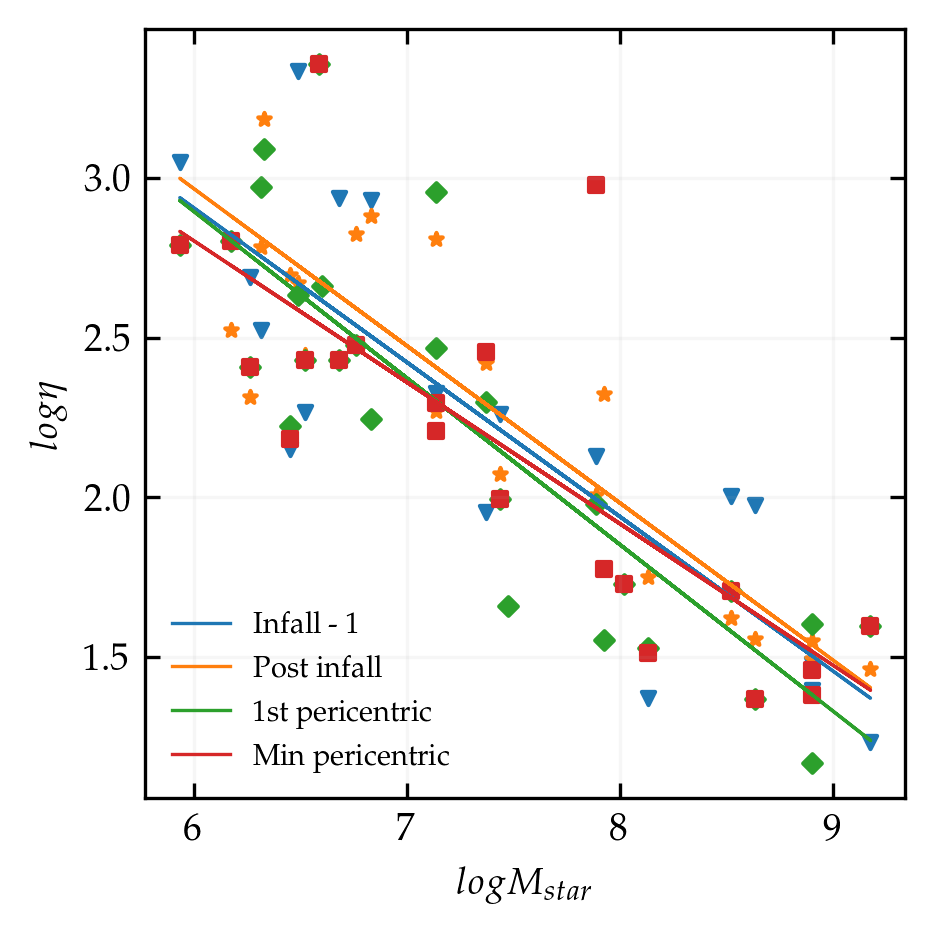

In [305]:
#linear fit of loglog plot
fig, ax = plt.subplots(1,1, dpi=300, figsize = (3,3))

# first, log-convert the data:
from scipy.optimize import curve_fit
def func(x,s,y0):
    return y0+s*x

# the initial guess for the function parameters:
s_guess = [1]
y_guess = [3]

xb = np.log10(output['M_star'][np.isfinite(output['mlf_infall_before'])])
yb = np.log10(output['mlf_infall_before'][np.isfinite(output['mlf_infall_before'])])
plt.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_before']), marker = "v", s = 10)

popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
plt.plot(xb, func(xb, *popt), lw = 0.8, label = 'Infall - 1')

xq = np.log10(output['M_star'][np.isfinite(output['mlf_infall_to_quench'])])
yq = np.log10(output['mlf_infall_to_quench'][np.isfinite(output['mlf_infall_to_quench'])])
plt.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_to_quench']), marker = "*", s = 10)

popt, pcov = curve_fit(func, xq, yq, p0=[s_guess,y_guess])
plt.plot(xq, func(xq, *popt), lw = 0.8, label = 'Post infall')

xp = np.log10(output['M_star'][np.isfinite(output['mlf_1st_pericenter'])])
yp = np.log10(output['mlf_1st_pericenter'][np.isfinite(output['mlf_1st_pericenter'])])
plt.scatter(np.log10(output['M_star']), np.log10(output['mlf_1st_pericenter']), marker = "D", s = 10)

popt, pcov = curve_fit(func, xp, yp, p0=[s_guess,y_guess])
plt.plot(xp, func(xp, *popt), lw = 0.8, label = '1st pericentric')

xm = np.log10(output['M_star'][np.isfinite(output['mlf_min_pericenter'])])
ym = np.log10(output['mlf_min_pericenter'][np.isfinite(output['mlf_min_pericenter'])])
plt.scatter(np.log10(output['M_star']), np.log10(output['mlf_min_pericenter']), marker = "s", s = 10)

popt, pcov = curve_fit(func, xm, ym, p0=[s_guess,y_guess])
plt.plot(xm, func(xm, *popt), lw = 0.8, label = 'Min pericentric')

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel("$log \eta$")
plt.grid(alpha = 0.1)
plt.legend(fontsize = 7)
plt.show()

## Run for expelled gas, and SN-heated gas
It seems like there aren't any big of a different across different time step. Big results! Now, I will look at expelled gas, SN-heated gas, and how this result differs from them. Also, I will modify this to have only one at infall, by averaging before and after.

In [4]:
def read_one_discharged(key):
    '''
    -> Reads predischarged, discharged, accreted, and hot_predischarged into workable dataframes.
        Only run for one sat.
    '''
    #--------------------------------#
    
    predischarged = pd.DataFrame()
    discharged = pd.DataFrame()
    #hot_predischarged= pd.DataFrame()
    
    sim = key[:4]
    haloid = int(key[5:])
    predischarged = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/predischarged_particles.hdf5', key=key)

    discharged = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/discharged_particles.hdf5', key=key)

    #hot_predischarged = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/hot_predischarged_particles.hdf5', key=key)
       
    print(f'> Returning (predischarged, discharged, hot_predischarged) for satellite {key} <')
    return predischarged, discharged#, hot_predischarged


def read_one_accreted(key):
    '''
    -> Reads accreted particles, reaccreted particles into workable dataframes for analysis.
        Only run for one sat.
    '''
    #--------------------------------#
    
    accreted = pd.DataFrame()
    reaccreted = pd.DataFrame()

    sim = key[:4]
    haloid = int(key[5:])

    accreted = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/accreted_particles.hdf5', key=key)
    
    reaccreted = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/reaccreted_particles.hdf5', key=key)

    print(f'> Returning (accreted, reaccreted) for satellite {key} <')
    return accreted, reaccreted

In [63]:
# define gas particles as 'expelled' if they are not reaccreted onto the disk of their host satellite
# after being discharged
# code borrowed from Leo's StellarFeedbackAnalysis -> Permanently Expelled Gas section

def calc_expelled(key, save=True, verbose=True):
    #find expelled (permanently) gas
    #import tqdm
    import warnings
    
    if verbose: print(f'Now compiling expelled particles for {key}...')
    
    #load discharged, reaccreted gas particles
    predischarged,discharged = read_one_discharged(key)
    _,reaccreted = read_one_accreted(key)
    
    #create a dataframe for expelled gas
    expelled = pd.DataFrame()
    preexpelled = pd.DataFrame()
    
    #pid as np.array
    did = np.array(discharged.pid)
    rid = np.array(reaccreted.pid)
    
    #drop the duplicates of pids and get unique set
    dfunique = discharged.drop_duplicates(subset=['pid'], keep='last')
    
    #find the pid expelled
    index = np.argsort(rid)
    sorted_rid = rid[index]  # Sorted list of ids reaccreted

    from collections import Counter
    #find ids that discharged more than reaccreted (expelled at the last timestep)
    #also find pids that discharged but never be reaccreted
    subCount = Counter(did) - Counter(sorted_rid)
    dunique = np.array(list(subCount.items()))[:,0]
    expelled = dfunique[np.isin(dfunique.pid, dunique, assume_unique=True)]
    
    #do the same for predischarged
    pre_dfunique = predischarged.drop_duplicates(subset=['pid'], keep='last')
    preexpelled = pre_dfunique[np.isin(dfunique.pid, dunique, assume_unique=True)]
    
#     pids = np.unique(discharged.pid)
    
#     for pid in tqdm.tqdm(pids):
#         #load the particle
#         dis = discharged[discharged.pid == pid]
#         reacc = reaccreted[reaccreted.pid == pid]
#         pre = predischarged[predischarged.pid == pid]
#         #copy time array and cache array
#         dTime = np.asarray(dis.time)
#         aTime = np.asarray(reacc.time)
#         dCache = dis
#         pCache = pre
        
#         if len(dTime) == 0: #no discharging event -> skip
#             continue
            
#         if len(aTime) == 0: #any reaccretion event -> first discharged is expelled, pass
#             pass
#         else:
#             while (len(aTime) > 0): #while there is any reaccretion
#                 with warnings.catch_warnings(): #this will suppress DeprecationWarning
#                     warnings.simplefilter(action='ignore', category=DeprecationWarning)
#                     if dTime[0] < aTime[0]: #check if reaccretion corresponds prior to discharging event
#                         dCache = dCache[1:] #skip the first discharging event of dCache
#                         pCache = pCache[1:] #also do so for the predischarged
#                         aTime,dTime = aTime[1:], dTime[1:] #also apply to time array
#                     else: #skip this reaccretion and do it again
#                         aTime = aTime[1:]
#                 if len(dTime) > 0: #discharging event happened one more than reaccretion, which is expelled
#                     pass
        
#         expelled = pd.concat([expelled, dCache]) #append all expelled gas
#         preexpelled = pd.concat([preexpelled, pCache]) #append all pre-expelled gas
        
    if save:
        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5'
        print(f'Saving {key} expelled particles to {filepath}')
        expelled.to_hdf(filepath, key=key)
        
        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5'
        print(f'Saving {key} preexpelled particles to {filepath}')
        preexpelled.to_hdf(filepath, key=key)
        
    print(f'> Returning (predischarged, discharged, accreted) datasets <')
    return preexpelled, expelled

In [64]:
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 
        'h148_38', 'h148_4', 'h148_55', 'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 
        'h242_10', 'h242_21', 'h242_30', 'h242_38', 'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

import time
start = time.time()
#note: I recalculated this after changing the definition 7/18
for key in keys:
    preexpelled, preexpelled = calc_expelled(key)

end = time.time()

print("Program finished execution: ", end - start, " s")

Now compiling expelled particles for h148_10...
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning (accreted, reaccreted) for satellite h148_10 <
Saving h148_10 expelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5
Saving h148_10 preexpelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5
> Returning (predischarged, discharged, accreted) datasets <
Now compiling expelled particles for h148_12...
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning (accreted, reaccreted) for satellite h148_12 <
Saving h148_12 expelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5
Saving h148_12 preexpelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5
> Returning (predischarged, discharged, accreted) datasets <
Now compiling expe

> Returning (predischarged, discharged, accreted) datasets <
Now compiling expelled particles for h229_22...
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_22 <
> Returning (accreted, reaccreted) for satellite h229_22 <
Saving h229_22 expelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5
Saving h229_22 preexpelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5
> Returning (predischarged, discharged, accreted) datasets <
Now compiling expelled particles for h229_49...
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_49 <
> Returning (accreted, reaccreted) for satellite h229_49 <
Saving h229_49 expelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5
Saving h229_49 preexpelled particles to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5
> Returning (predi

In [65]:
def read_one_expelled(key):
    
    expelled = pd.DataFrame()
    preexpelled = pd.DataFrame()
    expelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5', key=key)
    preexpelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5', key=key)

    return preexpelled, expelled

In [89]:
# redefine functions to calculate mlf for SN-heated properties, and expelled properties

def calc_snheated_mlf(key):
    '''
    This function calculates mass loading factor (gas_outflow_rate/SFR) by 
    taking heated dataframe and SFR calculation function
    '''
    
    #load discharged and predischarged particle dataframe here
    predischarged, discharged = read_one_discharged(key)
    heated = discharged[discharged['snHeated']==True]
    nonheated = discharged[discharged['snHeated']==False]
    
    #sum up discharged particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(discharged.time)
    time_arr_prev = np.unique(predischarged.time)
    SN_Mout_rate_arr,non_Mout_rate_arr,sfrs = np.array([]), np.array([]), np.array([])

    #calculate and load SFR data
    sfr1, bins = calc_sfr(key) #binned based on time
    bincenters = 0.5*(bins[1:] + bins[:-1])

    #iterate thru each timestep
    for i, (time, time_prev) in enumerate(zip(time_arr, time_arr_prev)):
        #filter out
        SN_filtered = heated[heated.time == time]
        non_filtered = nonheated[nonheated.time == time]
        #sum up mass exited at this timestep
        SN_Mout = np.sum(SN_filtered.mass)
        non_Mout = np.sum(non_filtered.mass)
        
        SN_Mout_rate_arr = np.append(SN_Mout_rate_arr, SN_Mout/((time-time_prev)*1e9)) # [Msol/yr]
        non_Mout_rate_arr = np.append(non_Mout_rate_arr, non_Mout/((time-time_prev)*1e9)) # [Msol/yr]

        #find sfr at time
        from math import isclose
        if ~isclose(sfr1[i], 0, abs_tol = 1e-5):
            if isclose(bincenters[i], time, abs_tol=1e-2):
                sfr = sfr1[i]
            else:
                try:
                    sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
                except:
                    sfr = sfr1[-1] #no close bincenters, probably the last item
        else:
            sfr = 0.00001 #sfr is almost zero
        sfrs = np.append(sfrs, sfr)

    #mass loading factor, mass outflow/SFR
    SNeta = SN_Mout_rate_arr/sfrs # [unitless]
    noneta = non_Mout_rate_arr/sfrs # [unitless]
    
    #to avoid error in calculation, remove NaN if any
    SNeta = SNeta[~np.isnan(SNeta)]
    noneta = noneta[~np.isnan(noneta)]
    
    return time_arr, SNeta, noneta


def calc_expelled_mlf(key):
    '''
    This function calculates mass loading factor (gas_outflow_rate/SFR) by 
    taking expelled dataframe and SFR calculation function
    '''

    #load expelled (permanently) particle dataframe here
    preexpelled, expelled = read_one_expelled(key)
    
    #sum up discharged particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(expelled.time)
    time_arr_prev = np.unique(preexpelled.time)
    Mout_arr,Mout_rate_arr,sfrs = np.array([]), np.array([]), np.array([])

    #calculate and load SFR data
    sfr1, bins = calc_sfr(key) #binned based on time
    bincenters = 0.5*(bins[1:] + bins[:-1])

    #iterate thru each timestep
    for i, (time, time_prev) in enumerate(zip(time_arr, time_arr_prev)):
        #filter out
        filtered = expelled[expelled.time == time]
        #sum up mass exited at this timestep
        Mout = np.sum(filtered.mass)
        Mout_arr = np.append(Mout_arr, Mout)
        Mout_rate_arr = np.append(Mout_rate_arr, Mout/((time-time_prev)*1e9)) # [Msol/yr]

        #find sfr at time
        from math import isclose
        if ~isclose(sfr1[i], 0, abs_tol = 1e-5):
            if isclose(bincenters[i], time, abs_tol=1e-2):
                sfr = sfr1[i]
            else:
                try:
                    sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
                except:
                    sfr = sfr1[-1] #no close bincenters, probably the last item
        else:
            sfr = 0.00001 #sfr is almost zero
        sfrs = np.append(sfrs, sfr)

    #mass loading factor, mass outflow/SFR
    eta = Mout_rate_arr/sfrs # [unitless]
    
    #to avoid error in calculation, remove NaN if any
    eta = eta[~np.isnan(eta)]
    
    return time_arr, eta


def calc_expelled_snheated_mlf(key):
    '''
    This function calculates mass loading factor (gas_outflow_rate/SFR) by 
    taking expelled dataframe and do SFR calculations based on sn
    '''
    
    #load expelled and preexpelled particle dataframe here
    preexpelled, expelled = read_one_expelled(key)
    heated = expelled[expelled['snHeated']==True]
    nonheated = expelled[expelled['snHeated']==False]
    
    #sum up expelled particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(expelled.time)
    time_arr_prev = np.unique(preexpelled.time)
    SN_Mout_rate_arr,non_Mout_rate_arr,sfrs = np.array([]), np.array([]), np.array([])

    #calculate and load SFR data
    sfr1, bins = calc_sfr(key) #binned based on time
    bincenters = 0.5*(bins[1:] + bins[:-1])

    #iterate thru each timestep
    for i, (time, time_prev) in enumerate(zip(time_arr, time_arr_prev)):
        #filter out
        SN_filtered = heated[heated.time == time]
        non_filtered = nonheated[nonheated.time == time]
        #sum up mass exited at this timestep
        SN_Mout = np.sum(SN_filtered.mass)
        non_Mout = np.sum(non_filtered.mass)
        
        SN_Mout_rate_arr = np.append(SN_Mout_rate_arr, SN_Mout/((time-time_prev)*1e9)) # [Msol/yr]
        non_Mout_rate_arr = np.append(non_Mout_rate_arr, non_Mout/((time-time_prev)*1e9)) # [Msol/yr]

        #find sfr at time
        from math import isclose
        if ~isclose(sfr1[i], 0, abs_tol = 1e-5):
            if isclose(bincenters[i], time, abs_tol=1e-2):
                sfr = sfr1[i]
            else:
                try:
                    sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
                except:
                    sfr = sfr1[-1] #no close bincenters, probably the last item
        else:
            sfr = 0.00001 #sfr is almost zero
        sfrs = np.append(sfrs, sfr)

    #mass loading factor, mass outflow/SFR
    SNeta = SN_Mout_rate_arr/sfrs # [unitless]
    noneta = non_Mout_rate_arr/sfrs # [unitless]
    
    #to avoid error in calculation, remove NaN if any
    SNeta = SNeta[~np.isnan(SNeta)]
    noneta = noneta[~np.isnan(noneta)]
    
    return time_arr, SNeta, noneta

In [74]:
#now finding the avg mlf
def calc_snheated_mlf_adv(key, save=True):
    import os
    '''
    This function calculates the mlf and avg values around infall (1Gyr before and after),
    to quench, and around pericentric distance for the first time
    for SN-heated discharged gas
    '''
    
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #run mass loading factor calculation for SN-heated and non SN-heated particles
    time, SNeta, noneta = calc_snheated_mlf(key)
    
    for i in np.arange(2):
        eta = np.array([])
        if i == 0: #sn-heated gas
            eta = SNeta
        elif i == 1: #non sn-heated gas
            eta = noneta
        else:
            pass
        output = pd.DataFrame()

        #read infall time
        q_data = read_timescales()
        q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
        #warn the user if it hasn't infalled or could not found
        if q_data_read.empty:
            print(f'Couldnt find the infall time for {key}')
            return
        print(f'Now calculating avg mlf for {key}')

        #concat q_data to output
        output = pd.concat([output, q_data_read])

        #import satellite data
        #read m_gas, mass, and Rvir information from 'all-satellite-data.csv'
        m_data = pd.read_csv('all-satellite-data.csv')
        output['M_gas'] = np.array(m_data[m_data['key'] == key]['mgas'])
        output['Mass'] = np.array(m_data[m_data['key'] == key]['mass'])
        output['Rvir'] = np.array(m_data[m_data['key'] == key]['Rvir'])


        #read m_star, which decides the category of mass sizes
        mstar = q_data_read.M_star

        if float(mstar) > 10**8:
            is_massive = True
            is_intermediate = False
            is_small = False
        elif float(mstar) > 10**7:
            is_intermediate = True
            is_massive = False
            is_small = False
        else:
            is_small = True
            is_massive = False
            is_intermediate = False

        output['is_massive'] = is_massive
        output['is_intermediate'] = is_intermediate
        output['is_small'] = is_small

        #measure the relative distance from the host, then find the first time at the pericentric distance (p_rel)
        r_rel,r_time = calc_r_rel(key)
        p_rel, p_time = r_rel[0], r_time[0]
        for d, t in zip(r_rel, r_time):
            if d <= p_rel:
                p_rel, p_time = d, t
            elif d > p_rel: #found the first pericentric distance
                break
        #find the minimum as well (m_rel)
        m_rel,m_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     

        output['1st p_time'] = p_time
        output['min p_time'] = m_time
    
        #time after infall
        tafterinfall = time - (13.800797 - float(q_data_read.tinfall))

        if ~np.isnan(float(q_data_read.tinfall)):
            #checking if any data after infall, then mark a dot for MLF at that time
            try:
                mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
            except:
                mlf_infall_now = eta[-1] #infalled very recently, take the last step
                print(f'Approximately calculated mlf_infall_now for {key}')
            output['mlf_infall'] = mlf_infall_now

            #then calculate avg mlf 1 Gyr before and after, do approximation if necessary
            try:
                mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after        
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
                print(f'Approximately calculated mlf_infall_after for {key}')
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
            output['mlf_infall_after'] = np.mean(eta_inrange)

            try:
                mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                mlf_infall_before = eta[0] #infall started when discharged particle tracking started
                print(f'Approximately calculated mlf_infall_before for {key}')
                eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
            output['mlf_infall_before'] = np.mean(eta_inrange)

        else:
            print(f'Could not calculate mlf_infall for {key}')
            output['mlf_infall'] = np.nan
            output['mlf_infall_after'] = np.nan
            output['mlf_infall_before'] = np.nan

        #find avg mlf before quench
        #for star-forming galaxies, this process is skipped
        if ~np.isnan(float(q_data_read.tquench)):
            #read time quenched after infall
            tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))

            #checking if any data after quench
            try:
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                #quenched very recently, take until the last item
                print(f'approximately calculated mlf_infall_to_quench for {key}')
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value between tinfall and tquench
            output['mlf_infall_to_quench'] = np.mean(eta_inrange)

        else:
            print(f'Could not calculate mlf_quench for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value between iinfall to last item
            output['mlf_infall_to_quench'] = np.mean(eta_inrange)

        #find mlf around 1st pericentric time
        #time at 1st pericentric distance
        tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))

        #checking if any data close to pericentric time
        try:
            #find avg mlf 1 Gyr before and after p_time
            eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.5)] #take values within 1 Gyr range
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            #append avg value around tpericenter, around 1 Gyr
            output['mlf_1st_pericenter'] = np.mean(eta_inrange)

        except:
            print(f'Could not calculate mlf_1st_pericenter for {key}')
            output['mlf_1st_pericenter'] = np.nan

        #find mlf around minimum pericentric time
        #time at minimum pericentric distance
        tpericenter2afterinfall = m_time - (13.800797 - float(q_data_read.tinfall))

        #checking if any data close to pericentric time
        try:
            #find avg mlf 1 Gyr before and after m_time
            eta_inrange = eta[np.isclose(tafterinfall, tpericenter2afterinfall, atol = 0.5)] #take values within 1 Gyr range
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            #append avg value around tpericenter, around 1 Gyr
            output['mlf_min_pericenter'] = np.mean(eta_inrange)

        except:
            print(f'Could not calculate mlf_min_pericenter for {key}')
            output['mlf_min_pericenter'] = np.nan

        #save the output (also avoid duplicates)    
        if save:
            if i == 0: #it's SN_heated discharged gas
                filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_snheated_calculation.csv'

                if os.path.exists(filepath):
                    output.to_csv(filepath, mode='a', index = False, header = False)

                else:
                    #create a file with the appropriate header
                    output.to_csv(filepath, index = False)
            elif i == 1: #it's non SN-heated discharged gas
                filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_nonheated_calculation.csv'

                if os.path.exists(filepath):
                    output.to_csv(filepath, mode='a', index = False, header = False)

                else:
                    #create a file with the appropriate header
                    output.to_csv(filepath, index = False)
            else:
                #this line should not be run
                print(f"Issue saving the file for {key}")
            
    print(f'Saving {key} avg mlf sn-heated and non sn-heated values to {filepath}')
        
    return output #it's returning noneta

In [87]:
#calc avg mlf for expelled sn-hated gas
#function-wise, it's the same with calc_snheated_mlf_adv

def calc_expelled_snheated_mlf_adv(key, save=True):
    import os
    '''
    This function calculates the mlf and avg values around infall (1Gyr before and after),
    to quench, and around pericentric distance for the first time
    for SN-heated expelled gas
    '''
    
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #run mass loading factor calculation for SN-heated and non SN-heated particles
    time, SNeta, noneta = calc_expelled_snheated_mlf(key)
    
    for i in np.arange(2):
        eta = np.array([])
        if i == 0: #sn-heated gas
            eta = SNeta
        elif i == 1: #non sn-heated gas
            eta = noneta
        else:
            pass
        output = pd.DataFrame()

        #read infall time
        q_data = read_timescales()
        q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
        #warn the user if it hasn't infalled or could not found
        if q_data_read.empty:
            print(f'Couldnt find the infall time for {key}')
            return
        print(f'Now calculating avg mlf for {key}')

        #concat q_data to output
        output = pd.concat([output, q_data_read])

        #import satellite data
        #read m_gas, mass, and Rvir information from 'all-satellite-data.csv'
        m_data = pd.read_csv('all-satellite-data.csv')
        output['M_gas'] = np.array(m_data[m_data['key'] == key]['mgas'])
        output['Mass'] = np.array(m_data[m_data['key'] == key]['mass'])
        output['Rvir'] = np.array(m_data[m_data['key'] == key]['Rvir'])


        #read m_star, which decides the category of mass sizes
        mstar = q_data_read.M_star

        if float(mstar) > 10**8:
            is_massive = True
            is_intermediate = False
            is_small = False
        elif float(mstar) > 10**7:
            is_intermediate = True
            is_massive = False
            is_small = False
        else:
            is_small = True
            is_massive = False
            is_intermediate = False

        output['is_massive'] = is_massive
        output['is_intermediate'] = is_intermediate
        output['is_small'] = is_small

        #measure the relative distance from the host, then find the first time at the pericentric distance (p_rel)
        r_rel,r_time = calc_r_rel(key)
        p_rel, p_time = r_rel[0], r_time[0]
        for d, t in zip(r_rel, r_time):
            if d <= p_rel:
                p_rel, p_time = d, t
            elif d > p_rel: #found the first pericentric distance
                break
        #find the minimum as well (m_rel)
        m_rel,m_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     

        output['1st p_time'] = p_time
        output['min p_time'] = m_time
    
        #time after infall
        tafterinfall = time - (13.800797 - float(q_data_read.tinfall))

        if ~np.isnan(float(q_data_read.tinfall)):
            #checking if any data after infall, then mark a dot for MLF at that time
            try:
                mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
            except:
                mlf_infall_now = eta[-1] #infalled very recently, take the last step
                print(f'Approximately calculated mlf_infall_now for {key}')
            output['mlf_infall'] = mlf_infall_now

            #then calculate avg mlf 1 Gyr before and after, do approximation if necessary
            try:
                mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after        
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
                print(f'Approximately calculated mlf_infall_after for {key}')
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
            output['mlf_infall_after'] = np.mean(eta_inrange)

            try:
                mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                mlf_infall_before = eta[0] #infall started when discharged particle tracking started
                print(f'Approximately calculated mlf_infall_before for {key}')
                eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
            output['mlf_infall_before'] = np.mean(eta_inrange)

        else:
            print(f'Could not calculate mlf_infall for {key}')
            output['mlf_infall'] = np.nan
            output['mlf_infall_after'] = np.nan
            output['mlf_infall_before'] = np.nan

        #find avg mlf before quench
        #for star-forming galaxies, this process is skipped
        if ~np.isnan(float(q_data_read.tquench)):
            #read time quenched after infall
            tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))

            #checking if any data after quench
            try:
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            except:
                #quenched very recently, take until the last item
                print(f'approximately calculated mlf_infall_to_quench for {key}')
                eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
                eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value between tinfall and tquench
            output['mlf_infall_to_quench'] = np.mean(eta_inrange)

        else:
            print(f'Could not calculate mlf_quench for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]

            #append avg value between iinfall to last item
            output['mlf_infall_to_quench'] = np.mean(eta_inrange)

        #find mlf around 1st pericentric time
        #time at 1st pericentric distance
        tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))

        #checking if any data close to pericentric time
        try:
            #find avg mlf 1 Gyr before and after p_time
            eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.5)] #take values within 1 Gyr range
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            #append avg value around tpericenter, around 1 Gyr
            output['mlf_1st_pericenter'] = np.mean(eta_inrange)

        except:
            print(f'Could not calculate mlf_1st_pericenter for {key}')
            output['mlf_1st_pericenter'] = np.nan

        #find mlf around minimum pericentric time
        #time at minimum pericentric distance
        tpericenter2afterinfall = m_time - (13.800797 - float(q_data_read.tinfall))

        #checking if any data close to pericentric time
        try:
            #find avg mlf 1 Gyr before and after m_time
            eta_inrange = eta[np.isclose(tafterinfall, tpericenter2afterinfall, atol = 0.5)] #take values within 1 Gyr range
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any

            #append avg value around tpericenter, around 1 Gyr
            output['mlf_min_pericenter'] = np.mean(eta_inrange)

        except:
            print(f'Could not calculate mlf_min_pericenter for {key}')
            output['mlf_min_pericenter'] = np.nan

        #save the output (also avoid duplicates)    
        if save:
            if i == 0: #it's SN_heated expelled gas
                filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_snheated_calculation.csv'

                if os.path.exists(filepath):
                    output.to_csv(filepath, mode='a', index = False, header = False)

                else:
                    #create a file with the appropriate header
                    output.to_csv(filepath, index = False)
            elif i == 1: #it's non SN-heated expelled gas
                filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv'

                if os.path.exists(filepath):
                    output.to_csv(filepath, mode='a', index = False, header = False)

                else:
                    #create a file with the appropriate header
                    output.to_csv(filepath, index = False)
            else:
                #this line should not be run
                print(f"Issue saving the file for {key}")
            
    print(f'Saving {key} avg mlf expelled sn-heated and non sn-heated values to {filepath}')
        
    return output #it's returning noneta

In [75]:
#now calculating the avg mlf for expelled discharged gas

def calc_expelled_mlf_adv(key, save=True):
    import os
    '''
    This function calculates the mlf and avg values around infall (1Gyr before and after),
    to quench, and around pericentric distance for the first time
    for the expelled gas
    '''
    
    sim = str(key[:4])
    haloid = int(key[5:])
    output = pd.DataFrame()
    
    #read infall time
    q_data = read_timescales()
    q_data_read = q_data[(~np.isnan(np.array(q_data.tinfall,dtype=float)))&(q_data.sim == sim)&(q_data.haloid == haloid)]
    #warn the user if it hasn't infalled or could not found
    if q_data_read.empty:
        print(f'Couldnt find the infall time for {key}')
        return
    print(f'Now calculating avg mlf for {key}')
    
    #concat q_data to output
    output = pd.concat([output, q_data_read])
    
    #import satellite data
    #read m_gas, mass, and Rvir information from 'all-satellite-data.csv'
    m_data = pd.read_csv('all-satellite-data.csv')
    output['M_gas'] = np.array(m_data[m_data['key'] == key]['mgas'])
    output['Mass'] = np.array(m_data[m_data['key'] == key]['mass'])
    output['Rvir'] = np.array(m_data[m_data['key'] == key]['Rvir'])
    
    
    #read m_star, which decides the category of mass sizes
    mstar = q_data_read.M_star
    
    if float(mstar) > 10**8:
        is_massive = True
        is_intermediate = False
        is_small = False
    elif float(mstar) > 10**7:
        is_intermediate = True
        is_massive = False
        is_small = False
    else:
        is_small = True
        is_massive = False
        is_intermediate = False
        
    output['is_massive'] = is_massive
    output['is_intermediate'] = is_intermediate
    output['is_small'] = is_small
    
    #measure the relative distance from the host, then find the first time at the pericentric distance (p_rel)
    r_rel,r_time = calc_r_rel(key)
    p_rel, p_time = r_rel[0], r_time[0]
    for d, t in zip(r_rel, r_time):
        if d <= p_rel:
            p_rel, p_time = d, t
        elif d > p_rel: #found the first pericentric distance
            break
    #find the minimum as well (m_rel)
    m_rel,m_time = r_rel[np.where(r_rel == r_rel.min())[0][0]], r_time[np.where(r_rel == r_rel.min())[0][0]]     
    
    output['1st p_time'] = p_time
    output['min p_time'] = m_time
    
    #run mass loading factor calculation
    time, eta = calc_expelled_mlf(key)
    
    #time after infall
    tafterinfall = time - (13.800797 - float(q_data_read.tinfall))
    
    if ~np.isnan(float(q_data_read.tinfall)):
        #checking if any data after infall, then mark a dot for MLF at that time
        try:
            mlf_infall_now = eta[np.where(tafterinfall > 0)[0][0]]
        except:
            mlf_infall_now = eta[-1] #infalled very recently, take the last step
            print(f'Approximately calculated mlf_infall_now for {key}')
        output['mlf_infall'] = mlf_infall_now
        
        #then calculate avg mlf 1 Gyr before and after, do approximation if necessary
        try:
            mlf_infall_after = eta[np.where(tafterinfall > 0)[0][0]+3] #this is almost 1 Gyr after        
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > 0)[0][0]+4] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
            
        except:
            mlf_infall_after = eta[-1] #probably infalled recently, so take the last item
            print(f'Approximately calculated mlf_infall_after for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value within the range of tinfall to + 1 Gyr, neglecting inf and NaN
        output['mlf_infall_after'] = np.mean(eta_inrange)
        
        try:
            mlf_infall_before = eta[np.where(tafterinfall > 0)[0][0]-3] #this is almost 1 Gyr before
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]-3:np.where(tafterinfall > 0)[0][0]] #take values within 1 Gyr
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
    
        except:
            mlf_infall_before = eta[0] #infall started when discharged particle tracking started
            print(f'Approximately calculated mlf_infall_before for {key}')
            eta_inrange = eta[0:np.where(tafterinfall > 0)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value within the range of tinfall to -1 Gyr, neglecting inf and NaN
        output['mlf_infall_before'] = np.mean(eta_inrange)
        
    else:
        print(f'Could not calculate mlf_infall for {key}')
        output['mlf_infall'] = np.nan
        output['mlf_infall_after'] = np.nan
        output['mlf_infall_before'] = np.nan
    
    #find avg mlf before quench
    #for star-forming galaxies, this process is skipped
    if ~np.isnan(float(q_data_read.tquench)):
        #read time quenched after infall
        tquenchafterinfall = (13.800797 - float(q_data_read.tquench)) - (13.800797 - float(q_data_read.tinfall))
        
        #checking if any data after quench
        try:
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:np.where(tafterinfall > tquenchafterinfall)[0][0]]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        except:
            #quenched very recently, take until the last item
            print(f'approximately calculated mlf_infall_to_quench for {key}')
            eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
            eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
            
        #append avg value between tinfall and tquench
        output['mlf_infall_to_quench'] = np.mean(eta_inrange)
        
    else:
        print(f'Could not calculate mlf_quench for {key}')
        eta_inrange = eta[np.where(tafterinfall > 0)[0][0]:-1]
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)]
        
        #append avg value between iinfall to last item
        output['mlf_infall_to_quench'] = np.mean(eta_inrange)

    #find mlf around 1st pericentric time
    #time at 1st pericentric distance
    tpericenterafterinfall = p_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time
    try:
        #find avg mlf 1 Gyr before and after p_time
        eta_inrange = eta[np.isclose(tafterinfall, tpericenterafterinfall, atol = 0.5)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        #append avg value around tpericenter, around 1 Gyr
        output['mlf_1st_pericenter'] = np.mean(eta_inrange)

    except:
        print(f'Could not calculate mlf_1st_pericenter for {key}')
        output['mlf_1st_pericenter'] = np.nan
        
    #find mlf around minimum pericentric time
    #time at minimum pericentric distance
    tpericenter2afterinfall = m_time - (13.800797 - float(q_data_read.tinfall))
    
    #checking if any data close to pericentric time
    try:
        #find avg mlf 1 Gyr before and after m_time
        eta_inrange = eta[np.isclose(tafterinfall, tpericenter2afterinfall, atol = 0.5)] #take values within 1 Gyr range
        eta_inrange = eta_inrange[np.isfinite(eta_inrange)] #remove NaN and Inf if any
        
        #append avg value around tpericenter, around 1 Gyr
        output['mlf_min_pericenter'] = np.mean(eta_inrange)

    except:
        print(f'Could not calculate mlf_min_pericenter for {key}')
        output['mlf_min_pericenter'] = np.nan
        
    #save the output (also avoid duplicates)    
    if save:
        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_calculation.csv'
        
        if os.path.exists(filepath):
            output.to_csv(filepath, mode='a', index = False, header = False)
        
        else:
            #create a file with the appropriate header
            output.to_csv(filepath, index = False)
        
        print(f'Saving {key} avg mlf expelled values to {filepath}')
        
        
    return output

In [90]:
### then run these functions for different keys

#calculate avg mlf for different satellites
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

start = time.time()
for key in keys:
#     discharged = calc_mlf_adv(key)
#     nonheated = calc_snheated_mlf_adv(key) #I think these two above took 15 mins+
#     expelled = calc_expelled_mlf_adv(key) #took 706s
#    expellednonheated = calc_expelled_snheated_mlf_adv(key) #took 904s
end = time.time()
print("Program finished execution: ", end - start, " s")

> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_10
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_10
Now calculating avg mlf for h148_10
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_10
Saving h148_10 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_12
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_12


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h148_12 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_2
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_2
Could not calculate mlf_quench for h148_2
Now calculating avg mlf for h148_2
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_2
Could not calculate mlf_quench for h148_2
Saving h148_2 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h148_249
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_249


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h148_249 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h148_251
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_251


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h148_251 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_27
> Returning <tracked_particle> dataset <


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Now calculating avg mlf for h148_27
> Returning <tracked_particle> dataset <


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving h148_27 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_282
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_282
Now calculating avg mlf for h148_282


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/en

> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h148_282
Saving h148_282 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/en

> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_3
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_3
Now calculating avg mlf for h148_3
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_3
Saving h148_3 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h148_34
> Returning <tracked_particle> dataset <


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Now calculating avg mlf for h148_34
> Returning <tracked_particle> dataset <
Saving h148_34 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_38
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_38
> Returning <tracked_particle> dataset <
Saving h148_38 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_4
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_4
Now calculating avg mlf for h148_4
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h148_4
Saving h148_4 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_55
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_55
> Returning <tracked_particle> datase

/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h148_65
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h148_65


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/en

> Returning <tracked_particle> dataset <
Saving h148_65 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/en

> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h229_14
> Returning <tracked_particle> dataset <
approximately calculated mlf_infall_to_quench for h229_14
Now calculating avg mlf for h229_14
> Returning <tracked_particle> dataset <
approximately calculated mlf_infall_to_quench for h229_14
Saving h229_14 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h229_18
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h229_18
> Returning <tracked_particle> dataset <
Saving h229_18 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h229_20
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h229_20
> Returning <tracked_particle> dataset <
Saving h229_20 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h229_22
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h229_22


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h229_22 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h229_49
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h229_49


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h229_49 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_10
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h242_10
Now calculating avg mlf for h242_10
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h242_10
Saving h242_10 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h242_21
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_21
> Returning <tracked_particle> dataset <
Saving h242_21 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: invalid value encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h242_30
> Returning <tracked_particle> dataset <
Could not calculate mlf_1st_pericenter for h242_30
Could not calculate mlf_min_pericenter for h242_30
Now calculating avg mlf for h242_30


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h242_30 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_38
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_38
> Returning <tracked_particle> dataset <
Saving h242_38 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_69
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_69
> Returning <tracked_particle> dataset <
Saving h242_69 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h242_8
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h242_8
Now calculating avg mlf for h242_8
> Returning <tracked_particle> dataset <
Could not calculate mlf_quench for h2

/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h329_117
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h329_117


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h329_117 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <


/tmp/ipykernel_35910/3842987237.py:160: RuntimeWarning: divide by zero encountered in divide
  SNeta = SN_Mout_rate_arr/sfrs # [unitless]
/tmp/ipykernel_35910/3842987237.py:161: RuntimeWarning: divide by zero encountered in divide
  noneta = non_Mout_rate_arr/sfrs # [unitless]


Now calculating avg mlf for h329_29
> Returning <tracked_particle> dataset <
Now calculating avg mlf for h329_29


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Saving h329_29 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv


/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> Returning <tracked_particle> dataset <
Now calculating avg mlf for h329_7
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h329_7
Could not calculate mlf_quench for h329_7
Now calculating avg mlf for h329_7
> Returning <tracked_particle> dataset <
Approximately calculated mlf_infall_after for h329_7
Could not calculate mlf_quench for h329_7
Saving h329_7 avg mlf expelled sn-heated and non sn-heated values to /home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_nonheated_calculation.csv
Program finished execution:  904.0299854278564  s


Text(0, 0.5, '$log \\eta$')

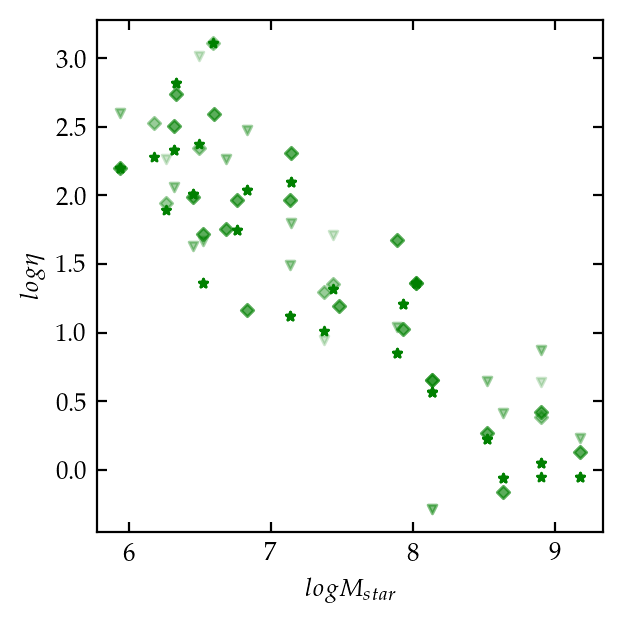

In [19]:
#now plot sn-heated gas and expelled gas (archive)
expelled = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_calculation.csv')
snheated = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_snheated_calculation.csv')

fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

#b = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_before']), c = 'brown', marker = "v", s = 10)
#p = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_1st_pericenter']), c = 'brown', marker = "D", s = 10)
#q = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_to_quench']), c = 'brown', marker = "*", s = 10)

#b1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_infall_before']), c = 'red', marker = "v", s = 10, alpha = 0.2)
#a1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_1st_pericenter']), c = 'red', marker = "D", s = 10, alpha = 0.4)
#q1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_infall_to_quench']), c = 'red', marker = "*", s = 10)


b2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_infall_before']), c = 'green', marker = "v", s = 10, alpha = 0.2)
a2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_1st_pericenter']), c = 'green', marker = "D", s = 10, alpha = 0.4)
q2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_infall_to_quench']), c = 'green', marker = "*", s = 10)

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel("$log \eta$")

Text(0, 0.5, '$log \\eta$')

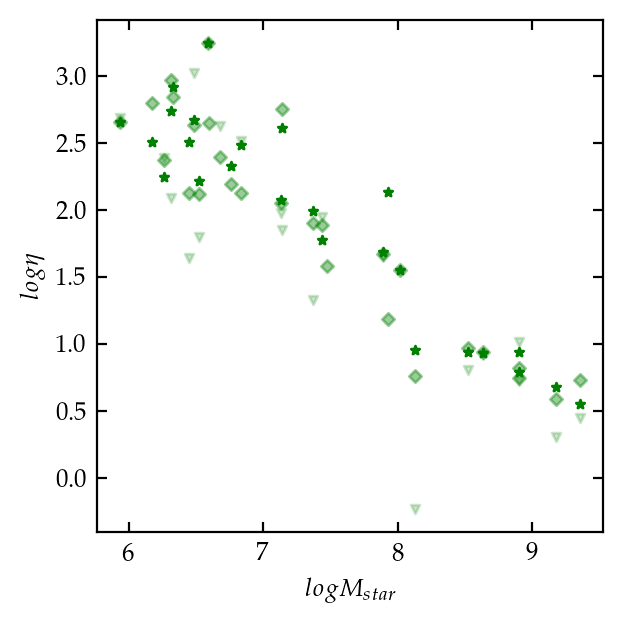

In [57]:
#now plot sn-heated gas and expelled gas 
expelled = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_calculation.csv')
snheated = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_snheated_calculation.csv')
expelledsnheated = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_snheated_calculation.csv')

fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

#b = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_before']), c = 'brown', marker = "v", s = 10)
#p = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_1st_pericenter']), c = 'brown', marker = "D", s = 10)
#q = ax.scatter(np.log10(output['M_star']), np.log10(output['mlf_infall_to_quench']), c = 'brown', marker = "*", s = 10)

#b1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_infall_before']), c = 'red', marker = "v", s = 10, alpha = 0.2)
#a1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_1st_pericenter']), c = 'red', marker = "D", s = 10, alpha = 0.4)
#q1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated['mlf_infall_to_quench']), c = 'red', marker = "*", s = 10)


b2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_infall_before']), c = 'green', marker = "v", s = 10, alpha = 0.2)
a2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_1st_pericenter']), c = 'green', marker = "D", s = 10, alpha = 0.4)
q2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled['mlf_infall_to_quench']), c = 'green', marker = "*", s = 10)

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel("$log \eta$")

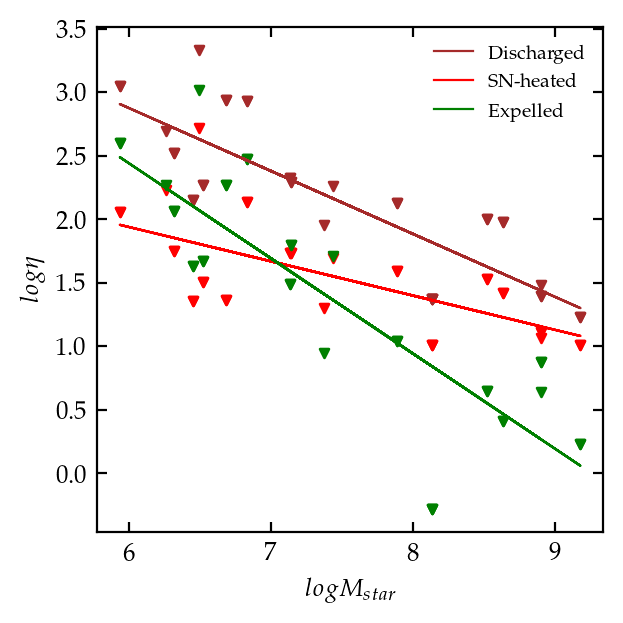

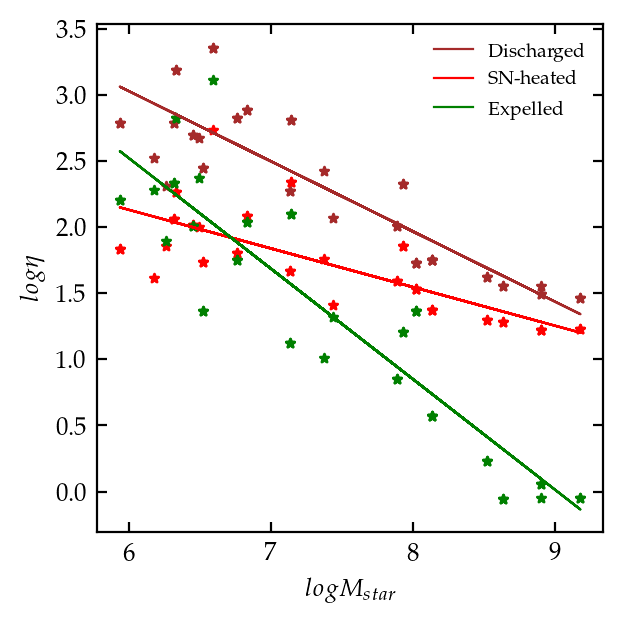

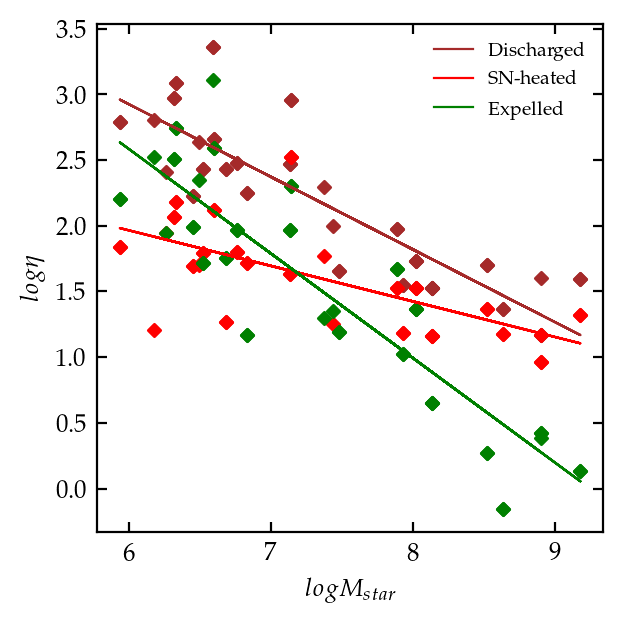

In [63]:
#linear line alignment (archive)
#plot for infall before, post infall, and 1st pericenter
#plot also for discharged only, snheated only, and expelled only
# first, log-convert the data:
from scipy.optimize import curve_fit
def func(x,s,y0):
    return y0+s*x

# the initial guess for the function parameters:
s_guess = [1]
y_guess = [3]

t_parameter = np.array(['mlf_infall_before', 'mlf_infall_to_quench', 'mlf_1st_pericenter']) #different times
m_parameter = np.array(['v', '*', 'D'])

for time, marker in zip(t_parameter, m_parameter):
    #plot different gas at the same timestep
    fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))
    xb = np.log10(output['M_star'][np.isfinite(output[time])])
    yb = np.log10(output[time][np.isfinite(output[time])])
    b = ax.scatter(np.log10(output['M_star']), np.log10(output[time]), c = 'brown', marker = marker, s = 10)
    popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
    plt.plot(np.log10(output['M_star']), func(np.log10(output['M_star']), *popt), c = 'brown', lw = 0.8, label = 'Discharged')

    xb1 = np.log10(snheated['M_star'][np.isfinite(snheated[time]) & (snheated[time] != 0)])
    yb1 = np.log10(snheated[time][np.isfinite(snheated[time]) & (snheated[time] != 0)])
    b1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated[time]), c = 'red', marker = marker, s = 10)
    popt1, pcov1 = curve_fit(func, xb1, yb1, p0=[s_guess,y_guess])
    plt.plot(np.log10(snheated['M_star']), func(np.log10(snheated['M_star']), *popt1), c = 'red', lw = 0.8, label = 'SN-heated')

    xb2 = np.log10(expelled['M_star'][np.isfinite(expelled[time])])
    yb2 = np.log10(expelled[time][np.isfinite(expelled[time])])
    b2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled[time]), c = 'green', marker = marker, s = 10)
    popt2, pcov2 = curve_fit(func, xb2, yb2, p0=[s_guess,y_guess])
    plt.plot(np.log10(expelled['M_star']), func(np.log10(expelled['M_star']), *popt2), c = 'green', lw = 0.8, label = 'Expelled')

    plt.legend(fontsize = 7)
    ax.set_xlabel("$log M_{star}$")
    ax.set_ylabel("$log \eta$")
    plt.show()

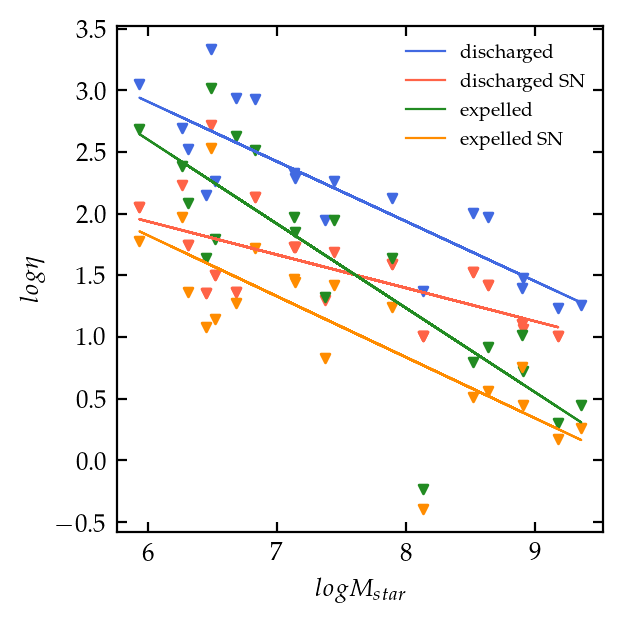

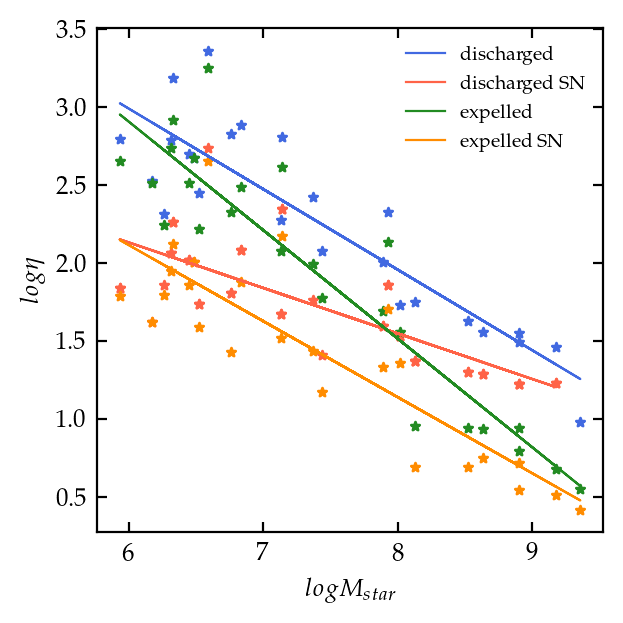

/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


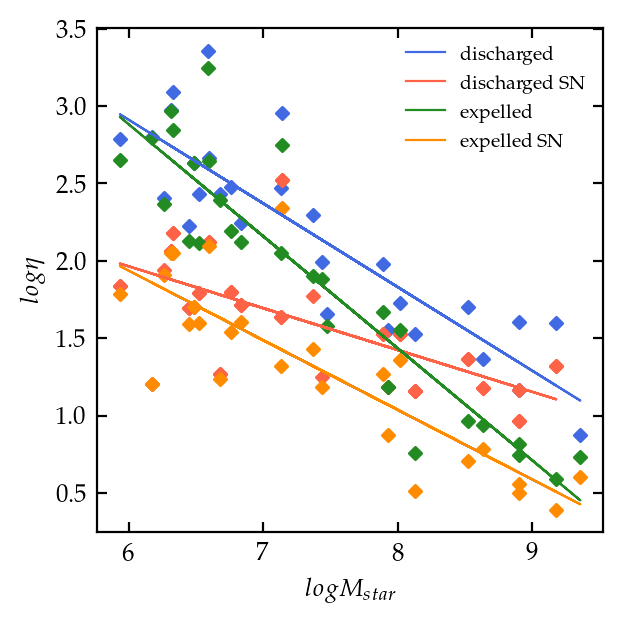

In [58]:
#linear line alignment
#plot for infall before, post infall, and 1st pericenter
#plot also for discharged only, snheated only, and expelled only
# first, log-convert the data:
from scipy.optimize import curve_fit
def func(x,s,y0):
    return y0+s*x

# the initial guess for the function parameters:
s_guess = [1]
y_guess = [3]

t_parameter = np.array(['mlf_infall_before', 'mlf_infall_to_quench', 'mlf_1st_pericenter']) #different times
m_parameter = np.array(['v', '*', 'D'])

for time, marker in zip(t_parameter, m_parameter):
    #plot different gas at the same timestep
    fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))
    xb = np.log10(output['M_star'][np.isfinite(output[time])])
    yb = np.log10(output[time][np.isfinite(output[time])])
    b = ax.scatter(np.log10(output['M_star']), np.log10(output[time]), c = 'royalblue', marker = marker, s = 10)
    popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
    plt.plot(np.log10(output['M_star']), func(np.log10(output['M_star']), *popt), c = 'royalblue', lw = 0.8, label = 'discharged')

    xb1 = np.log10(snheated['M_star'][np.isfinite(snheated[time]) & (snheated[time] != 0)])
    yb1 = np.log10(snheated[time][np.isfinite(snheated[time]) & (snheated[time] != 0)])
    b1 = ax.scatter(np.log10(snheated['M_star']), np.log10(snheated[time]), c = 'tomato', marker = marker, s = 10)
    popt1, pcov1 = curve_fit(func, xb1, yb1, p0=[s_guess,y_guess])
    plt.plot(np.log10(snheated['M_star']), func(np.log10(snheated['M_star']), *popt1), c = 'tomato', lw = 0.8, label = 'discharged SN')

    xb2 = np.log10(expelled['M_star'][np.isfinite(expelled[time])])
    yb2 = np.log10(expelled[time][np.isfinite(expelled[time])])
    b2 = ax.scatter(np.log10(expelled['M_star']), np.log10(expelled[time]), c = 'forestgreen', marker = marker, s = 10)
    popt2, pcov2 = curve_fit(func, xb2, yb2, p0=[s_guess,y_guess])
    plt.plot(np.log10(expelled['M_star']), func(np.log10(expelled['M_star']), *popt2), c = 'forestgreen', lw = 0.8, label = 'expelled')

    xb3 = np.log10(expelledsnheated['M_star'][np.isfinite(expelledsnheated[time]) & (expelledsnheated[time] != 0)])
    yb3 = np.log10(expelledsnheated[time][np.isfinite(expelledsnheated[time]) & (expelledsnheated[time] != 0)])
    b3 = ax.scatter(np.log10(expelledsnheated['M_star']), np.log10(expelledsnheated[time]), c = 'darkorange', marker = marker, s = 10)
    popt3, pcov3 = curve_fit(func, xb3, yb3, p0=[s_guess,y_guess])
    plt.plot(np.log10(expelledsnheated['M_star']), func(np.log10(expelledsnheated['M_star']), *popt3), c = 'darkorange', lw = 0.8, label = 'expelled SN')
    
    plt.legend(fontsize = 7)
    ax.set_xlabel("$log M_{star}$")
    ax.set_ylabel("$log \eta$")
    plt.savefig(f'plots/{time}_avg.pdf')
    plt.show()

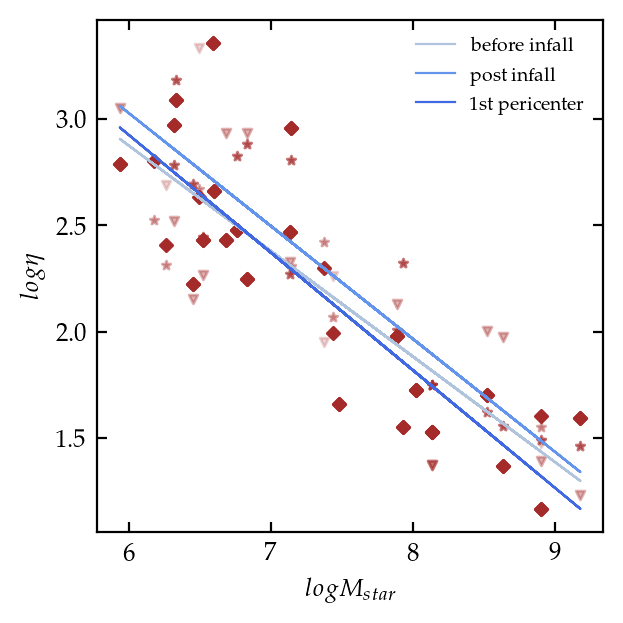

/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


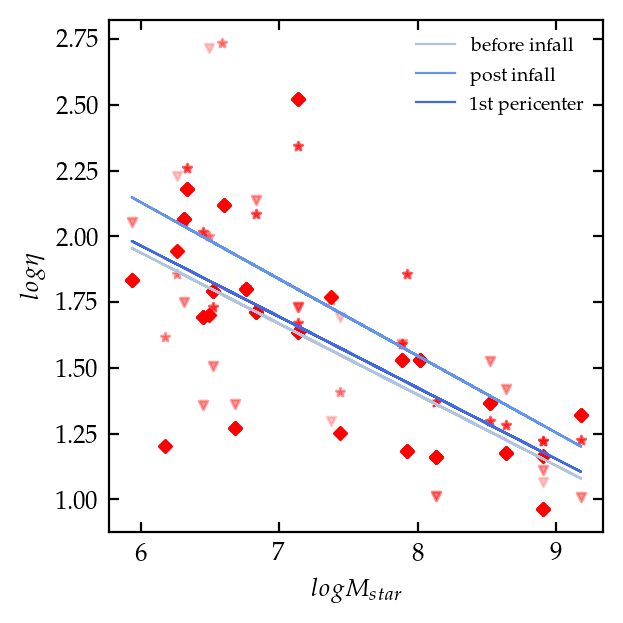

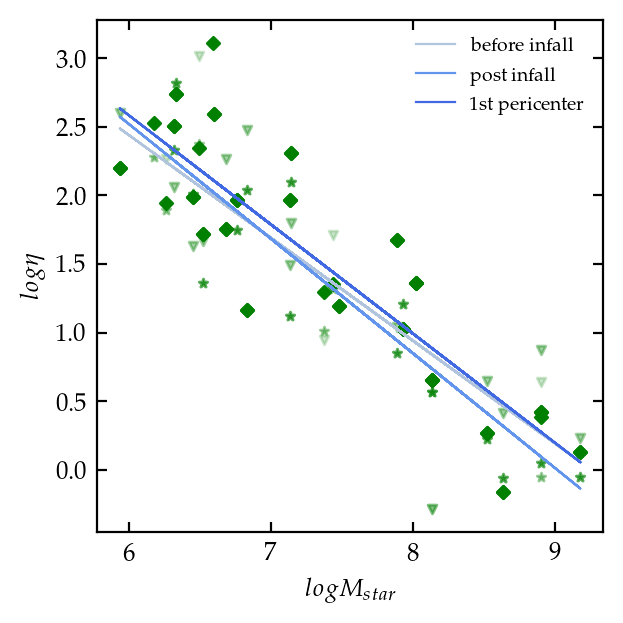

In [77]:
#archive
g_parameter = np.array(['discharged', 'snheated', 'expelled'])
c_parameter = np.array(['brown', 'red', 'green'])

for gas, color in zip(g_parameter, c_parameter):
    #plot different time for the same gas
    data = pd.DataFrame()
    if gas == 'discharged':
        data = output
    elif gas == 'snheated':
        data = snheated
    else:
        data = expelled
        
    fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))
    xb = np.log10(data['M_star'][np.isfinite(data['mlf_infall_before'])])
    yb = np.log10(data['mlf_infall_before'][np.isfinite(data['mlf_infall_before'])])
    b = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_infall_before']), c = color, marker = 'v', s = 10, alpha = 0.2)
    popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt), c = 'lightsteelblue', lw = 0.8, label = 'before infall')

    xb1 = np.log10(data['M_star'][np.isfinite(data['mlf_infall_to_quench'])])
    yb1 = np.log10(data['mlf_infall_to_quench'][np.isfinite(data['mlf_infall_to_quench'])])
    b1 = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_infall_to_quench']), c = color, marker = '*', s = 10, alpha = 0.4)
    popt1, pcov1 = curve_fit(func, xb1, yb1, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt1), c = 'cornflowerblue', lw = 0.8, label = 'post infall')

    xb2 = np.log10(data['M_star'][np.isfinite(data['mlf_1st_pericenter']) & (data['mlf_1st_pericenter'] != 0)])
    yb2 = np.log10(data['mlf_1st_pericenter'][np.isfinite(data['mlf_1st_pericenter']) & (data['mlf_1st_pericenter'] != 0)])
    b1 = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_1st_pericenter']), c = color, marker = 'D', s = 10)
    popt2, pcov2 = curve_fit(func, xb2, yb2, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt2), c = 'royalblue', lw = 0.8, label = '1st pericenter')
    plt.legend(fontsize = 7)
    ax.set_xlabel("$log M_{star}$")
    ax.set_ylabel("$log \eta$")
    plt.show()

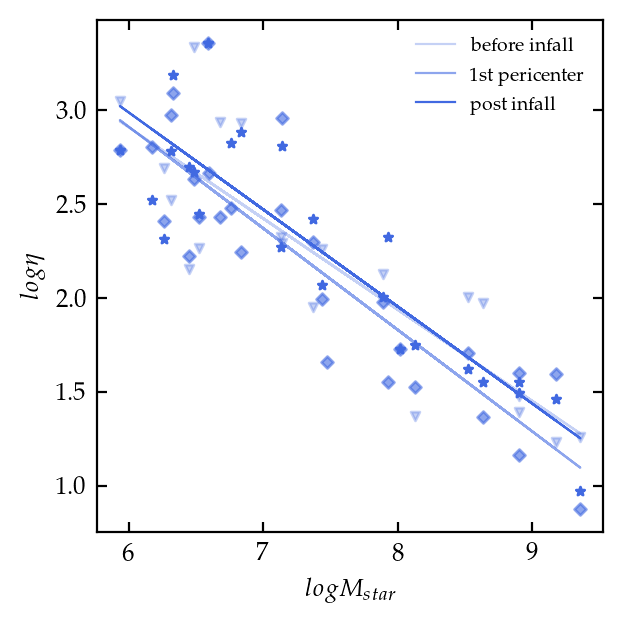

/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


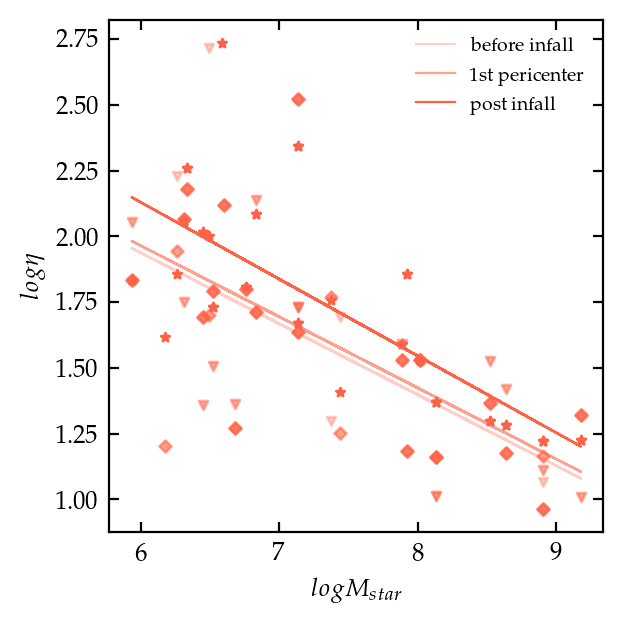

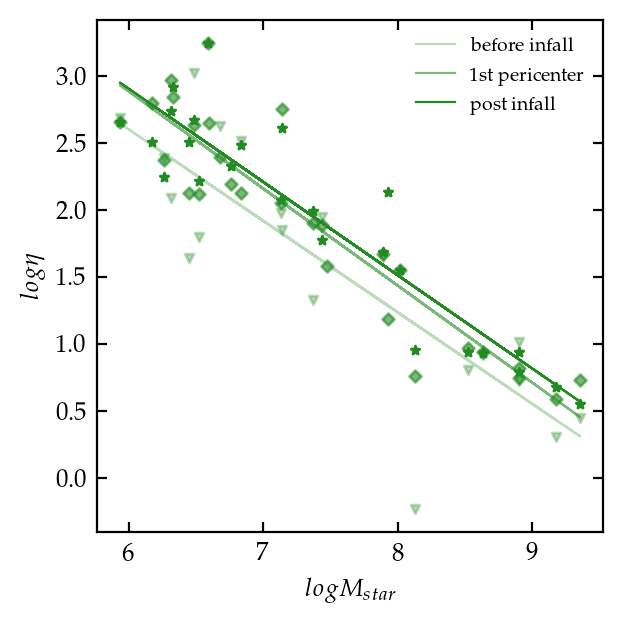

/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


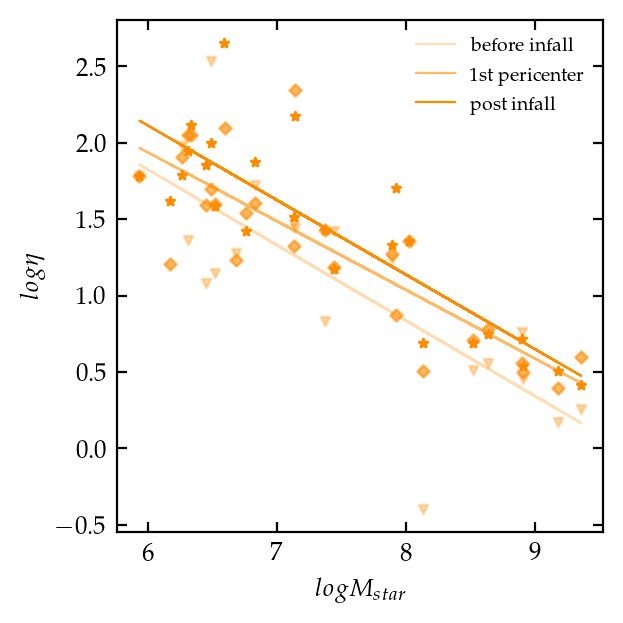

In [62]:
g_parameter = np.array(['discharged', 'snheated', 'expelled', 'expelledsnheated'])
c_parameter = np.array(['royalblue', 'tomato', 'forestgreen', 'darkorange'])

for gas, color in zip(g_parameter, c_parameter):
    #plot different time for the same gas
    data = pd.DataFrame()
    if gas == 'discharged':
        data = output
    elif gas == 'snheated':
        data = snheated
    elif gas == 'expelled':
        data = expelled
    else:
        data = expelledsnheated
        
    fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))
    xb = np.log10(data['M_star'][np.isfinite(data['mlf_infall_before'])])
    yb = np.log10(data['mlf_infall_before'][np.isfinite(data['mlf_infall_before'])])
    b = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_infall_before']), c = color, marker = 'v', s = 10, alpha = 0.3)
    popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt), c = color, lw = 0.8, label = 'before infall', alpha = 0.3)

    xb2 = np.log10(data['M_star'][np.isfinite(data['mlf_1st_pericenter']) & (data['mlf_1st_pericenter'] != 0)])
    yb2 = np.log10(data['mlf_1st_pericenter'][np.isfinite(data['mlf_1st_pericenter']) & (data['mlf_1st_pericenter'] != 0)])
    b1 = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_1st_pericenter']), c = color, marker = 'D', s = 9, alpha = 0.6)
    popt2, pcov2 = curve_fit(func, xb2, yb2, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt2), c = color, lw = 0.8, label = '1st pericenter', alpha = 0.6)
    
    xb1 = np.log10(data['M_star'][np.isfinite(data['mlf_infall_to_quench'])])
    yb1 = np.log10(data['mlf_infall_to_quench'][np.isfinite(data['mlf_infall_to_quench'])])
    b1 = ax.scatter(np.log10(data['M_star']), np.log10(data['mlf_infall_to_quench']), c = color, marker = '*', s = 10)
    popt1, pcov1 = curve_fit(func, xb1, yb1, p0=[s_guess,y_guess])
    plt.plot(np.log10(data['M_star']), func(np.log10(data['M_star']), *popt1), c = color, lw = 0.8, label = 'post infall')

    plt.legend(fontsize = 7)
    ax.set_xlabel("$log M_{star}$")
    ax.set_ylabel("$log \eta$")
    plt.savefig(f'plots/{gas}_mlf_avg.pdf')
    plt.show()

## Fraction of Mass Loss by SN, Expelled

We have seen how mass loading factor decreases as galaxy becomes massive. Another way to look at this is fraction of gas loss by supernovae, and whether or not being SN-heated causes the gas to be further expelled.

Note: below, I was foolish that I try to recalculate the total mass outflow per timestep, in order to calculate the fraction of expelled over discharged. But since eta is Moutflow_rate/SFR and dividing expelled eta by discharged eta can cancel SFR, it will end up with Mout_rate_expelled/Mout_rate_discharged and everything is good. But I keep these functions in case I need them in the future.

In [82]:
#fraction of expelled gas over discharged versus mstar
def calc_expelled_mass(key):
    '''
    This function calculates mass of gas outflow by 
    taking expelled dataframe
    '''

    #load expelled (permanently) particle dataframe here
    preexpelled, expelled = read_one_expelled(key)
    
    #sum up discharged particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(expelled.time)
    Mout_arr = np.array([])

    #iterate thru each timestep
    for i, time in enumerate(time_arr):
        #filter out
        filtered = expelled[expelled.time == time]
        #sum up mass exited at this timestep
        Mout = np.sum(filtered.mass)
        Mout_arr = np.append(Mout_arr, Mout)

    #to avoid error in calculation, remove NaN and inf if any
    Mout_arr = Mout_arr[np.isfinite(Mout_arr)]
    time_arr = time_arr[np.isfinite(Mout_arr)]
    
    return time_arr, Mout_arr

def calc_discharged_mass(key):
    '''
    This function calculates mass of gas outflow by 
    taking discharged and snheated dataframe
    '''

    #load expelled (permanently) particle dataframe here
    predischarged, discharged = read_one_discharged(key)
    snheated = discharged[discharged['snHeated'] == True]
    nonheated = discharged[discharged['snHeated'] == False]
    
    #sum up discharged particles over time for one satellite
    #while doing so, match up SFR to the same snapshot
    time_arr = np.unique(discharged.time)
    Mout_arr, snMout_arr = np.array([]), np.array([])

    #iterate thru each timestep
    for i, time in enumerate(time_arr):
        #filter out
        filtered = discharged[discharged.time == time]
        snfiltered = snheated[snheated.time == time]
        #sum up mass exited at this timestep
        Mout = np.sum(filtered.mass)
        snMout = np.sum(snfiltered.mass)
        Mout_arr = np.append(Mout_arr, Mout)
        snMout_arr = np.append(snMout_arr, snMout)

    #to avoid error in calculation, remove NaN and inf if any
    Mout_arr = Mout_arr[np.isfinite(Mout_arr)]
    snMout_arr = Mout_arr[np.isfinite(snMout_arr)]
    time_arr = time_arr[np.isfinite(Mout_arr)]
    sntime_arr = time_arr[np.isfinite(snMout_arr)]
    
    return time_arr, sntime_arr, Mout_arr, snMout_arr


(0.0, 0.7)

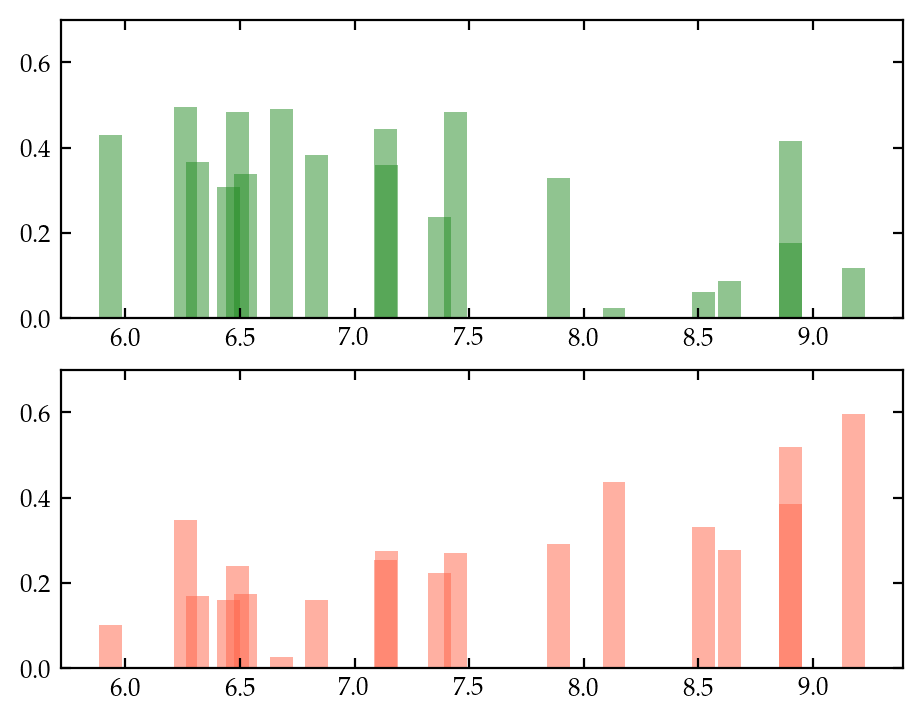

In [103]:
#plot the fraction of expelled gas over discharged gas, in terms of different stellar masses (archive)
#load the dataframes
output = pd.read_csv('/home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv')
expelled = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_calculation.csv')
snheated = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_snheated_calculation.csv')

fig, axs = plt.subplots(2,1,dpi=200,figsize=(4.5,3.5))
temp = pd.DataFrame()

#ensure that a new column will be inherited once concatenating
###fracExp = {'fracExp': ''}
###fracSN = {'fracSN': ''}
###expelled = expelled.join(pd.DataFrame(columns=fracExp))
###snheated = snheated.join(pd.DataFrame(columns=fracSN))

#identify each satellite by haloid and sim name, then calculate the fraction
for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    #filter out
    exp = expelled[(expelled.sim == sim) & (expelled.haloid == haloid)][:1]
    sn = snheated[(snheated.sim == sim) & (snheated.haloid == haloid)][:1]
    #find mlf
    mlf_exp = expelled[(expelled.sim == sim) & (expelled.haloid == haloid)]['mlf_infall_before'].min()
    mlf_sn = snheated[(snheated.sim == sim) & (snheated.haloid == haloid)]['mlf_infall_before'].min()
    mlf_dis = output[(output.sim == sim) & (output.haloid == haloid)]['mlf_infall_before'].min()
    fracE = mlf_exp/mlf_dis #M_out_rate_exp/M_out_rate_dis
    fracSN = mlf_sn/mlf_dis

    import warnings
    pd.options.mode.chained_assignment = None #this will supress SettingWithCopyWarning
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        exp['fracExp'] = fracE
        exp['fracSN'] = fracSN
    pd.options.mode.chained_assignment = "raise"
    
    #save
    temp = pd.concat([temp, exp])

axs[0].bar(np.log10(temp['M_star']), temp['fracExp'], width = 0.1, color = 'forestgreen', alpha = 0.5)
axs[1].bar(np.log10(temp['M_star']), temp['fracSN'], width = 0.1, color = 'tomato', alpha = 0.5)
axs[0].set_ylim(0,0.7)
axs[1].set_ylim(0,0.7)

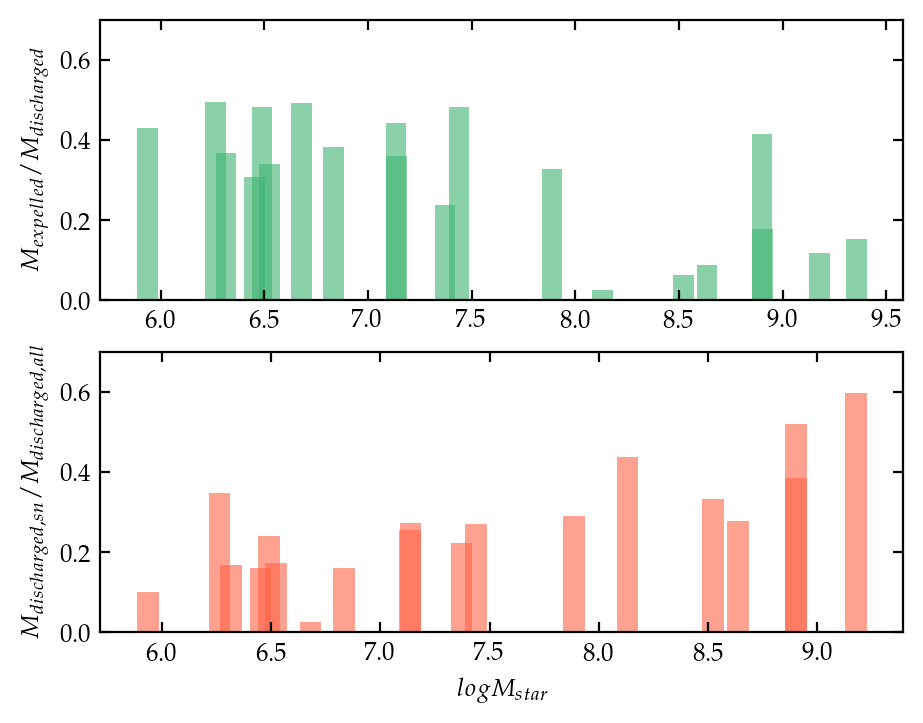

In [65]:
#plot the fraction of expelled gas over discharged gas, in terms of different stellar masses
#load the dataframes
output = pd.read_csv('/home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv')
expelled = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_expelled_calculation.csv')
snheated = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_mlf_snheated_calculation.csv')

fig, axs = plt.subplots(2,1,dpi=200,figsize=(4.5,3.5))
temp = pd.DataFrame()

#ensure that a new column will be inherited once concatenating
fracExp = {'fracExp': ''}
fracSN = {'fracSN': ''}
expelled = expelled.join(pd.DataFrame(columns=fracExp))
###snheated = snheated.join(pd.DataFrame(columns=fracSN))

#identify each satellite by haloid and sim name, then calculate the fraction
for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    #filter out
    exp = expelled[(expelled.sim == sim) & (expelled.haloid == haloid)][:1]
    sn = snheated[(snheated.sim == sim) & (snheated.haloid == haloid)][:1]
    #find mlf
    mlf_exp = expelled[(expelled.sim == sim) & (expelled.haloid == haloid)]['mlf_infall_before'].min()
    mlf_sn = snheated[(snheated.sim == sim) & (snheated.haloid == haloid)]['mlf_infall_before'].min()
    mlf_dis = output[(output.sim == sim) & (output.haloid == haloid)]['mlf_infall_before'].min()
    fracE = mlf_exp/mlf_dis #M_out_rate_exp/M_out_rate_dis
    fracSN = mlf_sn/mlf_dis

    import warnings
    pd.options.mode.chained_assignment = None #this will supress SettingWithCopyWarning
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        exp['fracExp'] = fracE
        exp['fracSN'] = fracSN
    pd.options.mode.chained_assignment = "raise"
    
    #save
    temp = pd.concat([temp, exp])

axs[0].bar(np.log10(temp['M_star']), temp['fracExp'], width = 0.1, color = 'mediumseagreen', alpha = 0.6)
axs[1].bar(np.log10(temp['M_star']), temp['fracSN'], width = 0.1, color = 'tomato', alpha = 0.6)
axs[0].set_ylim(0,0.7)
axs[1].set_ylim(0,0.7)
axs[1].set_xlabel("$log M_{star}$")
axs[0].set_ylabel('$M_{expelled} / M_{discharged}$')
axs[1].set_ylabel('$M_{discharged, sn} / M_{discharged, all}$')
plt.savefig(f'plots/fracSN_fracExp_NEW.pdf')
plt.show()

In [143]:
temp.head()

haloid  quenched   tquench  tquench_lower  tquench_upper   tinfall  \
0      10     False       NaN            NaN            NaN  5.602745   
1      12      True  4.740687       5.191869      -0.000097  5.602745   
4     249      True  3.878726       3.878726       3.878726  5.602745   
5     251      True  6.464608       6.464608       6.464608  6.895686   
6      27      True  1.649749       1.649749      -0.000097  7.326666   

   tinfall_lower  tinfall_upper        M_star   sim  ...  is_small  \
0       5.602745       5.602745  1.353274e+08  h148  ...     False   
1       5.602745       5.602745  1.043767e+08  h148  ...     False   
4       5.602745       5.191967  2.063790e+06  h148  ...      True   
5       6.895686       6.895686  2.149496e+06  h148  ...      True   
6       7.326666       7.326666  8.415728e+07  h148  ...     False   

   1st p_time  min p_time  mlf_infall  mlf_infall_after  mlf_infall_before  \
0    9.060013   13.369817    9.580018          5.774408           0.517459   
1    8.608831    8.608831   14.061006         20.244221                NaN   
4    9.490994   12.507856  103.829280         93.086105         115.679431   
5    7.336092   11.214915  458.121621        549.526572                NaN   
6    7.039793   11.645896   11.872858         10.941043                NaN   

   mlf_infall_to_quench  mlf_1st_pericenter  mlf_min_pericenter   fracExp  
0              3.712475            4.505872            2.385117  0.021976  
1             23.103295           23.103295           23.103295       NaN  
4            215.602633          321.387268                 NaN  0.347754  
5            661.967355          549.526572                 NaN       NaN  
6             16.181974           10.630437            3.009625       NaN  

[5 rows x 25 columns]

In [104]:
print(len(expelled['mlf_infall_before']), len(output['mlf_infall_before']))

49 52


### Specific Star Formation Rate

In [205]:
#this is from base.py
def read_timescales():
    '''
    -> Function to read in the data file which contains quenching and infall times.
    '''
    #--------------------------------#
    
    data = []
    with open(f'{rootPath}Justice_League_Code/Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 1.0710271281245684e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 1.7466524592390193e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 1.8260385919484286e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 5.584401576170291e-11
> Returning <tracked_particle> dataset <
sSFR_quench is 0.0
sSFR_pericenter is 1.7104762084101277e-10


/tmp/ipykernel_35910/1003427011.py:74: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(mstar), np.log10(sSFR_quench), marker = "*", color = 'mediumpurple', s = 10)


> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 1.6369549722529514e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 3.222737047677066e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 8.215728097422878e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 1.0411707634275281e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 3.722322249756874e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 5.4816186748219786e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 3.0707833884307985e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 6.017461773411399e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is nan
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 7.543062483415327e-11
> Re

/tmp/ipykernel_35910/1003427011.py:67: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(mstar), np.log10(sSFR_infall), marker = "v", color = 'mediumseagreen', s = 10)
/tmp/ipykernel_35910/1003427011.py:74: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(mstar), np.log10(sSFR_quench), marker = "*", color = 'mediumpurple', s = 10)


sSFR_quench is 0.0
sSFR_pericenter is 1.18905193626977e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 2.5143461039969737e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 2.0763120712706607e-10
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 2.7595274307410746e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 4.93344892563558e-12
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 2.3403462625997892e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 3.6345311884444805e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 7.37656094541793e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 4.3919313581289866e-11
> Returning <tracked_particle> dataset <
sSFR_quench is nan
sSFR_pericenter is 2.5174158727107425e-11
> Returning <tracked_partic

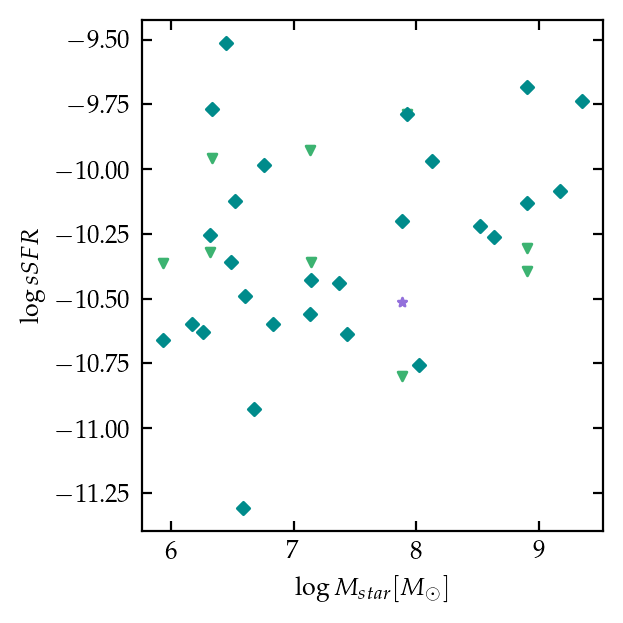

In [136]:
# specific SFR versus Mstar
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

#pandas data frame
data = pd.read_csv('/home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv')
#remove the duplicates if any
data = data.drop_duplicates(subset=['sim','haloid'], keep='last')

fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

#initialize SFR arrays and sSFR arrays
sfrinfalls,sfrquenches,sfrpericenters = np.array([]),np.array([]),np.array([])
sSFRinfalls,sSFRquenches,sSFRpericenters = np.array([]),np.array([]),np.array([])
for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    
    #calculate and load SFR data
    sfr1, bins = calc_sfr(key) #binned based on time
    bincenters = 0.5*(bins[1:] + bins[:-1])
    
    #read mstar data
    #read infall, quench, pericenter time
    tinfall = data[(data.sim == sim) & (data.haloid == haloid)]['tinfall'].mean()
    tquench = data[(data.sim == sim) & (data.haloid == haloid)]['tquench'].mean()
    tpericenter = data[(data.sim == sim) & (data.haloid == haloid)]['1st p_time'].mean()
    mstar = data[(data.sim == sim) & (data.haloid == haloid)]['M_star'].mean()
    #print(tinfall, tquench, mstar)
    
    #find the right sfr near infall, quench, at 1st pericentric passage, if any
    from math import isclose
    #initialize SFRs
    sfrinfall,sfrquench,sfrpericenter = np.nan, np.nan, np.nan

    #find sfr at time at infall
    sfrinfall = sfr1[np.abs(bincenters-tinfall).argmin()] #pick the bincenter that is closest to t
    #but close enough to be within 1 Gyr
    if isclose(bincenters[np.abs(bincenters-tinfall).argmin()],tinfall,abs_tol=1):
        pass 
    else:
        sfrinfall = np.nan #no close bincenters

    #find sfr at time at quench
    sfrquench = sfr1[np.abs(bincenters-tquench).argmin()] #pick the bincenter that is closest to t
    if isclose(bincenters[np.abs(bincenters-tquench).argmin()],tquench,abs_tol=1):
        pass 
    else:
        sfrquench = np.nan #not yet quenched

    #find sfr at time at pericentric distance
    sfrpericenter = sfr1[np.abs(bincenters-tpericenter).argmin()] #pick the bincenter that is closest to t
    if isclose(bincenters[np.abs(bincenters-tpericenter).argmin()],tpericenter,abs_tol=1):
        pass
    else:
        sfrpericenter = np.nan #no close bincenters

    #save SFRs at different times
    sfrinfalls = np.append(sfrinfalls, sfrinfall)
    sfrquenches = np.append(sfrquenches, sfrquench)
    sfrpericenters = np.append(sfrpericenters, sfrpericenter)
        
    #calculate then plot specific SFR versus Mstar
    try:
        sSFR_infall = sfrinfall/mstar
        ax.scatter(np.log10(mstar), np.log10(sSFR_infall), marker = "v", color = 'mediumseagreen', s = 10)
    except:
        print(f'No sSFR at infall calculated for {key}')
        sSFR_infall = np.nan
    try:
        sSFR_quench = sfrquench/mstar
        print('sSFR_quench is', sSFR_quench)
        ax.scatter(np.log10(mstar), np.log10(sSFR_quench), marker = "*", color = 'mediumpurple', s = 10)
    except:
        print(f'No sSFR at quench calculated for {key}')
        sSFR_quench = np.nan
    try:
        sSFR_pericenter = sfrpericenter/mstar
        print('sSFR_pericenter is', sSFR_pericenter)
        ax.scatter(np.log10(mstar), np.log10(sSFR_pericenter), marker = "D", color = 'darkcyan', s = 10)
    except:
        print(f'No sSFR at 1st pericentric position calculated for {key}')
        sSFR_pericenter = np.nan
        
    #save sSFRs at different times
    sSFRinfalls = np.append(sSFRinfalls, sSFR_infall)
    sSFRquenches = np.append(sSFRquenches, sSFR_quench)
    sSFRpericenters = np.append(sSFRpericenters, sSFR_pericenter)
    
#append results to a parent dataframe
data['SFRinfall'] = sfrinfalls.tolist()
data['SFRquench'] = sfrquenches.tolist()
data['SFRpericenter'] = sfrpericenters.tolist()
data['sSFRinfall'] = sSFRinfalls.tolist()
data['sSFRquench'] = sSFRquenches.tolist()
data['sSFRpericenter'] = sSFRpericenters.tolist()

#save this DataFrame to csv
filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/sSFR_calculation.csv'
data.to_csv(filepath, index = False)

#show the plot
ax.set_xlabel(r'$\log M_{star} [M_{\odot}]$')
ax.set_ylabel('$\log sSFR$')
plt.show()

/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


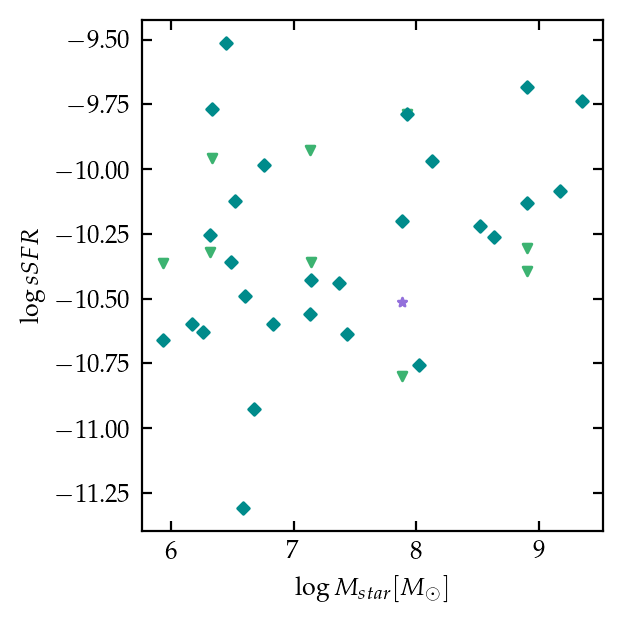

In [66]:
#show the plot
fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/sSFR_calculation.csv')

ax.scatter(np.log10(data.M_star), np.log10(data.sSFRinfall), color = 'mediumseagreen', marker = "v", 
           label = 'pre infall', s = 10)
ax.scatter(np.log10(data.M_star), np.log10(data.sSFRquench), color = 'mediumpurple', 
           label = 'post infall', marker = "*", s = 10)
ax.scatter(np.log10(data.M_star), np.log10(data.sSFRpericenter), color = 'darkcyan', 
           label = '1st pericentric', marker = "D", s = 9)

#show the plot
ax.set_xlabel(r'$\log M_{star} [M_{\odot}]$')
ax.set_ylabel('$\log sSFR$')
plt.savefig(f'plots/sSFR_avg.pdf')
plt.show()

### Find time at reaching 1 Rvir from host
Also summarize infalling information into csv file, saved as ``all-satellite-information-2.csv``. 

In [51]:
#append time at 1 Rvir distance froom sat to host to sSFR calc .csv file
#then I can call it all-satellite-information.csv
import time
start = time.time()

data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/sSFR_calculation.csv')
output = pd.DataFrame()

for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    
    data_local = data[(data.sim==sim)&(data.haloid==haloid)]
    
    #calc r_rel
    r_rel, r_time = calc_r_rel(key)
    #find the r_rel distance, 1st time falling into 1 Rvir
    ##id_ = (np.abs(r_rel - 1.00)).argmin() <- this might pick up the later timestep
    from math import isclose
    if any(np.isclose(r_rel, 1.00, atol=0.05)):
        #pick the 1st time reaching 1 Rvir
        id_ = np.where(np.isclose(r_rel, 1.00, atol=0.05))[0][0]
        if r_time[id_] > float(data_local['1st p_time']): #probably picking up later one by mistake
            id_ = np.where(np.isclose(r_rel, 1.00, atol=0.16))[0][0]
    else:
        #worst case is 1.15 Rvir for the closest 
        id_ = np.where(np.isclose(r_rel, 1.00, atol=0.16))[0][0]
        
    #save it as 1Rvir_from_
    data_local['1Rvir_from_Host']=r_rel[id_]
    data_local['t_1Rvir_from_Host']=r_time[id_]
    
    #concat
    output = pd.concat([output, data_local])
  
#save into csv file
filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/all-satellite-information-2.csv'
import os    
if os.path.exists(filepath):
    output.to_csv(filepath, mode='a', index = False, header = False)

else:
    #create a file with the appropriate header
    output.to_csv(filepath, index = False)

end = time.time()
print("Program finished execution: ", end - start, " s")

> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


> Returning <tracked_particle> dataset <
Program finished execution:  231.75795817375183  s


/tmp/ipykernel_25069/541933385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['1Rvir_from_Host']=r_rel[id_]
/tmp/ipykernel_25069/541933385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['t_1Rvir_from_Host']=r_time[id_]


In [52]:
#look at what's inside
data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/all-satellite-information-2.csv')
for i in np.arange(len(data)):
    print(data['sim'][i], data['haloid'][i], "1 Rvir: ", data['1Rvir_from_Host'][i], "Time: ", data['t_1Rvir_from_Host'][i])

h148 10 1 Rvir:  1.106245352008218 Time:  7.767072171295828
h148 12 1 Rvir:  1.0584443910608203 Time:  9.490993692946342
h148 2 1 Rvir:  1.0344128094176492 Time:  12.50785635584716
h148 249 1 Rvir:  0.995559606614458 Time:  8.198052551708967
h148 251 1 Rvir:  0.8797123892812823 Time:  6.905111410469933
h148 27 1 Rvir:  0.8468321750636565 Time:  6.474131030057089
h148 282 1 Rvir:  0.9221271136285748 Time:  5.181189888818481
h148 3 1 Rvir:  1.0349475593690542 Time:  9.490993692946342
h148 34 1 Rvir:  0.9721988250949668 Time:  9.060013312533592
h148 38 1 Rvir:  1.1530863897063293 Time:  7.336091790882829
h148 4 1 Rvir:  0.9629067275858326 Time:  12.07687597543439
h148 55 1 Rvir:  1.0260063286239385 Time:  10.35295445377185
h148 6 1 Rvir:  0.9287413408500084 Time:  11.645895595020118
h148 65 1 Rvir:  0.9614022199002548 Time:  8.198052551708967
h229 14 1 Rvir:  1.002991290359749 Time:  8.736778027163657
h229 18 1 Rvir:  0.997857976632524 Time:  7.767072171235469
h229 20 1 Rvir:  1.113125916

In [47]:
r_rel, r_time = calc_r_rel('h148_27')
for i in np.arange(len(r_rel)):
    print(r_rel[i], r_time[i])

> Returning <tracked_particle> dataset <
2.2103658239202066 4.750209508400876
1.8331107994847478 5.181189888818481
1.3497668022253355 5.868064870101596
0.8468321750636565 6.474131030057089
0.6340778585338556 6.905111410469933
0.6203884108400892 7.039792779348961
0.6975298041770452 7.336091790882829
0.9232240598176651 7.767072171295828
1.091418146280528 8.198052551708967
1.1739649902635783 8.608830726788982
1.2534502729372659 9.060013312533592
1.2827908398614365 9.490993692946342
1.2451705345440711 9.921974073359097
1.1449279628226885 10.35295445377185
0.9218126746491585 10.767099663076081
0.912496971635219 10.783934834188601
0.657076926143645 11.21491521460295
0.3525507004111439 11.645895595020118
0.4127386847030555 12.07687597543439
0.46237838106618917 12.150950728317822
0.6955477398348693 12.507856355847158
0.9061341116292176 12.938836736259919
1.0405205331107077 13.369817116672673
1.1109587032543389 13.800797497085433


In [56]:
data[(data.sim=='h242')&(data.haloid==21)].keys()

Index(['haloid', 'quenched', 'tquench', 'tquench_lower', 'tquench_upper',
       'tinfall', 'tinfall_lower', 'tinfall_upper', 'M_star', 'sim', 'M_gas',
       'Mass', 'Rvir', 'is_massive', 'is_intermediate', 'is_small',
       '1st p_time', 'min p_time', 'mlf_infall', 'mlf_infall_after',
       'mlf_infall_before', 'mlf_infall_to_quench', 'mlf_1st_pericenter',
       'mlf_min_pericenter', 'SFRinfall', 'SFRquench', 'SFRpericenter',
       'sSFRinfall', 'sSFRquench', 'sSFRpericenter', '1Rvir_from_Host',
       't_1Rvir_from_Host'],
      dtype='object')

In [50]:
dataold = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/sSFR_calculation.csv')
dataold[(dataold.sim=='h148')&(dataold.haloid==27)]

haloid  quenched   tquench  tquench_lower  tquench_upper   tinfall  \
5      27      True  1.649749       1.649749      -0.000097  7.326666   

   tinfall_lower  tinfall_upper        M_star   sim  ...  mlf_infall_before  \
5       7.326666       7.326666  8.415728e+07  h148  ...                NaN   

   mlf_infall_to_quench  mlf_1st_pericenter  mlf_min_pericenter  SFRinfall  \
5            210.828099           35.687857           59.717824   0.013776   

   SFRquench  SFRpericenter    sSFRinfall  sSFRquench  sSFRpericenter  
5        NaN       0.013776  1.636955e-10         NaN    1.636955e-10  

[1 rows x 30 columns]

In [13]:
#find the r_rel distance, closest to 1 Rvir
r_rel, r_time = calc_r_rel('h148_10')

idx = (np.abs(r_rel - 1.00)).argmin()
r_rel[idx]

> Returning <tracked_particle> dataset <


0.9947219801530076

Here, I moved onto averaging the fracSN before and after 1 Rvir and around 1st pericentric distance, just like I did with mass loading factor. Those calculations and plots are conducted in ```snheating.ipynb```.

### Miscellaneous

In [329]:
predischarged, discharged = read_one_discharged('h148_10')
preexpelled, expelled = read_one_expelled('h148_10')

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning (accreted, reaccreted) for satellite h148_10 <


In [7]:
output = pd.read_csv('/home/watanabe/watanabe_MAP/SNe-heated_Gas_Flow/SNeData/avg_mlf_calculation.csv')
output.keys()

Index(['haloid', 'quenched', 'tquench', 'tquench_lower', 'tquench_upper',
       'tinfall', 'tinfall_lower', 'tinfall_upper', 'M_star', 'sim', 'M_gas',
       'Mass', 'Rvir', 'is_massive', 'is_intermediate', 'is_small',
       '1st p_time', 'min p_time', 'mlf_infall', 'mlf_infall_after',
       'mlf_infall_before', 'mlf_infall_to_quench', 'mlf_1st_pericenter',
       'mlf_min_pericenter'],
      dtype='object')

> Returning <tracked_particle> dataset <
> Returning (sfr) variable for h148_10 <


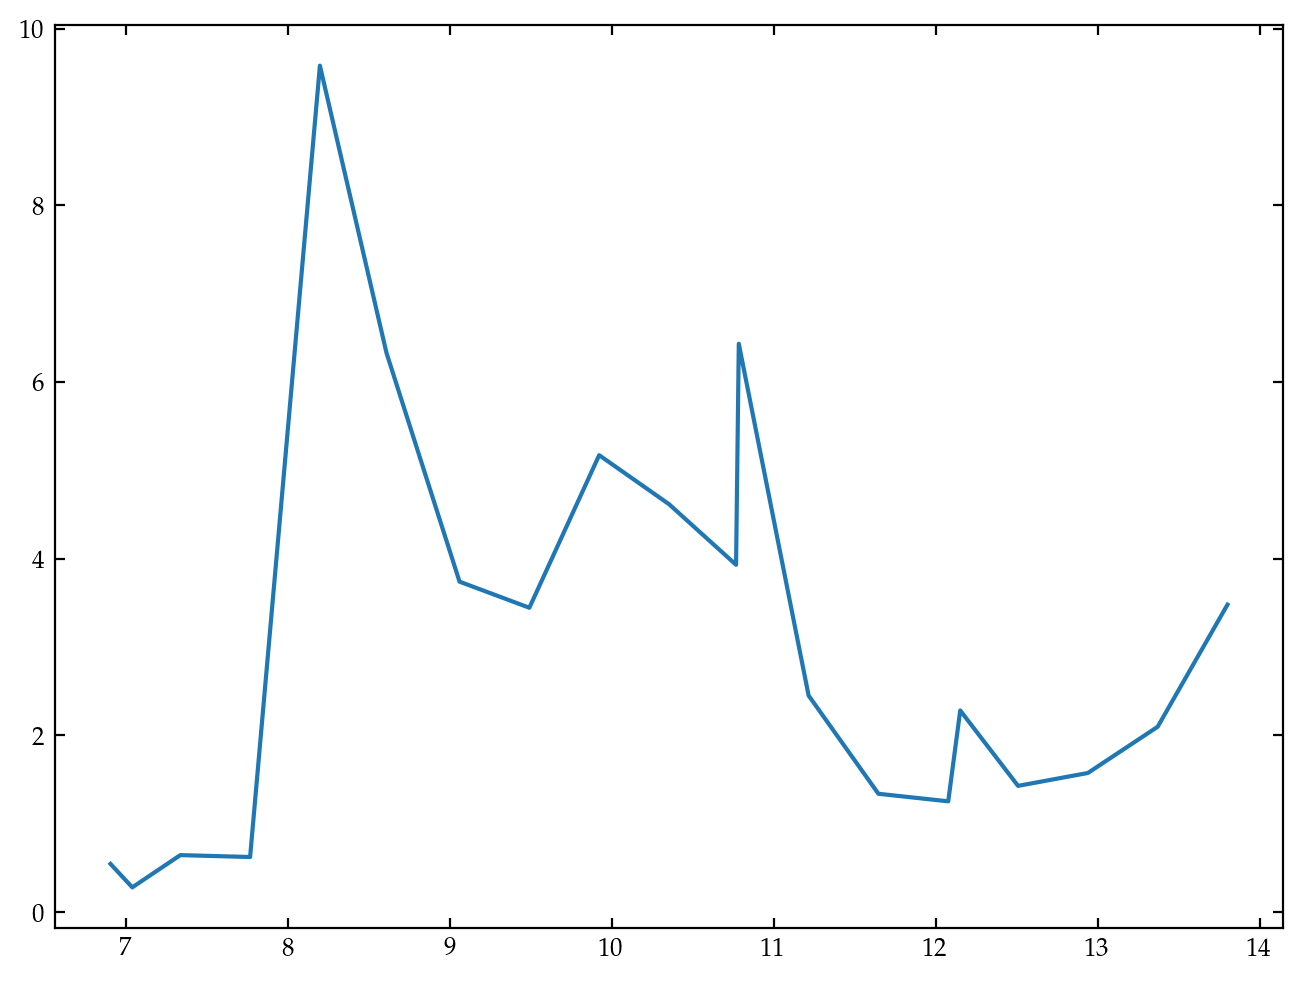

In [331]:
#sum up discharged particles over time for one satellite
#while doing so, match up SFR to the same snapshot
time_arr = np.unique(expelled.time)
time_arr_prev = np.unique(preexpelled.time)
Mout_arr,Mout_rate_arr,sfrs = np.array([]), np.array([]), np.array([])

#calculate and load SFR data
sfr1, bins = calc_sfr(key) #binned based on time
bincenters = 0.5*(bins[1:] + bins[:-1])

#iterate thru each timestep
for i, (time, time_prev) in enumerate(zip(time_arr, time_arr_prev)):
    #filter out
    filtered = expelled[expelled.time == time]
    #sum up mass exited at this timestep
    Mout = np.sum(filtered.mass)
    Mout_arr = np.append(Mout_arr, Mout)
    Mout_rate_arr = np.append(Mout_rate_arr, Mout/((time-time_prev)*1e9)) # [Msol/yr]

    #find sfr at time
    if ~isclose(sfr1[i], 0, abs_tol = 1e-5):
        if isclose(bincenters[i], time, abs_tol=1e-2):
            sfr = sfr1[i]
        else:
            try:
                sfr = sfr1[np.where(bincenters > time)[0][0]] #pick the first bincenters that is close to t
            except:
                sfr = sfr1[-1] #no close bincenters, probably the last item
    else:
        sfr = 0.00001 #sfr is almost zero
    sfrs = np.append(sfrs, sfr)

#mass loading factor, mass outflow/SFR
eta = Mout_rate_arr/sfrs # [unitless]

#to avoid error in calculation, remove NaN if any
eta = eta[~np.isnan(eta)]
    
plt.plot(time_arr, eta)

h148_10 started infalling at 8.198052054378461, before is 29.00830947813339, now is 50.361947233198826, and after is 22.606450758574226
Could not calculate mlf_quench for h148_10
h148_10 is at closest to the host at 13.369817116672673, and mass loading factor is 28.530269398144068

In [168]:
path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/discharged_particles.hdf5'
path2 = f'{rootPath}SNe-heated_Gas_Flow/SNeData/reaccreted_particles.hdf5'

key = 'h242_10'
discharged = pd.read_hdf(path, key=key)
reaccreted = pd.read_hdf(path2, key=key)


In [166]:
discharged['pid']

7299719      165342
6285788      171482
6895323      171482
7501256      171482
7097738      171611
             ...   
6895302    10694280
4026094    10694775
4852458    10694775
5673636    10694775
7299706    10858293
Name: pid, Length: 399056, dtype: int64

In [171]:
reaccreted['pid']

6489239        1.714820e+05
7097737        1.714820e+05
recycleTime    3.232353e-01
snHeated       1.000000e+00
7299723        1.716110e+05
                   ...     
recycleTime    3.232353e-01
snHeated       1.000000e+00
7501240        1.085829e+07
recycleTime    3.232353e-01
snHeated       1.000000e+00
Name: pid, Length: 440513, dtype: float64

In [167]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'snHeated'],
      dtype='object')

Note from 05/09/24:
Here I realized how Leo calculated expelled gas overlooks some of the reaccreted expelled gas.

In [55]:
# y array is discharged
y = np.array([1,1,1,2,4,1,2,5,6,2,4]) #1, 4, 6 is expelled at last step, 2, 5 reaccreted
# x array is reaccreted
x = np.array([1,1,1,2,2,2,4,5])
# What we would like
filter_expelled = np.array([0,0,0,0,0,1,0,0,1,0,1])

In [58]:
index = np.argsort(x)
print("index (to sort x): ", index)
sorted_x = x[index]  # Sorted list of ids reaccreted
print("sorted x array: ", sorted_x) # [1,1,1,2,2,2,4,5]

sorted_index = np.searchsorted(sorted_x, y)
print("sorted_index (index of y array corresponding to sorted x): ", sorted_index) # [0 0 0 3 6 0 3 7 8 3 6]
yindex = np.take(index, sorted_index, mode="clip")
print(yindex) # [0 0 0 3 6 0 3 7 7 3 6] index 8 changed to 7 because 6 doesn't exist in x
mask = x[yindex] != y # [False False False False False False False False  True False False] show where it flipped
print(mask)
# result = np.ma.array(yindex, mask=mask)
# print(result)
print(y[mask]) # 6
print(y[result[result.mask].data])

sorted x array:  [1 1 1 2 2 2 4 5]
[1 4 6]
sorted_index (index of y array corresponding to sorted x):  [0 0 0 3 6 0 3 7 8 3 6]
[0 0 0 3 6 0 3 7 7 3 6]
[False False False False False False False False  True False False]
[6]


In [54]:
y = np.array([1,1,1,2,4,1,2,5,6,2,4]) #discharged
x = np.array([1,1,1,2,2,2,4,5]) #reaccreted
from collections import Counter
subCount = Counter(y) - Counter(x)
print(np.array(list(subCount.items()))[:,0])

[1 4 6]


In [61]:
data1 = {
  "id": [1,1,1,2,4,1,2,5,6,2,4],
  "value": [1,2,3,21,41,4,22,51,61,23,41]
}

data2 = {
  "id": [1,1,1,2,2,2,4,5],
  "value": [0,1,2,20,21,22,40,50]
}

#load data into a DataFrame object:
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df1index = np.array(df1.id)
df2index = np.array(df2.id)
subCount = Counter(df1index) - Counter(df2index)
print(subCount)

Counter({1: 1, 4: 1, 6: 1})


In [197]:
#test for expelled calculation
dTime = np.array([3,5,7,9])
aTime = np.array([4,6,8])

if len(dTime) == 0: #no discharging event -> skip
    print('no')

if len(aTime) == 0: #any reaccretion event -> first discharged is expelled, pass
    pass
else:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=DeprecationWarning)
        while (len(aTime) > 0): #while there is any reaccretion
            if dTime[0] < aTime[0]: #check if reaccretion corresponds prior to discharging event
                aTime,dTime = aTime[1:], dTime[1:] #also apply to time array
            else: #skip this reaccretion and do it again
                aTime = aTime[1:]
        if len(dTime) != 0: #discharging event happened one more than reaccretion, which is expelled
            pass
print(dTime)

[9]


In [134]:
a = np.array([0.2,0.6,1.0,1.4,1.8])
b = a[np.abs(a - np.nan).argmin()]
if isclose(b,1,abs_tol=0.4):
    print(b)
else:
    b = np.nan
    print(b)

nan


In [ ]:
pd.read_csv()